# Import bibliotek

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import seaborn as sn
import pathlib
import os
from os import listdir
import glob
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
    LayerNormalization,
    AveragePooling2D,
    Normalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

cinic_directory_train = 'D:\\GitHub\\CINIC-10\\train'
cinic_directory_test = 'D:\\GitHub\\CINIC-10\\test' 
cinic_directory_val = 'D:\\GitHub\\CINIC-10\\valid'

SEED = 1337

tf.random.set_seed(SEED)

optimiser='adamax'
nb_epochs=20
batch_size_choice=16
image_size=(32, 32)
loss_func='categorical_crossentropy'
#metrics=['categorical_accuracy','AUC','Precision','Recall',tfa.metrics.F1Score(num_classes=num_classes, threshold=0.5, average='weighted')] 

c:\Users\kraft\miniconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\kraft\miniconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you wa

# Funkcje pomocnicze

In [2]:
def show_training_validation_loss_and_metrics(model,metrics):
    f,ax=plt.subplots(2,1,figsize=(20,20)) 

    #Assigning the first subplot to graph training loss and validation loss
    ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
    ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

    #Plotting the training accuracy and validation accuracy
    for metric in metrics:
        ax[1].plot(model.history.history[metric],label='Training '+metric)
        ax[1].plot(model.history.history['val_'+metric],label='Validation '+metric)

    plt.legend() 

In [3]:
def create_model1(num_classes):
    model = Sequential()
    model.add(Conv2D(256, (3, 3), strides=1, padding="same", activation="relu", input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(128, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(32, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Flatten())
    model.add(Dense(units=512))
    model.add(Dropout(0.3))
    model.add(Dense(units=num_classes, activation="softmax"))
    
    return model


In [4]:
def create_model2(num_classes):
    model = Sequential()
    model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                    input_shape=(32, 32, 3)))
    model.add(LayerNormalization())
    model.add(AveragePooling2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(LayerNormalization())
    model.add(AveragePooling2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(LayerNormalization())
    model.add(AveragePooling2D((2, 2), strides=2, padding="same"))
    model.add(LayerNormalization())
    model.add(Flatten())
    model.add(Dense(units=512))
    model.add(Dense(units=num_classes, activation="softmax"))
    
    return model


In [5]:
def create_model3(num_classes):
    model = Sequential()
    model.add(Conv2D(256, (3, 3), strides=1, padding="same", activation="sigmoid", 
                    input_shape=(32, 32, 3)))
    model.add(LayerNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(128, (3, 3), strides=1, padding="same", activation="sigmoid"))
    model.add(LayerNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), strides=1, padding="same", activation="sigmoid"))
    model.add(LayerNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(32, (3, 3), strides=1, padding="same", activation="sigmoid"))
    model.add(LayerNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(16, (3, 3), strides=1, padding="same", activation="sigmoid"))
    model.add(LayerNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Flatten())
    model.add(Dense(units=1024))
    model.add(Dropout(0.3))
    model.add(Dense(units=num_classes, activation="softmax"))
    
    return model

In [6]:
def show_confusion_matrix(model, test_ds, num_classes, class_names):
    true_labels = np.concatenate([y for x, y in test_ds], axis=0)
    tf_labels = tf.argmax(true_labels, axis=1).numpy()

    predictions = model.predict(test_ds)
    predicted_classes = np.argmax(predictions, axis=1)

    conf_matrix = tf.math.confusion_matrix(tf_labels, predicted_classes, num_classes=num_classes)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix.numpy(), display_labels=class_names)
    fig, ax = plt.subplots(figsize=(11, 9))  # Ustaw rozmiar wykresu na 10x8

    # Wyświetl macierz pomyłek z określonym rozmiarem
    disp.plot(ax=ax)  # Użyj parametru ax, aby użyć określonej osi
    plt.show()
    return

In [7]:
def show_confusion_matrix_without_names(model, test_ds, num_classes):
    true_labels = np.concatenate([y for x, y in test_ds], axis=0)
    tf_labels = tf.argmax(true_labels, axis=1).numpy()

    predictions = model.predict(test_ds)
    predicted_classes = np.argmax(predictions, axis=1)

    conf_matrix = tf.math.confusion_matrix(tf_labels, predicted_classes, num_classes=num_classes)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix.numpy())
    fig, ax = plt.subplots(figsize=(11, 9))  # Ustaw rozmiar wykresu na 10x8

    # Wyświetl macierz pomyłek z określonym rozmiarem
    disp.plot(ax=ax)  # Użyj parametru ax, aby użyć określonej osi
    plt.show()
    return

# Wczytanie danych

In [8]:
# loading in the data 
train_ds = keras.preprocessing.image_dataset_from_directory(
    cinic_directory_train,
    image_size=image_size,
    batch_size=batch_size_choice,
    label_mode = "categorical"
)

Found 90000 files belonging to 10 classes.


In [9]:
# loading in the data 
validation_ds = keras.preprocessing.image_dataset_from_directory(
    cinic_directory_val,
    image_size=image_size,
    batch_size=batch_size_choice,
    label_mode = "categorical"
)

Found 90000 files belonging to 10 classes.


In [10]:
test_ds = keras.preprocessing.image_dataset_from_directory(
    cinic_directory_test,
    image_size=image_size,
    batch_size=batch_size_choice,
    label_mode = "categorical"
)

Found 90000 files belonging to 10 classes.


In [11]:
class_names= train_ds.class_names
num_classes = len(class_names)

print(class_names)

metrics=['categorical_accuracy','AUC','Precision','Recall',tfa.metrics.F1Score(num_classes=num_classes, threshold=0.5, average='weighted')]
metrics2 = ['categorical_accuracy','auc','precision','recall', 'f1_score']

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [12]:
# Normalize all data
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
validation_ds = validation_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [13]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    # zoom_range=0.1,  # Randomly zoom image
    # width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    # height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    # horizontal_flip=True,  # randomly flip images
    # vertical_flip=False,
    brightness_range = [0.9,1.1],
    channel_shift_range = 50
    )
datagen_valid = ImageDataGenerator(rescale=1./255)

In [14]:
# load and iterate training dataset
train_it = datagen_train.flow_from_directory(
    cinic_directory_train,
    target_size=image_size,
    batch_size=batch_size_choice,
    color_mode="rgb",
    class_mode="categorical",
)
# load and iterate validation dataset
valid_it = datagen_valid.flow_from_directory(
    cinic_directory_val,
    target_size=image_size,
    batch_size=batch_size_choice,
    color_mode="rgb",
    class_mode="categorical",
)
# load and iterate validation dataset
test_it = datagen_valid.flow_from_directory(
    cinic_directory_test,
    target_size=image_size,
    batch_size=batch_size_choice,
    color_mode="rgb",
    class_mode="categorical",
)

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.


# Architektura pierwszego modelu

In [15]:
model1 = create_model1(num_classes)

In [16]:
model1.compile( 
    loss=loss_func,
    metrics=metrics
)

In [17]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 256)       1024      
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 256)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 128)       512       
 chNormalization)                                                
                                                        

In [18]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model1.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs,
    callbacks = [callback] 
)

Epoch 1/20


2024-03-18 12:49:07.449421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5625/5625 [==============================] - 208s 37ms/step - loss: 1.5716 - categorical_accuracy: 0.4342 - auc: 0.8571 - precision: 0.6113 - recall: 0.2489 - f1_score: 0.3310 - val_loss: 1.3273 - val_categorical_accuracy: 0.5202 - val_auc: 0.8989 - val_precision: 0.7034 - val_recall: 0.3572 - val_f1_score: 0.4293
Epoch 2/20
5625/5625 [==============================] - 208s 37ms/step - loss: 1.2468 - categorical_accuracy: 0.5507 - auc: 0.9112 - precision: 0.7120 - recall: 0.3914 - f1_score: 0.4814 - val_loss: 1.2210 - val_categorical_accuracy: 0.5562 - val_auc: 0.9155 - val_precision: 0.7171 - val_recall: 0.3884 - val_f1_score: 0.4629
Epoch 3/20
5625/5625 [==============================] - 208s 37ms/step - loss: 1.1417 - categorical_accuracy: 0.5898 - auc: 0.9258 - precision: 0.7343 - recall: 0.4497 - f1_score: 0.5385 - val_loss: 1.3583 - val_categorical_accuracy: 0.5202 - val_auc: 0.8945 - val_precision: 0.6781 - val_recall: 0.3822 - val_f1_score: 0.4355
Epoch 4/20
5625/5625 [========

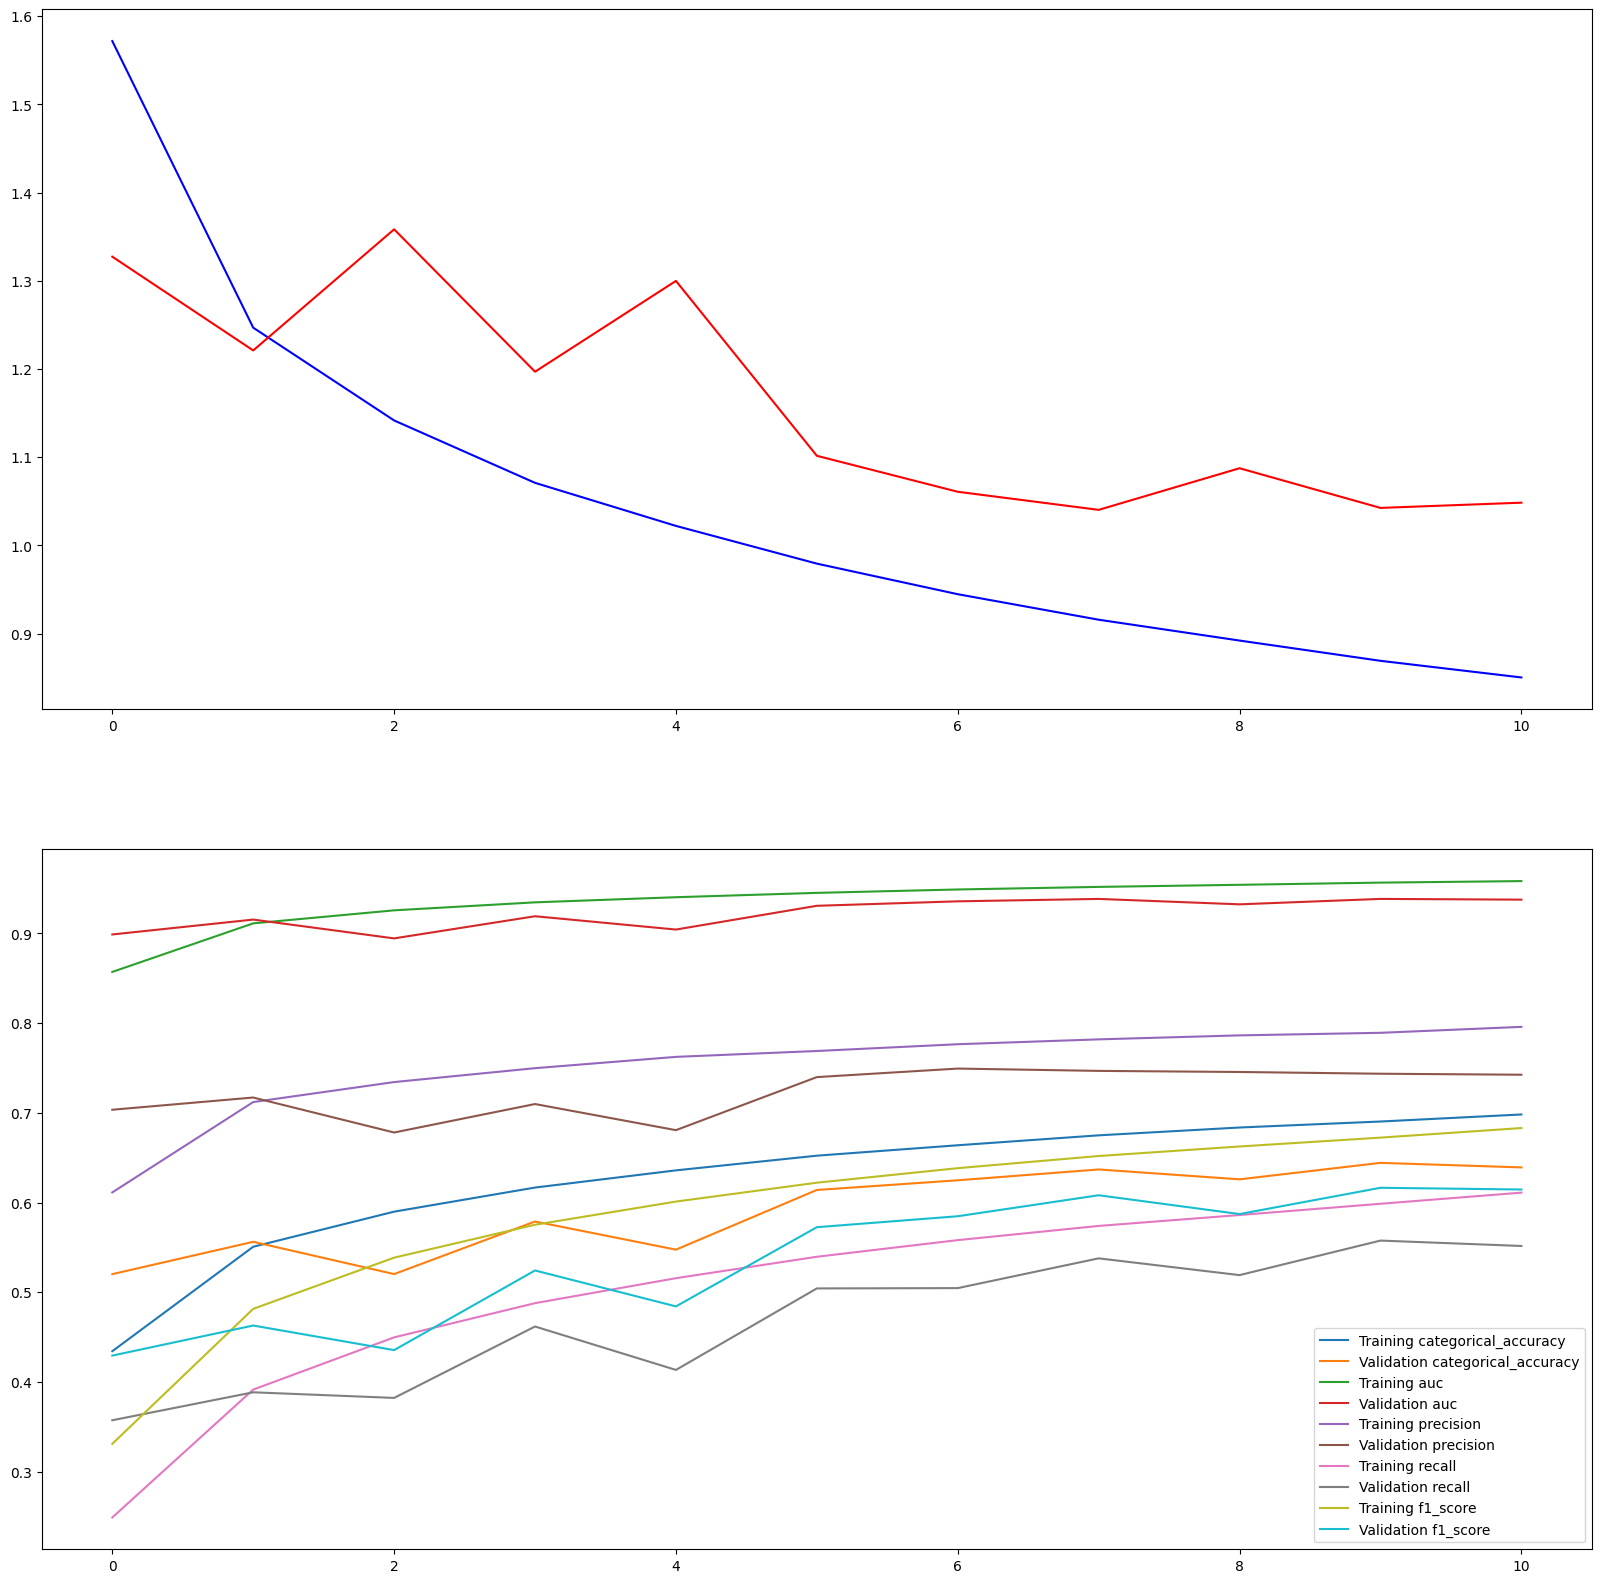

In [19]:
show_training_validation_loss_and_metrics(model1,metrics2)

In [20]:
model1.evaluate(test_it)

5625/5625 [==============================] - 70s 12ms/step - loss: 1.0564 - categorical_accuracy: 0.6377 - auc: 0.9369 - precision: 0.7401 - recall: 0.5494 - f1_score: 0.6129


[1.0564152002334595,
 0.637677788734436,
 0.9368598461151123,
 0.7401286959648132,
 0.5494222044944763,
 0.6129473447799683]

5625/5625 [==============================] - 34s 6ms/step


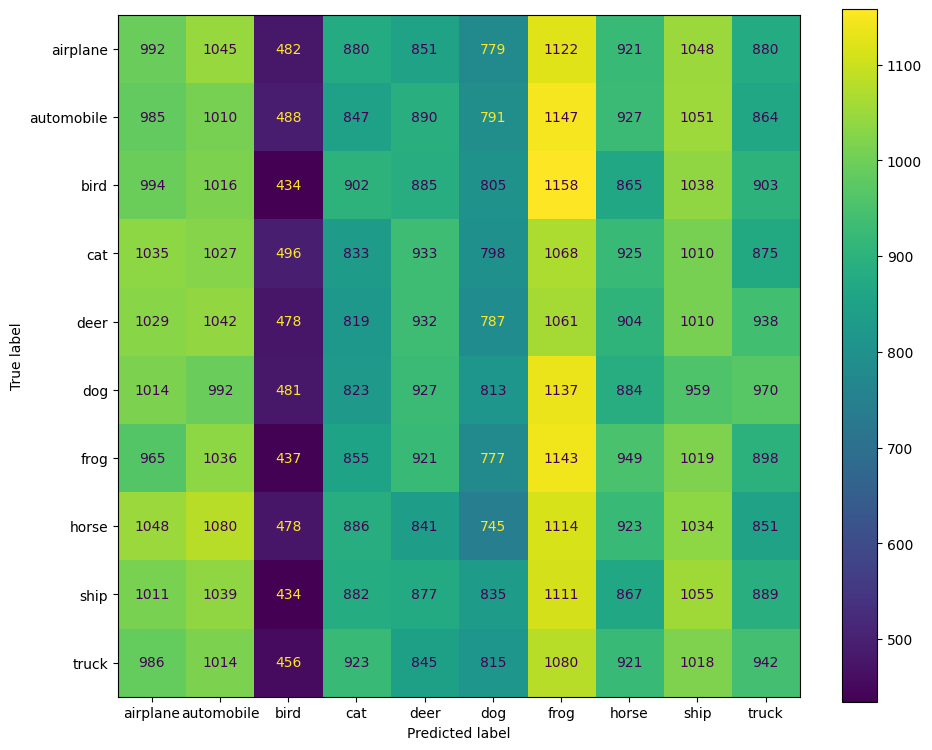

In [81]:
show_confusion_matrix(model1,test_ds,num_classes,class_names)

5625/5625 [==============================] - 33s 6ms/step


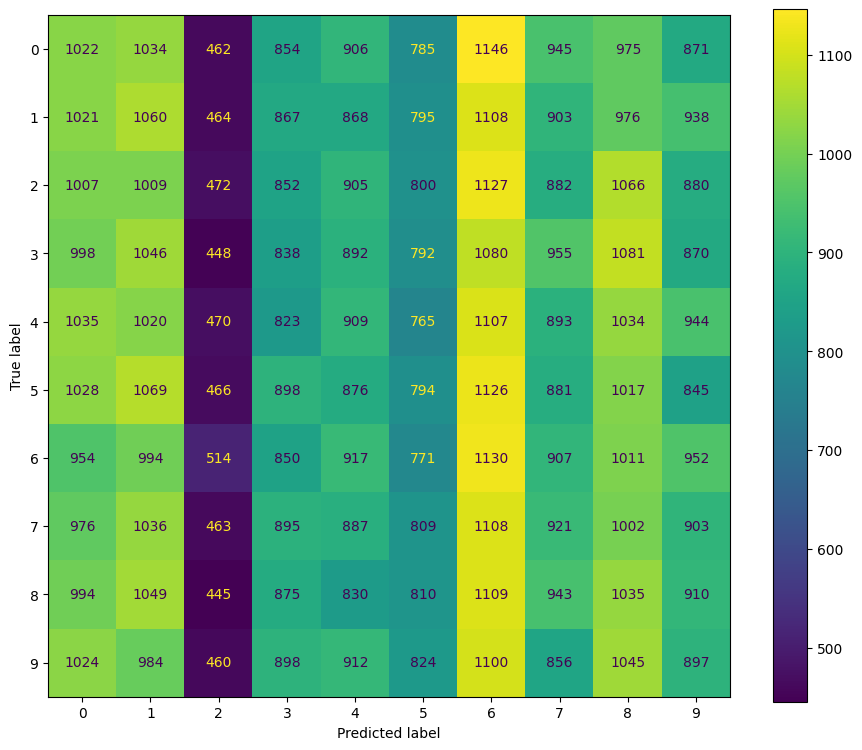

In [82]:
show_confusion_matrix_without_names(model1,test_ds,num_classes)

# Architektura drugiego modelu

In [23]:
model2 = create_model2(num_classes)

In [24]:
model2.compile( 
    loss=loss_func,
    metrics=metrics
)

In [25]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 75)        2100      
                                                                 
 layer_normalization (Layer  (None, 32, 32, 75)        150       
 Normalization)                                                  
                                                                 
 average_pooling2d (Average  (None, 16, 16, 75)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 50)        33800     
                                                                 
 layer_normalization_1 (Lay  (None, 16, 16, 50)        100       
 erNormalization)                                                
                                                      

In [26]:
history = model2.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 235s 41ms/step - loss: 1.7367 - categorical_accuracy: 0.3709 - auc: 0.8186 - precision: 0.6031 - recall: 0.1449 - f1_score: 0.4480 - val_loss: 1.4826 - val_categorical_accuracy: 0.4578 - val_auc: 0.8718 - val_precision: 0.6783 - val_recall: 0.2486 - val_f1_score: 0.3190
Epoch 2/20
5625/5625 [==============================] - 232s 41ms/step - loss: 1.4171 - categorical_accuracy: 0.4847 - auc: 0.8841 - precision: 0.6854 - recall: 0.2828 - f1_score: 0.3710 - val_loss: 1.3504 - val_categorical_accuracy: 0.5186 - val_auc: 0.8956 - val_precision: 0.7270 - val_recall: 0.2907 - val_f1_score: 0.3841
Epoch 3/20
5625/5625 [==============================] - 233s 41ms/step - loss: 1.3129 - categorical_accuracy: 0.5267 - auc: 0.9012 - precision: 0.7086 - recall: 0.3425 - f1_score: 0.4342 - val_loss: 1.3255 - val_categorical_accuracy: 0.5202 - val_auc: 0.8993 - val_precision: 0.6900 - val_recall: 0.3513 - val_f1_score: 0.4251
Epoch 4/20
5625/562

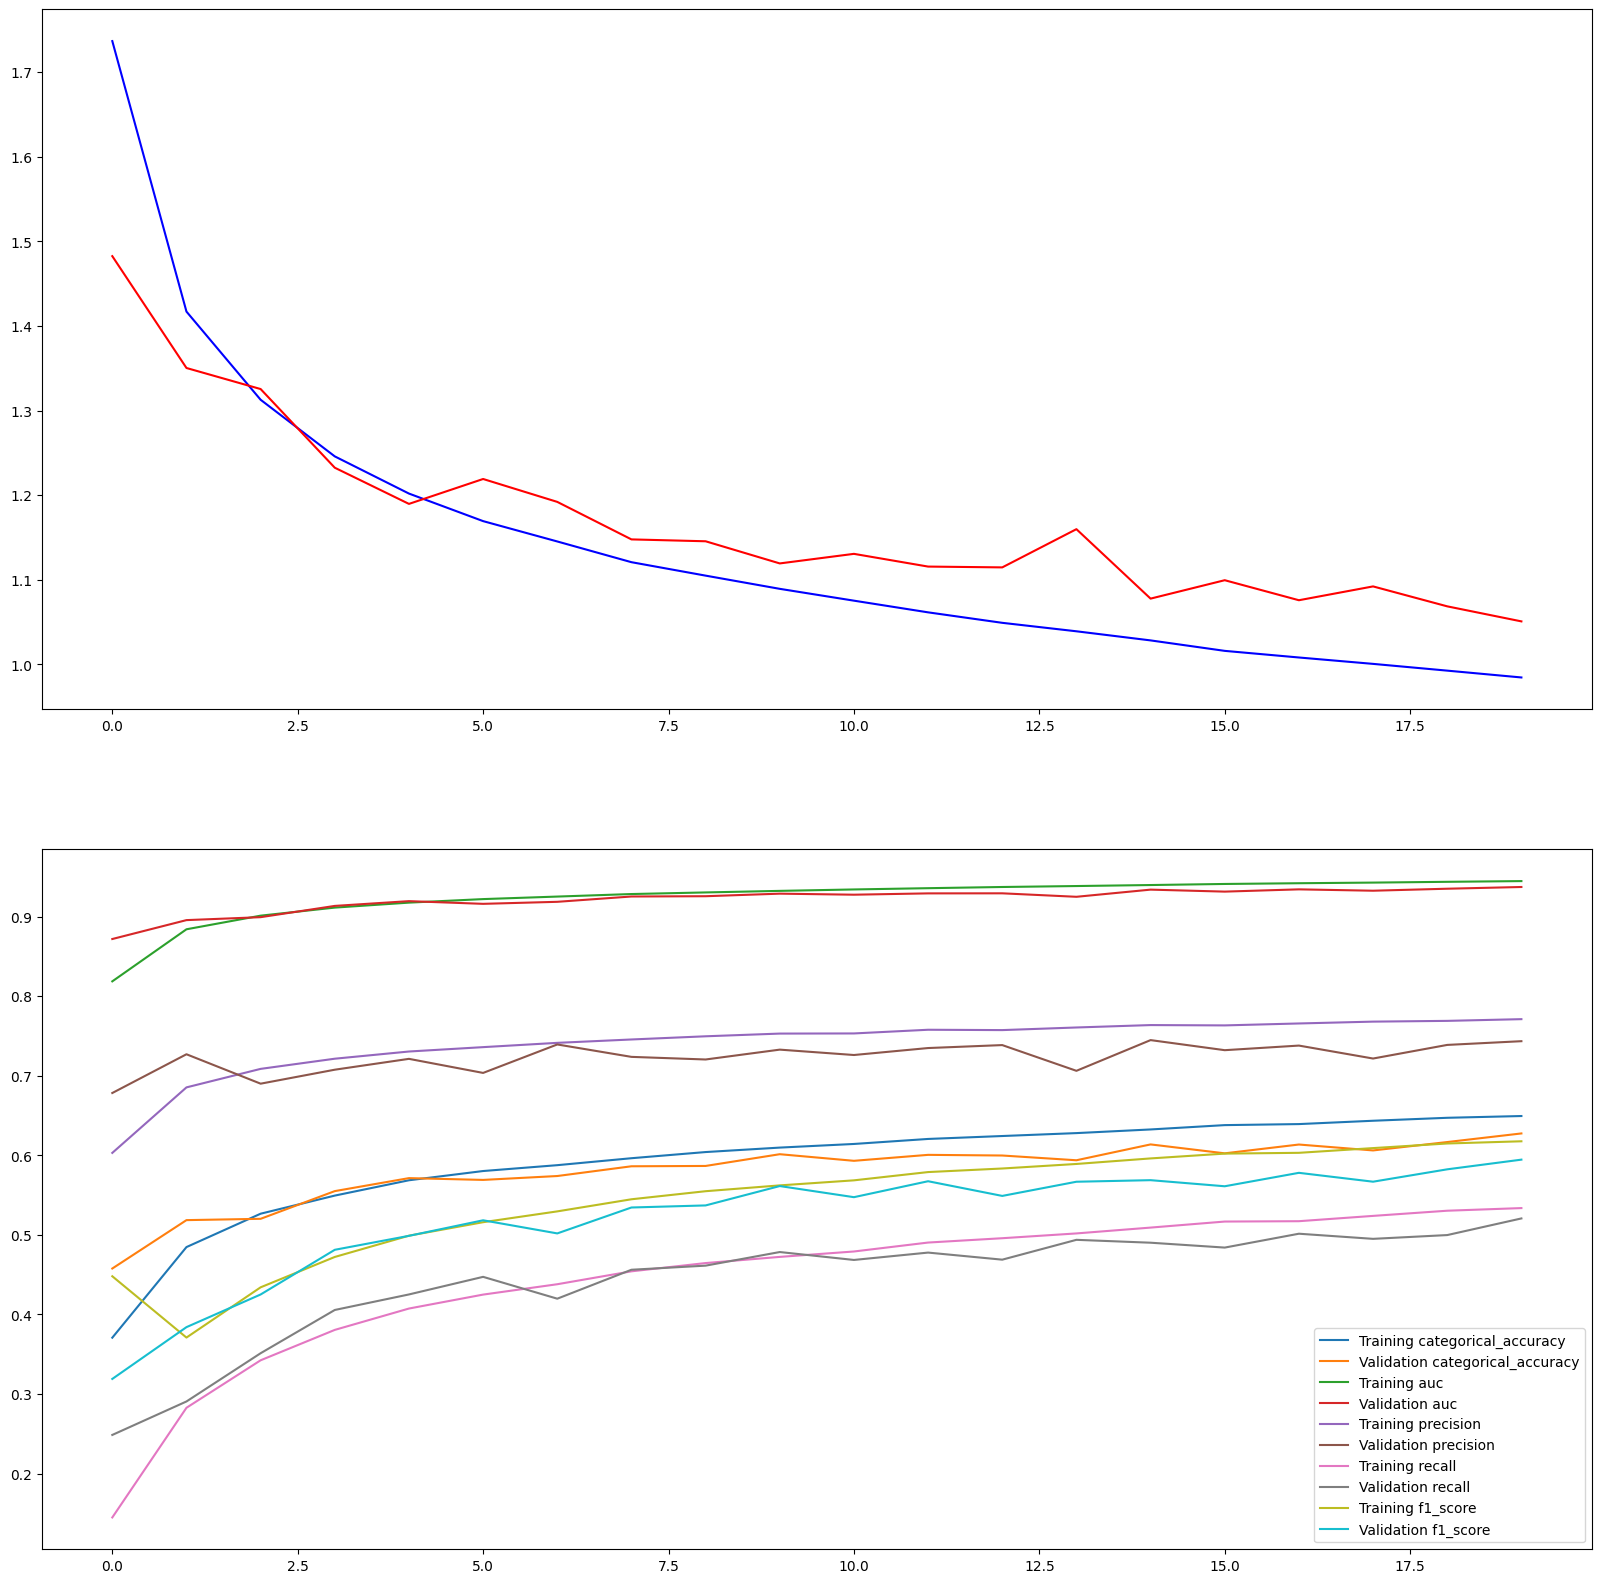

In [27]:
show_training_validation_loss_and_metrics(model2,metrics2)

In [28]:
model2.evaluate(test_it)

5625/5625 [==============================] - 96s 17ms/step - loss: 1.0591 - categorical_accuracy: 0.6240 - auc: 0.9362 - precision: 0.7420 - recall: 0.5198 - f1_score: 0.5935


[1.059141993522644,
 0.6239888668060303,
 0.9362030029296875,
 0.7419820427894592,
 0.5197666883468628,
 0.5934563875198364]

5625/5625 [==============================] - 45s 8ms/step


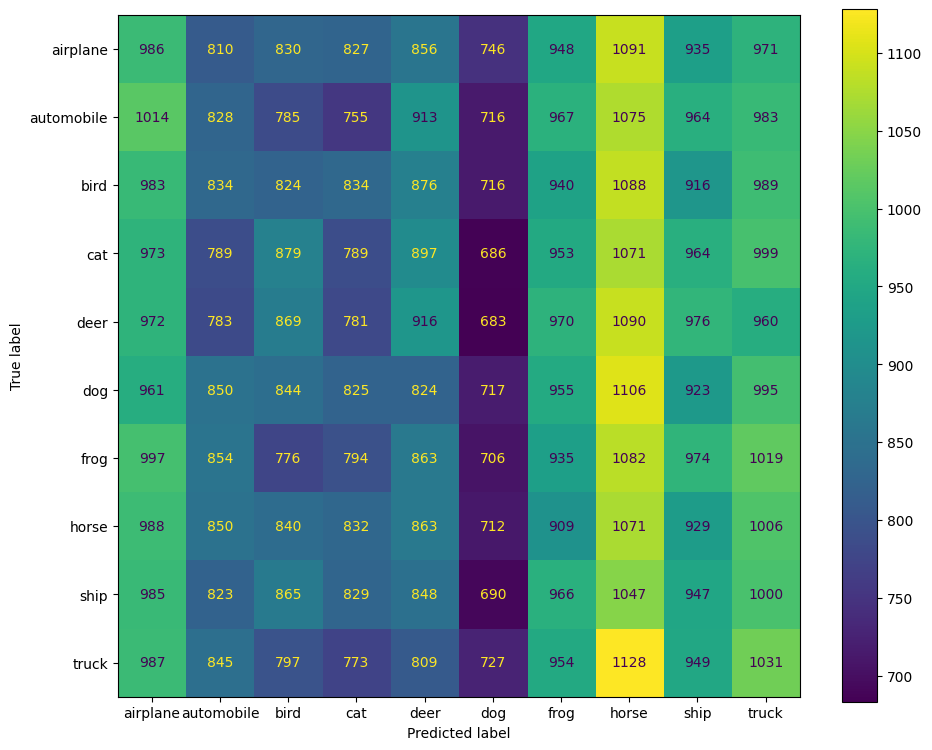

In [83]:
show_confusion_matrix(model2,test_ds,num_classes,class_names)

5625/5625 [==============================] - 46s 8ms/step


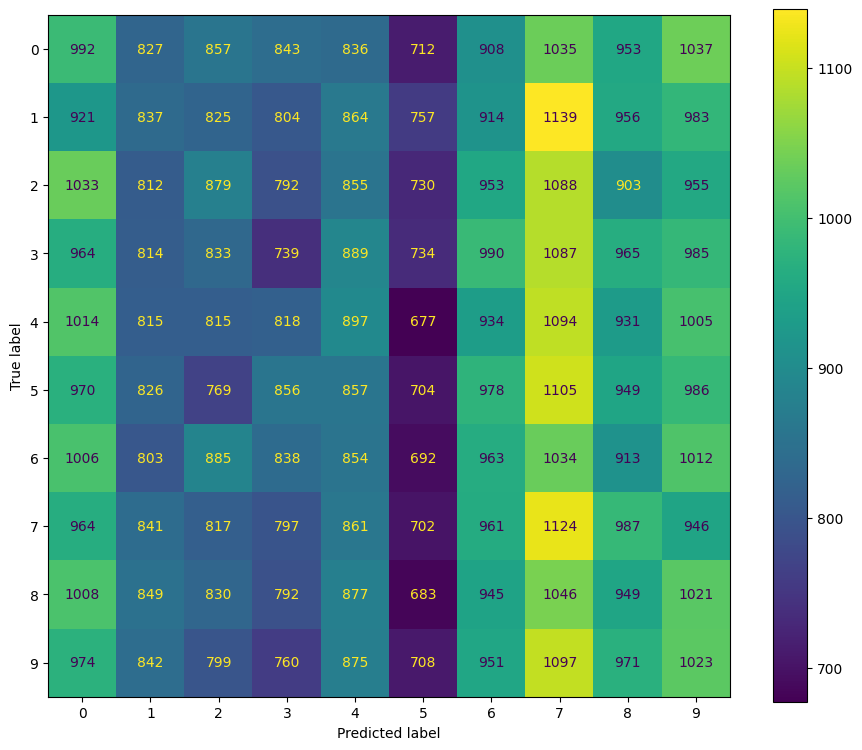

In [84]:
show_confusion_matrix_without_names(model2,test_ds,num_classes)

# Architektura trzeciego modelu

In [67]:
with tf.device('/cpu:0'):
    model3 = create_model3(num_classes)

In [68]:
with tf.device('/cpu:0'):
    model3.compile( 
        optimizer=optimiser,
        loss=loss_func,
        metrics=metrics
)

In [69]:
with tf.device('/cpu:0'):
    history = model3.fit(
        train_it,
        validation_data=valid_it,
        steps_per_epoch=train_it.samples/train_it.batch_size,
        validation_steps=valid_it.samples/valid_it.batch_size, 
        epochs=nb_epochs, 
        callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 768s 136ms/step - loss: 1.7065 - categorical_accuracy: 0.3554 - auc: 0.8230 - precision: 0.6256 - recall: 0.1207 - f1_score: 0.1835 - val_loss: 1.4966 - val_categorical_accuracy: 0.4363 - val_auc: 0.8704 - val_precision: 0.6298 - val_recall: 0.2319 - val_f1_score: 0.2769
Epoch 2/20
5625/5625 [==============================] - 669s 119ms/step - loss: 1.4051 - categorical_accuracy: 0.4813 - auc: 0.8863 - precision: 0.6830 - recall: 0.2760 - f1_score: 0.3549 - val_loss: 1.3247 - val_categorical_accuracy: 0.5121 - val_auc: 0.8994 - val_precision: 0.7169 - val_recall: 0.3185 - val_f1_score: 0.3985
Epoch 3/20
5625/5625 [==============================] - 641s 114ms/step - loss: 1.2931 - categorical_accuracy: 0.5255 - auc: 0.9045 - precision: 0.7081 - recall: 0.3421 - f1_score: 0.4258 - val_loss: 1.2365 - val_categorical_accuracy: 0.5478 - val_auc: 0.9129 - val_precision: 0.7198 - val_recall: 0.3758 - val_f1_score: 0.4556
Epoch 4/20
5625/

KeyError: 'loss'

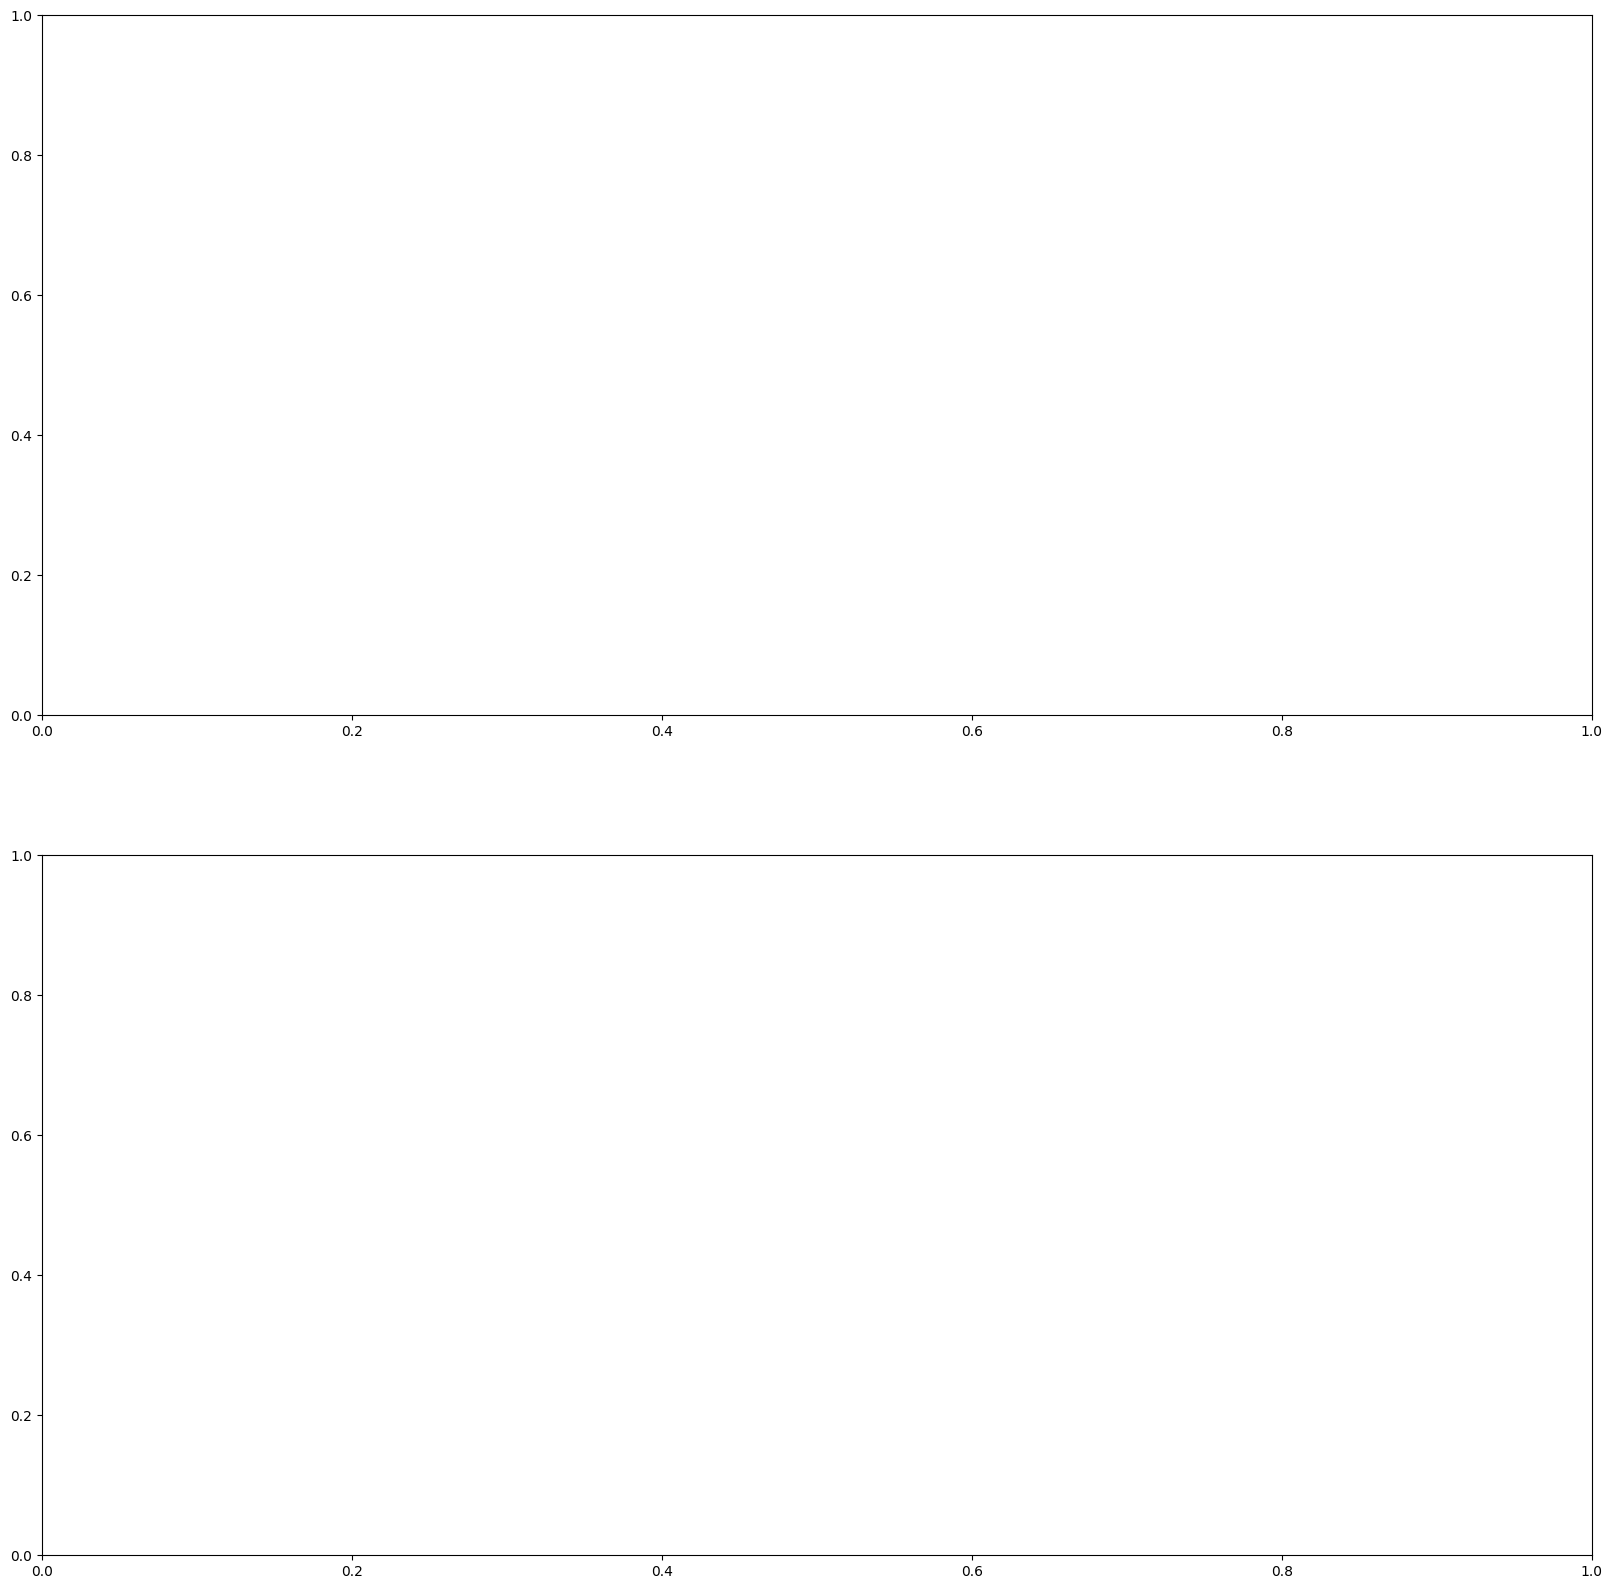

In [79]:
show_training_validation_loss_and_metrics(model3,metrics2)

In [71]:
model3.evaluate(test_it)

5625/5625 [==============================] - 149s 26ms/step - loss: 1.0730 - categorical_accuracy: 0.6235 - auc: 0.9357 - precision: 0.7188 - recall: 0.5389 - f1_score: 0.6009


[1.0730421543121338,
 0.6234777569770813,
 0.9357495307922363,
 0.7187528014183044,
 0.5388888716697693,
 0.6008942723274231]

5625/5625 [==============================] - 89s 16ms/step


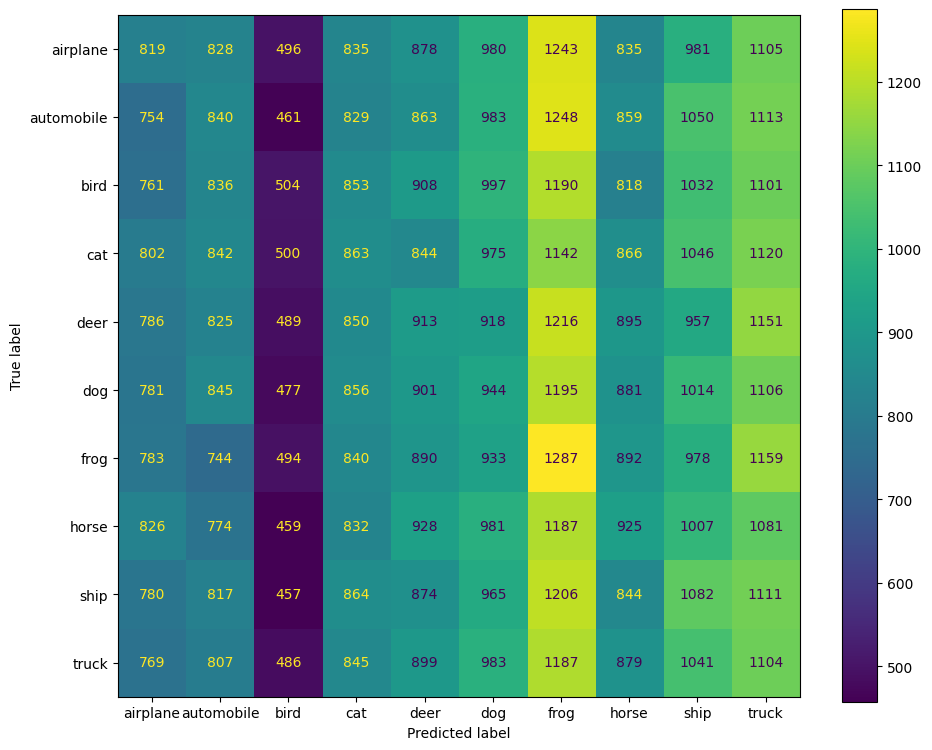

In [80]:
show_confusion_matrix(model3,test_ds,num_classes,class_names)

5625/5625 [==============================] - 88s 16ms/step


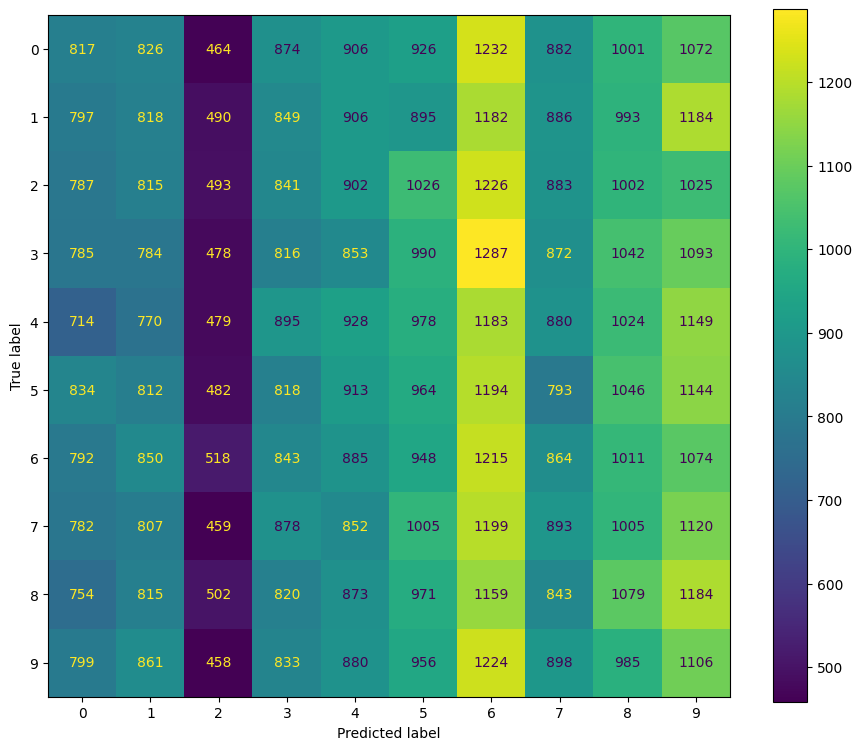

In [78]:
show_confusion_matrix_without_names(model3,test_ds,num_classes)

# Ziarno 1234

In [17]:
SEED = 1234
tf.random.set_seed(SEED)

# Architektura pierwszego modelu

In [86]:
model11 = create_model1(num_classes)

In [87]:
model11.compile( 
    loss=loss_func,
    metrics=metrics
)

In [88]:
model11.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization_4 (Bat  (None, 32, 32, 256)       1024      
 chNormalization)                                                
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 16, 16, 256)       0         
 ng2D)                                                           
                                                                 
 conv2d_48 (Conv2D)          (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization_5 (Bat  (None, 16, 16, 128)       512       
 chNormalization)                                                
                                                     

In [89]:
history = model11.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs,
    callbacks = [callback] 
)

Epoch 1/20


5625/5625 [==============================] - 219s 39ms/step - loss: 1.5703 - categorical_accuracy: 0.4324 - auc: 0.8573 - precision: 0.6139 - recall: 0.2474 - f1_score: 0.4813 - val_loss: 1.4433 - val_categorical_accuracy: 0.4718 - val_auc: 0.8801 - val_precision: 0.6532 - val_recall: 0.2833 - val_f1_score: 0.3370
Epoch 2/20
5625/5625 [==============================] - 216s 38ms/step - loss: 1.2434 - categorical_accuracy: 0.5527 - auc: 0.9118 - precision: 0.7116 - recall: 0.3931 - f1_score: 0.4832 - val_loss: 1.2005 - val_categorical_accuracy: 0.5738 - val_auc: 0.9182 - val_precision: 0.7618 - val_recall: 0.3903 - val_f1_score: 0.4802
Epoch 3/20
5625/5625 [==============================] - 218s 39ms/step - loss: 1.1341 - categorical_accuracy: 0.5941 - auc: 0.9267 - precision: 0.7379 - recall: 0.4551 - f1_score: 0.5454 - val_loss: 1.2204 - val_categorical_accuracy: 0.5627 - val_auc: 0.9147 - val_precision: 0.7337 - val_recall: 0.4039 - val_f1_score: 0.4841
Epoch 4/20
5625/5625 [========

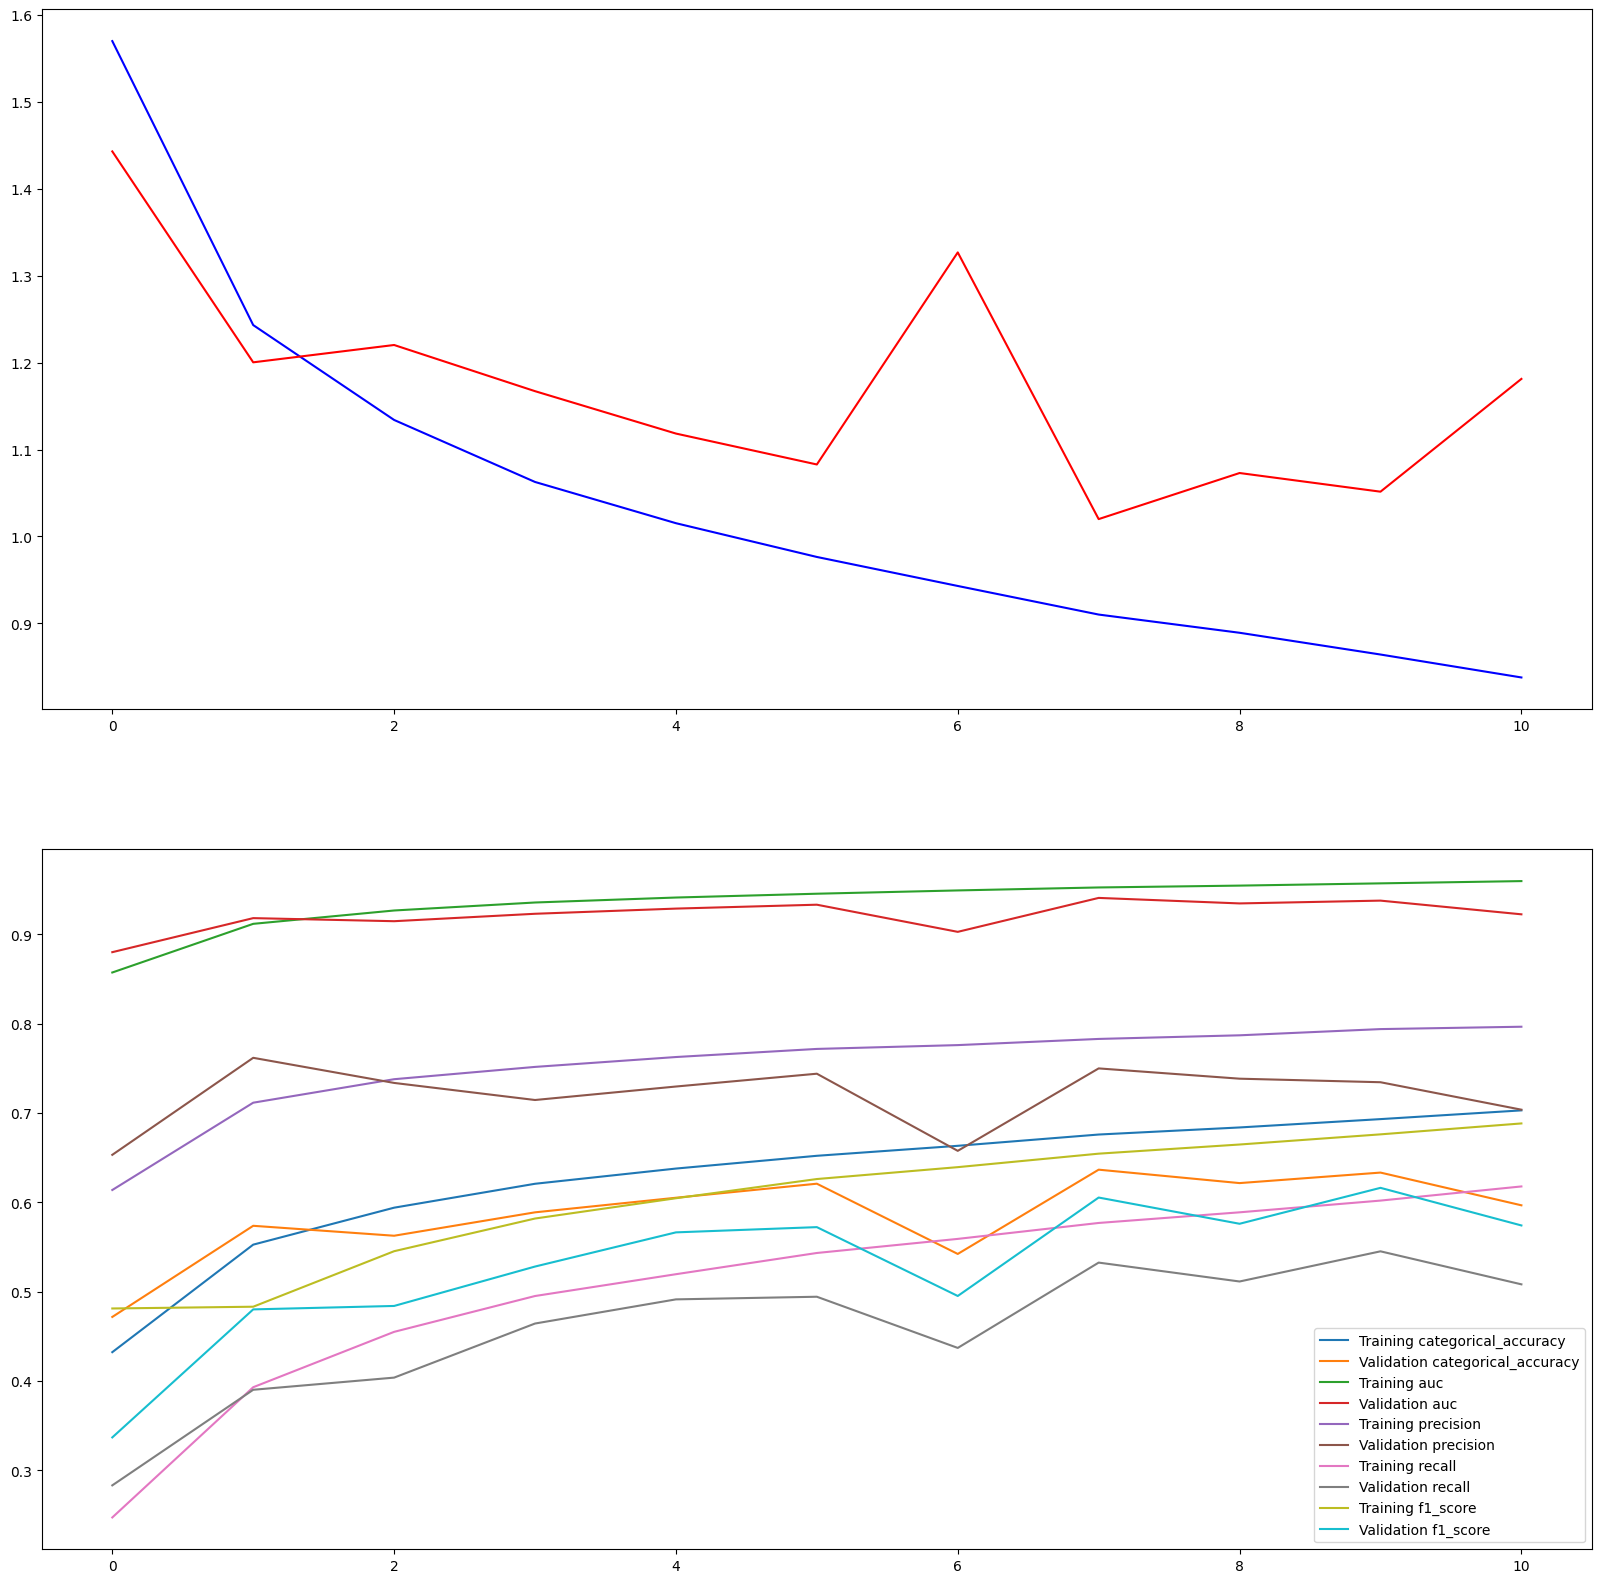

In [90]:
show_training_validation_loss_and_metrics(model11,metrics2)

In [91]:
model11.evaluate(test_it)

5625/5625 [==============================] - 70s 12ms/step - loss: 1.1897 - categorical_accuracy: 0.5969 - auc: 0.9214 - precision: 0.7037 - recall: 0.5078 - f1_score: 0.5739


[1.1896674633026123,
 0.5969444513320923,
 0.921364426612854,
 0.7036517858505249,
 0.5078333616256714,
 0.5738807320594788]

5625/5625 [==============================] - 32s 6ms/step


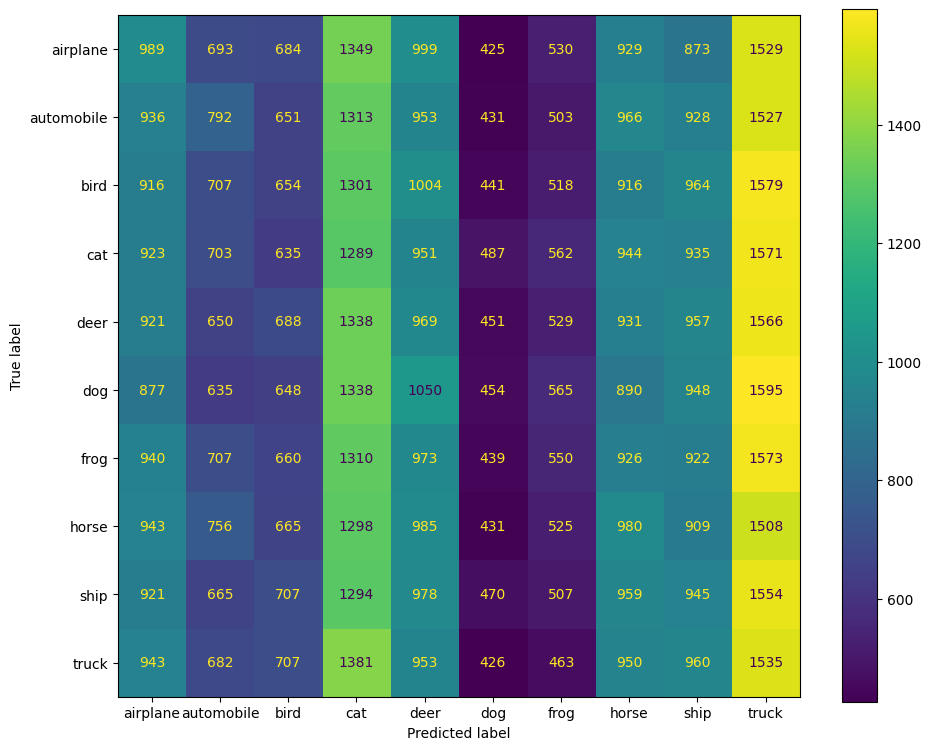

In [92]:
show_confusion_matrix(model11,test_ds,num_classes,class_names)

5625/5625 [==============================] - 33s 6ms/step


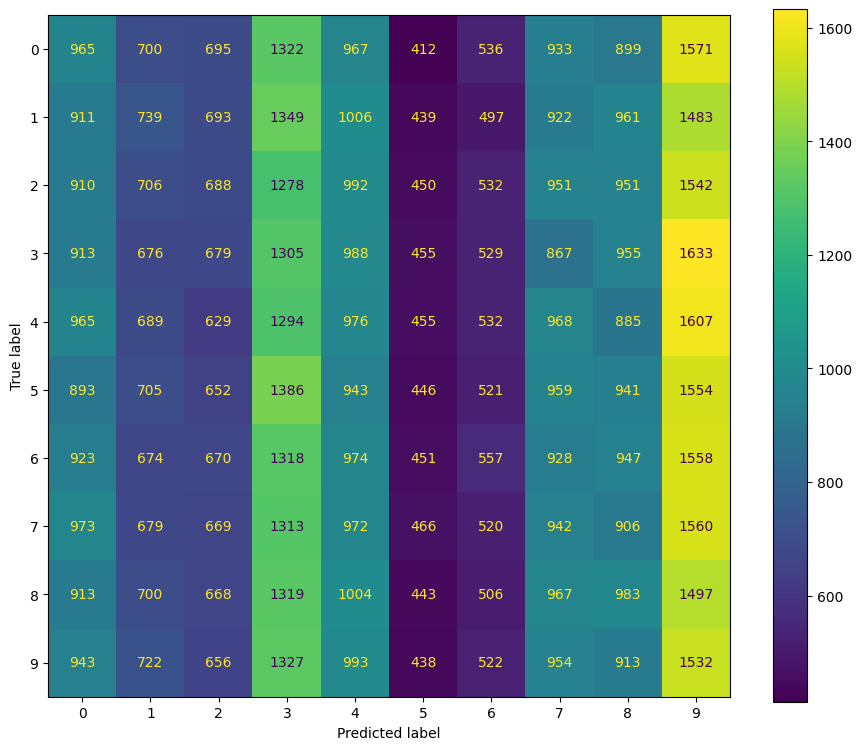

In [94]:
show_confusion_matrix_without_names(model11,test_ds,num_classes)

# Architektura drugiego modelu

In [95]:
model21 = create_model2(num_classes)

In [96]:
model21.compile( 
    loss=loss_func,
    metrics=metrics
)

In [97]:
model21.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 32, 32, 75)        2100      
                                                                 
 layer_normalization_44 (La  (None, 32, 32, 75)        150       
 yerNormalization)                                               
                                                                 
 average_pooling2d_3 (Avera  (None, 16, 16, 75)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_52 (Conv2D)          (None, 16, 16, 50)        33800     
                                                                 
 layer_normalization_45 (La  (None, 16, 16, 50)        100       
 yerNormalization)                                               
                                                     

In [98]:
history = model21.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20


5625/5625 [==============================] - 252s 44ms/step - loss: 1.7338 - categorical_accuracy: 0.3718 - auc: 0.8191 - precision: 0.6109 - recall: 0.1439 - f1_score: 0.4251 - val_loss: 1.4496 - val_categorical_accuracy: 0.4664 - val_auc: 0.8786 - val_precision: 0.6799 - val_recall: 0.2449 - val_f1_score: 0.3259
Epoch 2/20
5625/5625 [==============================] - 247s 44ms/step - loss: 1.4074 - categorical_accuracy: 0.4880 - auc: 0.8859 - precision: 0.6835 - recall: 0.2871 - f1_score: 0.3746 - val_loss: 1.2966 - val_categorical_accuracy: 0.5249 - val_auc: 0.9039 - val_precision: 0.7034 - val_recall: 0.3417 - val_f1_score: 0.4217
Epoch 3/20
5625/5625 [==============================] - 246s 44ms/step - loss: 1.3063 - categorical_accuracy: 0.5280 - auc: 0.9022 - precision: 0.7090 - recall: 0.3461 - f1_score: 0.4364 - val_loss: 1.2391 - val_categorical_accuracy: 0.5523 - val_auc: 0.9123 - val_precision: 0.7149 - val_recall: 0.3943 - val_f1_score: 0.4689
Epoch 4/20
5625/5625 [========

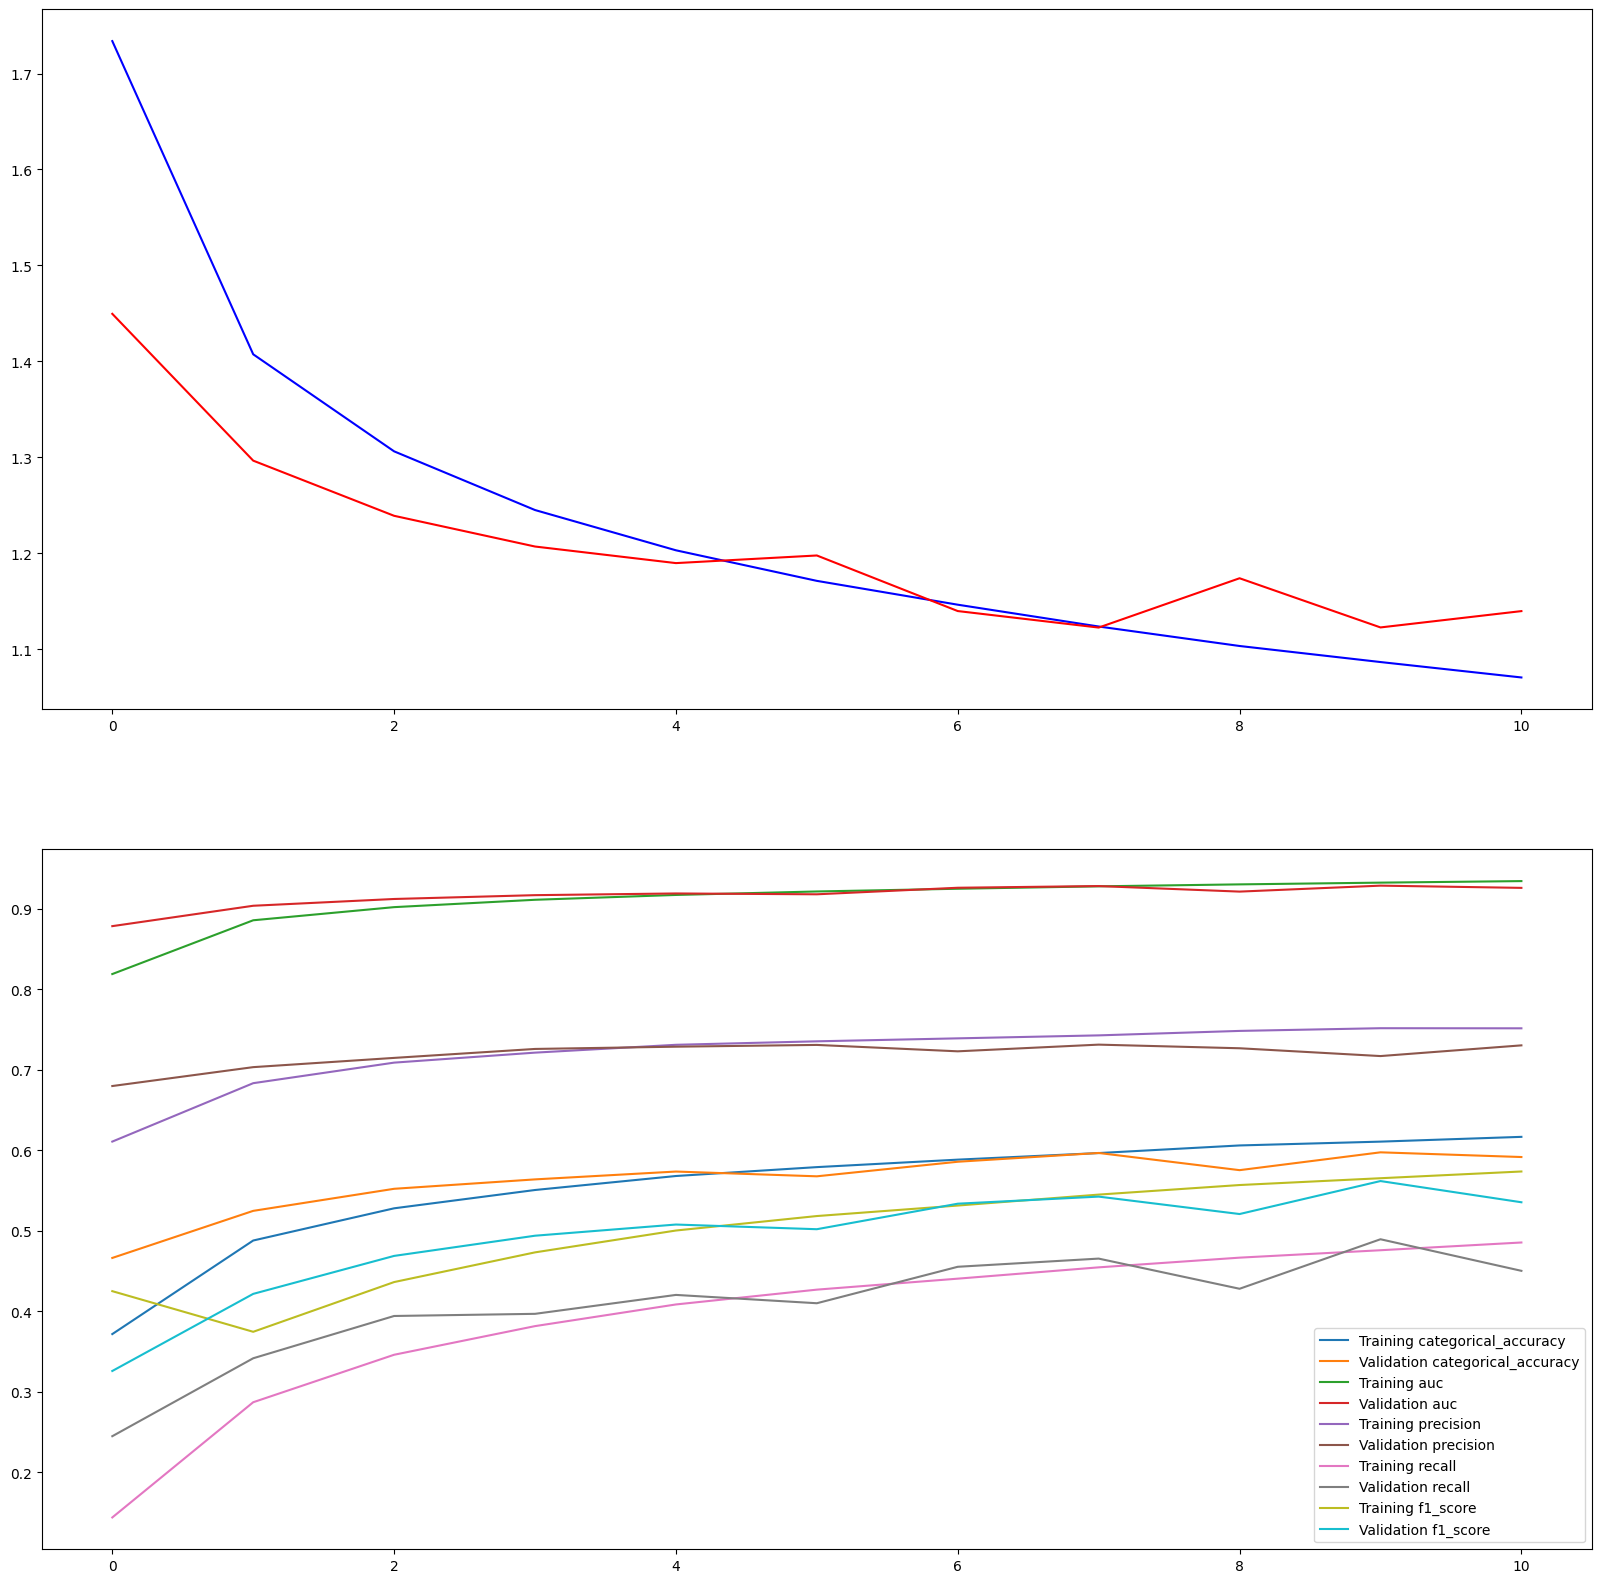

In [99]:
show_training_validation_loss_and_metrics(model21,metrics2)

In [100]:
model21.evaluate(test_it)

5625/5625 [==============================] - 99s 18ms/step - loss: 1.1505 - categorical_accuracy: 0.5929 - auc: 0.9246 - precision: 0.7309 - recall: 0.4494 - f1_score: 0.5344


[1.1505206823349,
 0.5929111242294312,
 0.9245846271514893,
 0.7308887839317322,
 0.44936665892601013,
 0.5343890190124512]

5625/5625 [==============================] - 45s 8ms/step


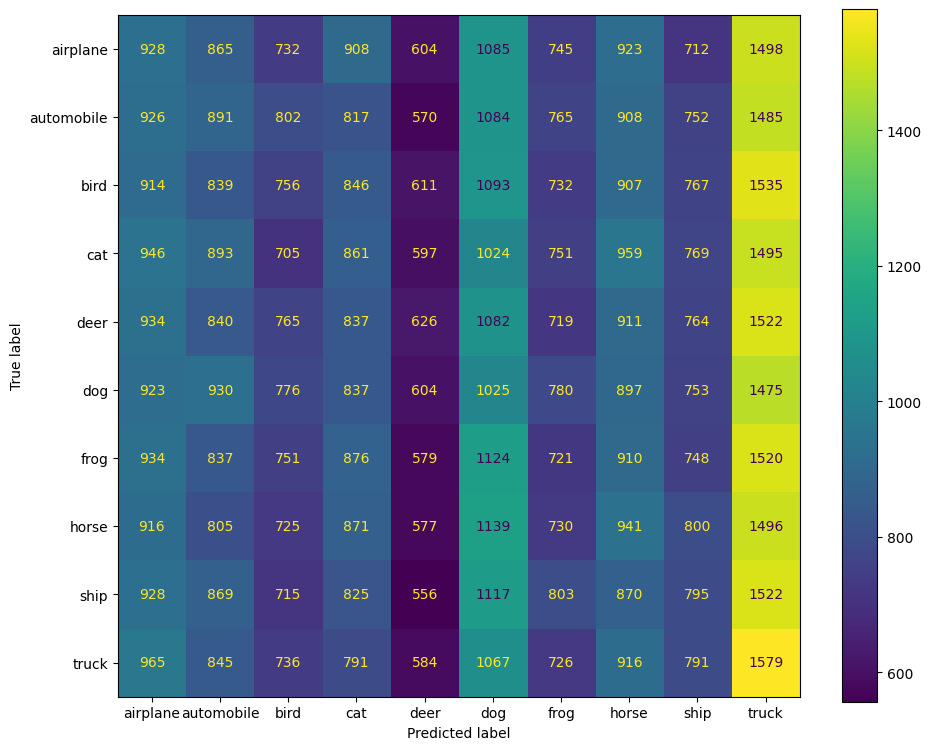

In [101]:
show_confusion_matrix(model21,test_ds,num_classes,class_names)

5625/5625 [==============================] - 44s 8ms/step


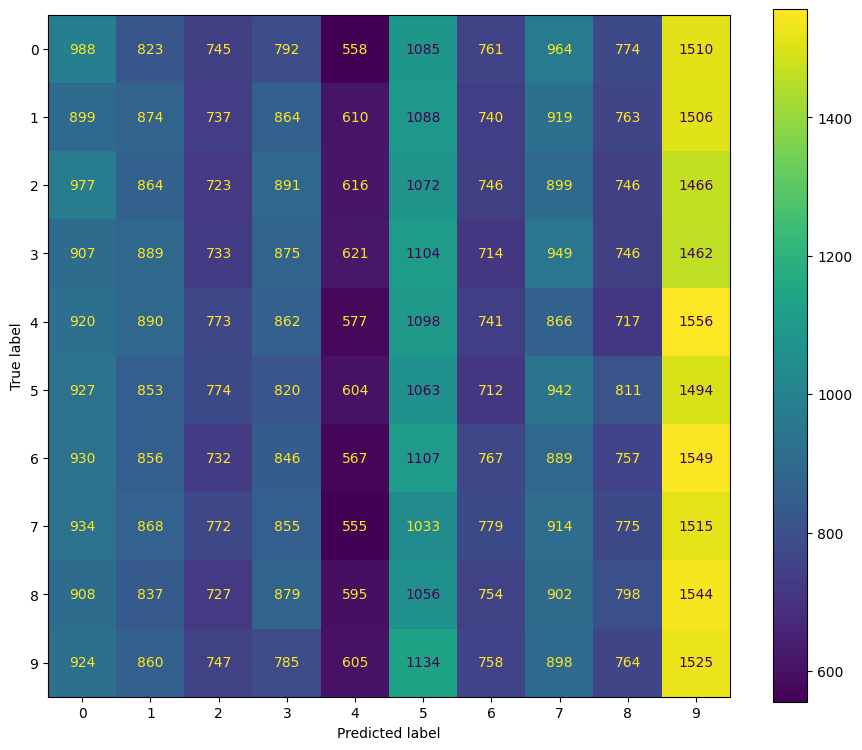

In [102]:
show_confusion_matrix_without_names(model21,test_ds,num_classes)

# Architektura trzeciego modelu

In [18]:
model31 = create_model3(num_classes)

model31.compile( 
    optimizer=optimiser,
    loss=loss_func,
    metrics=metrics
)

In [20]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model31.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 148s 25ms/step - loss: 1.6648 - categorical_accuracy: 0.3722 - auc: 0.8338 - precision: 0.6296 - recall: 0.1359 - f1_score: 0.2014 - val_loss: 1.4435 - val_categorical_accuracy: 0.4687 - val_auc: 0.8796 - val_precision: 0.6603 - val_recall: 0.2731 - val_f1_score: 0.3425
Epoch 2/20
5625/5625 [==============================] - 150s 27ms/step - loss: 1.4036 - categorical_accuracy: 0.4838 - auc: 0.8867 - precision: 0.6820 - recall: 0.2780 - f1_score: 0.3567 - val_loss: 1.3215 - val_categorical_accuracy: 0.5083 - val_auc: 0.9001 - val_precision: 0.7029 - val_recall: 0.3295 - val_f1_score: 0.4016
Epoch 3/20
5625/5625 [==============================] - 116s 21ms/step - loss: 1.2944 - categorical_accuracy: 0.5278 - auc: 0.9043 - precision: 0.7092 - recall: 0.3456 - f1_score: 0.4291 - val_loss: 1.2395 - val_categorical_accuracy: 0.5493 - val_auc: 0.9126 - val_precision: 0.7343 - val_recall: 0.3632 - val_f1_score: 0.4505
Epoch 4/20
5625/562

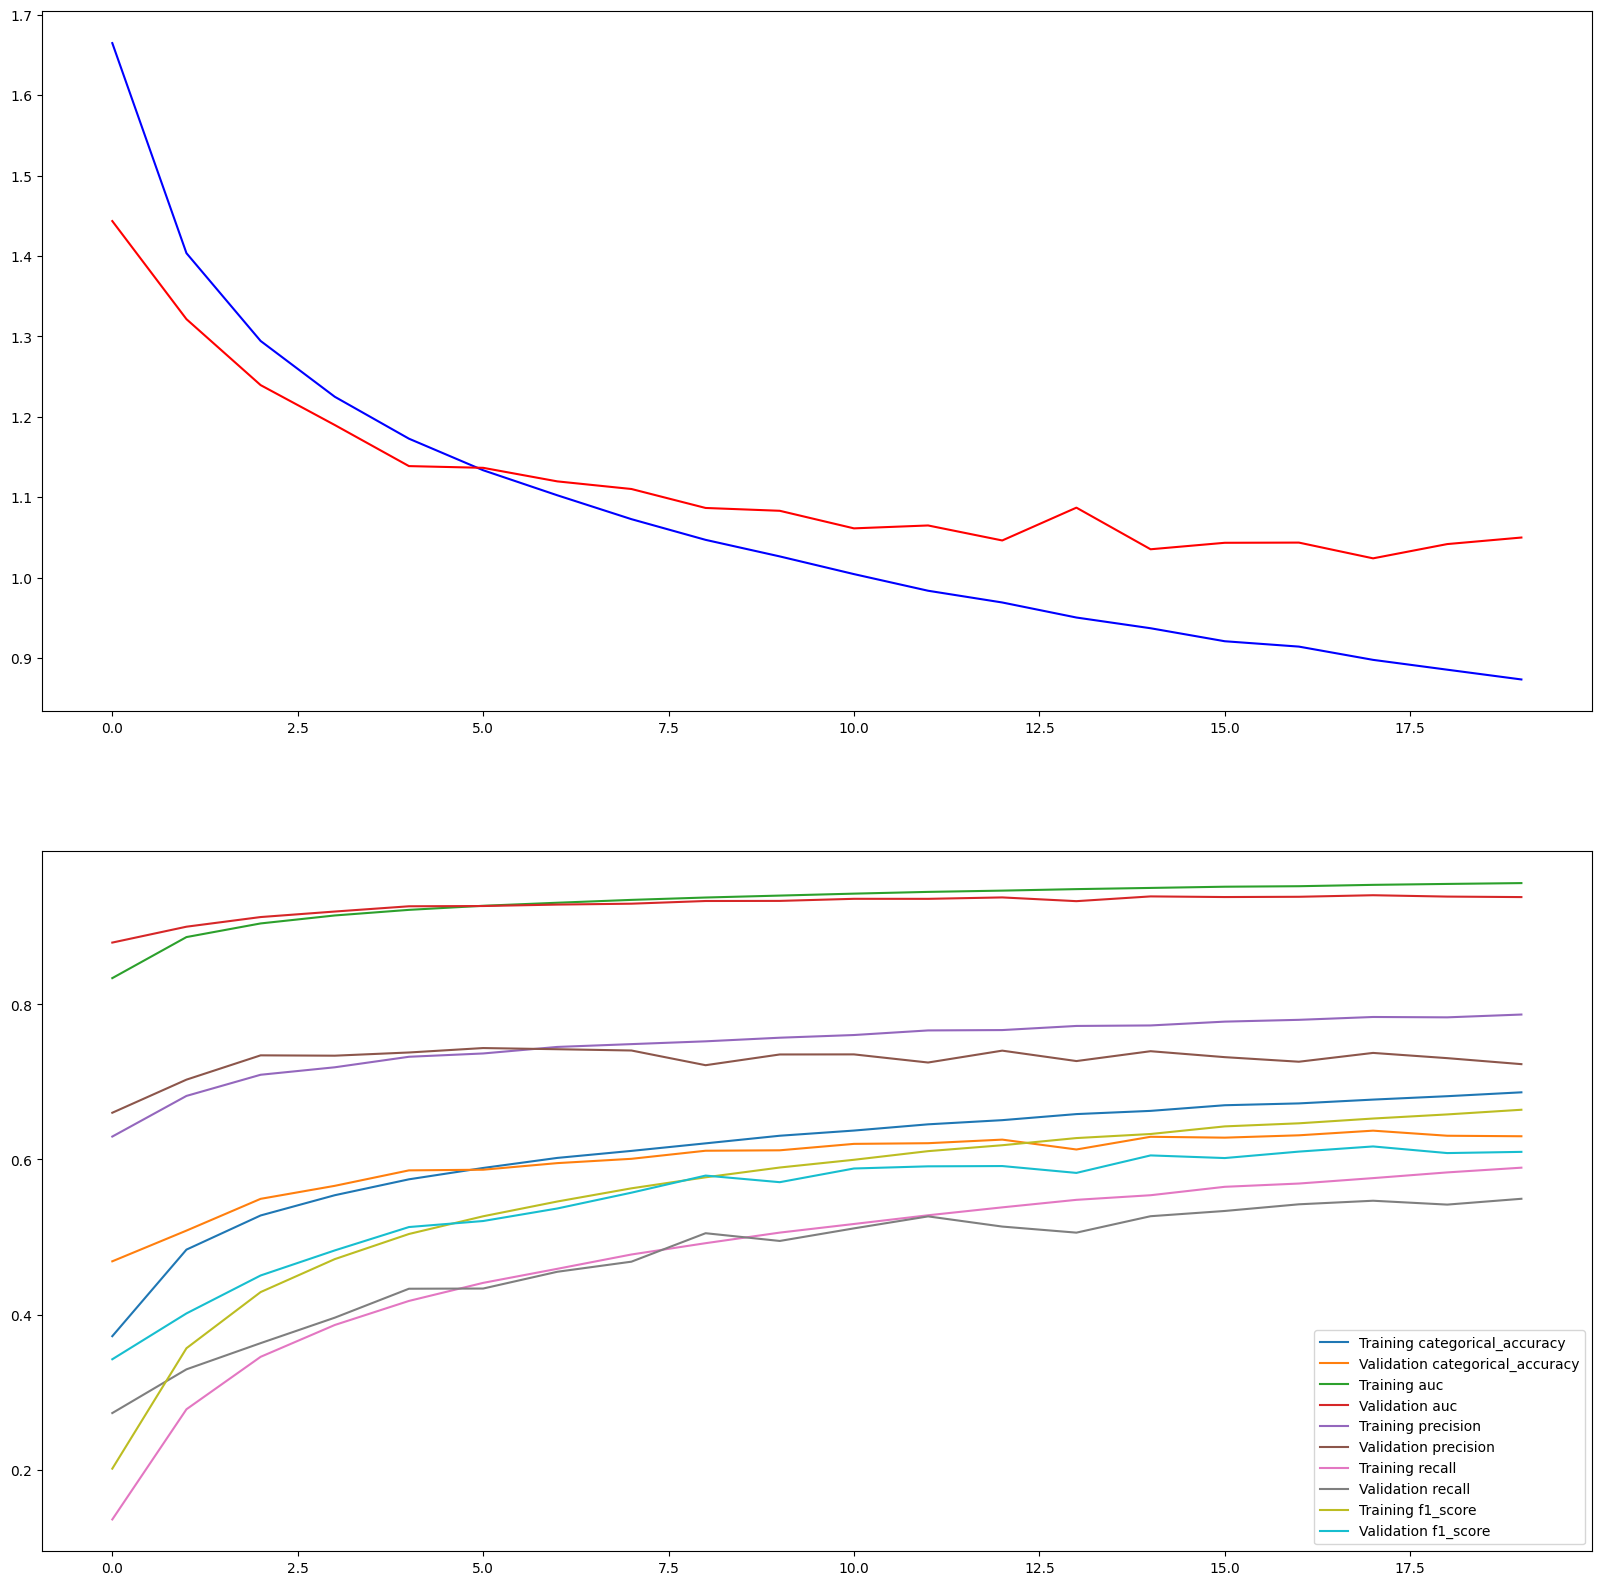

In [21]:
show_training_validation_loss_and_metrics(model31,metrics2)

In [22]:
model31.evaluate(test_it)

5625/5625 [==============================] - 63s 11ms/step - loss: 1.0635 - categorical_accuracy: 0.6293 - auc: 0.9369 - precision: 0.7204 - recall: 0.5476 - f1_score: 0.6086


[1.0634863376617432,
 0.6292666792869568,
 0.9369109869003296,
 0.7203519940376282,
 0.5475555658340454,
 0.6085730195045471]

5625/5625 [==============================] - 24s 4ms/step


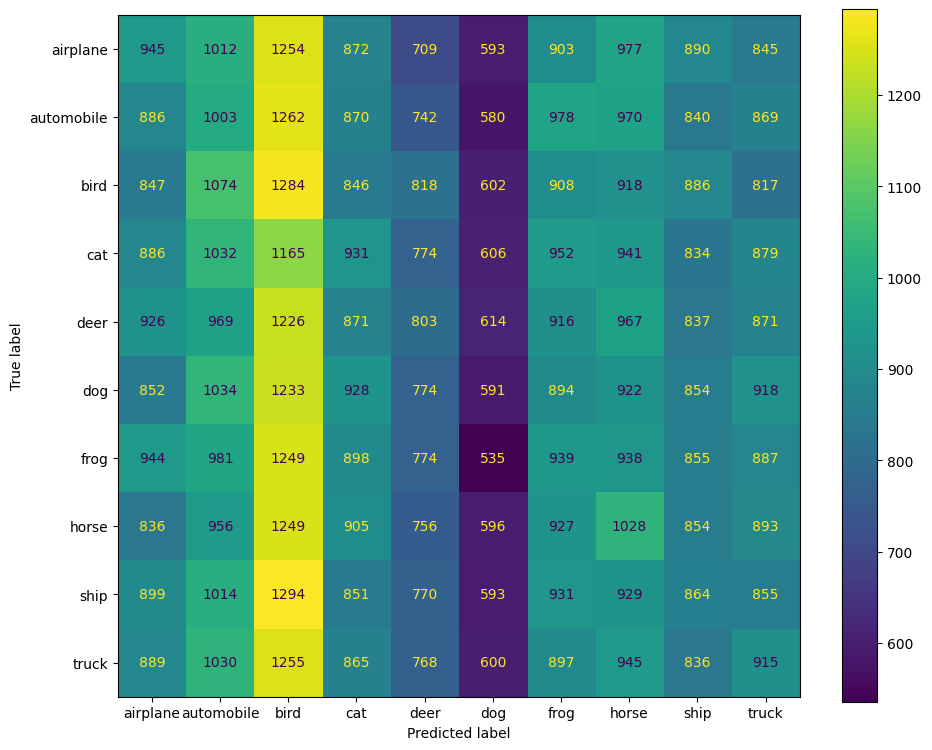

In [23]:
show_confusion_matrix(model31,test_ds,num_classes,class_names)

5625/5625 [==============================] - 24s 4ms/step


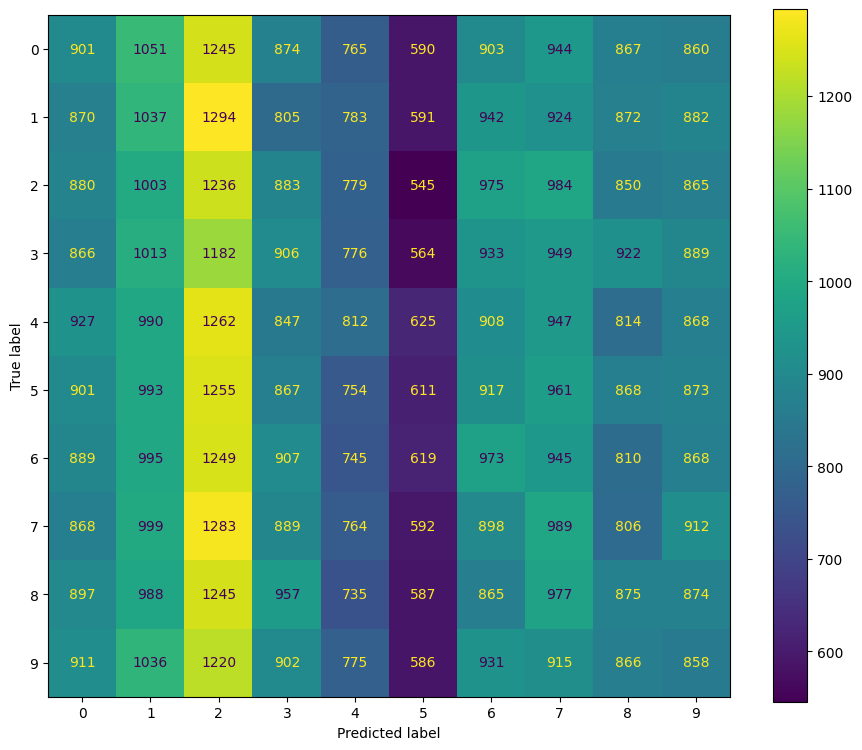

In [24]:
show_confusion_matrix_without_names(model31,test_ds,num_classes)

# Ziarno 2137

In [15]:
SEED = 2137

tf.random.set_seed(SEED)

# Architektura pierwszego modelu

In [106]:
model12 = create_model1(num_classes)

In [107]:
model12.compile( 
    loss=loss_func,
    metrics=metrics
)

In [108]:
model12.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_59 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization_8 (Bat  (None, 32, 32, 256)       1024      
 chNormalization)                                                
                                                                 
 max_pooling2d_53 (MaxPooli  (None, 16, 16, 256)       0         
 ng2D)                                                           
                                                                 
 conv2d_60 (Conv2D)          (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization_9 (Bat  (None, 16, 16, 128)       512       
 chNormalization)                                                
                                                     

In [109]:
history = model12.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs,
    callbacks = [callback] 
)

Epoch 1/20


5625/5625 [==============================] - 223s 39ms/step - loss: 1.5753 - categorical_accuracy: 0.4312 - auc: 0.8564 - precision: 0.6085 - recall: 0.2450 - f1_score: 0.4383 - val_loss: 1.5009 - val_categorical_accuracy: 0.4617 - val_auc: 0.8726 - val_precision: 0.6079 - val_recall: 0.3187 - val_f1_score: 0.3804
Epoch 2/20
5625/5625 [==============================] - 223s 40ms/step - loss: 1.2455 - categorical_accuracy: 0.5508 - auc: 0.9115 - precision: 0.7116 - recall: 0.3914 - f1_score: 0.4813 - val_loss: 1.1951 - val_categorical_accuracy: 0.5705 - val_auc: 0.9188 - val_precision: 0.7489 - val_recall: 0.3898 - val_f1_score: 0.4723
Epoch 3/20
5625/5625 [==============================] - 221s 39ms/step - loss: 1.1370 - categorical_accuracy: 0.5918 - auc: 0.9264 - precision: 0.7372 - recall: 0.4518 - f1_score: 0.5411 - val_loss: 1.3300 - val_categorical_accuracy: 0.5287 - val_auc: 0.9005 - val_precision: 0.6666 - val_recall: 0.3941 - val_f1_score: 0.4603
Epoch 4/20
5625/5625 [========

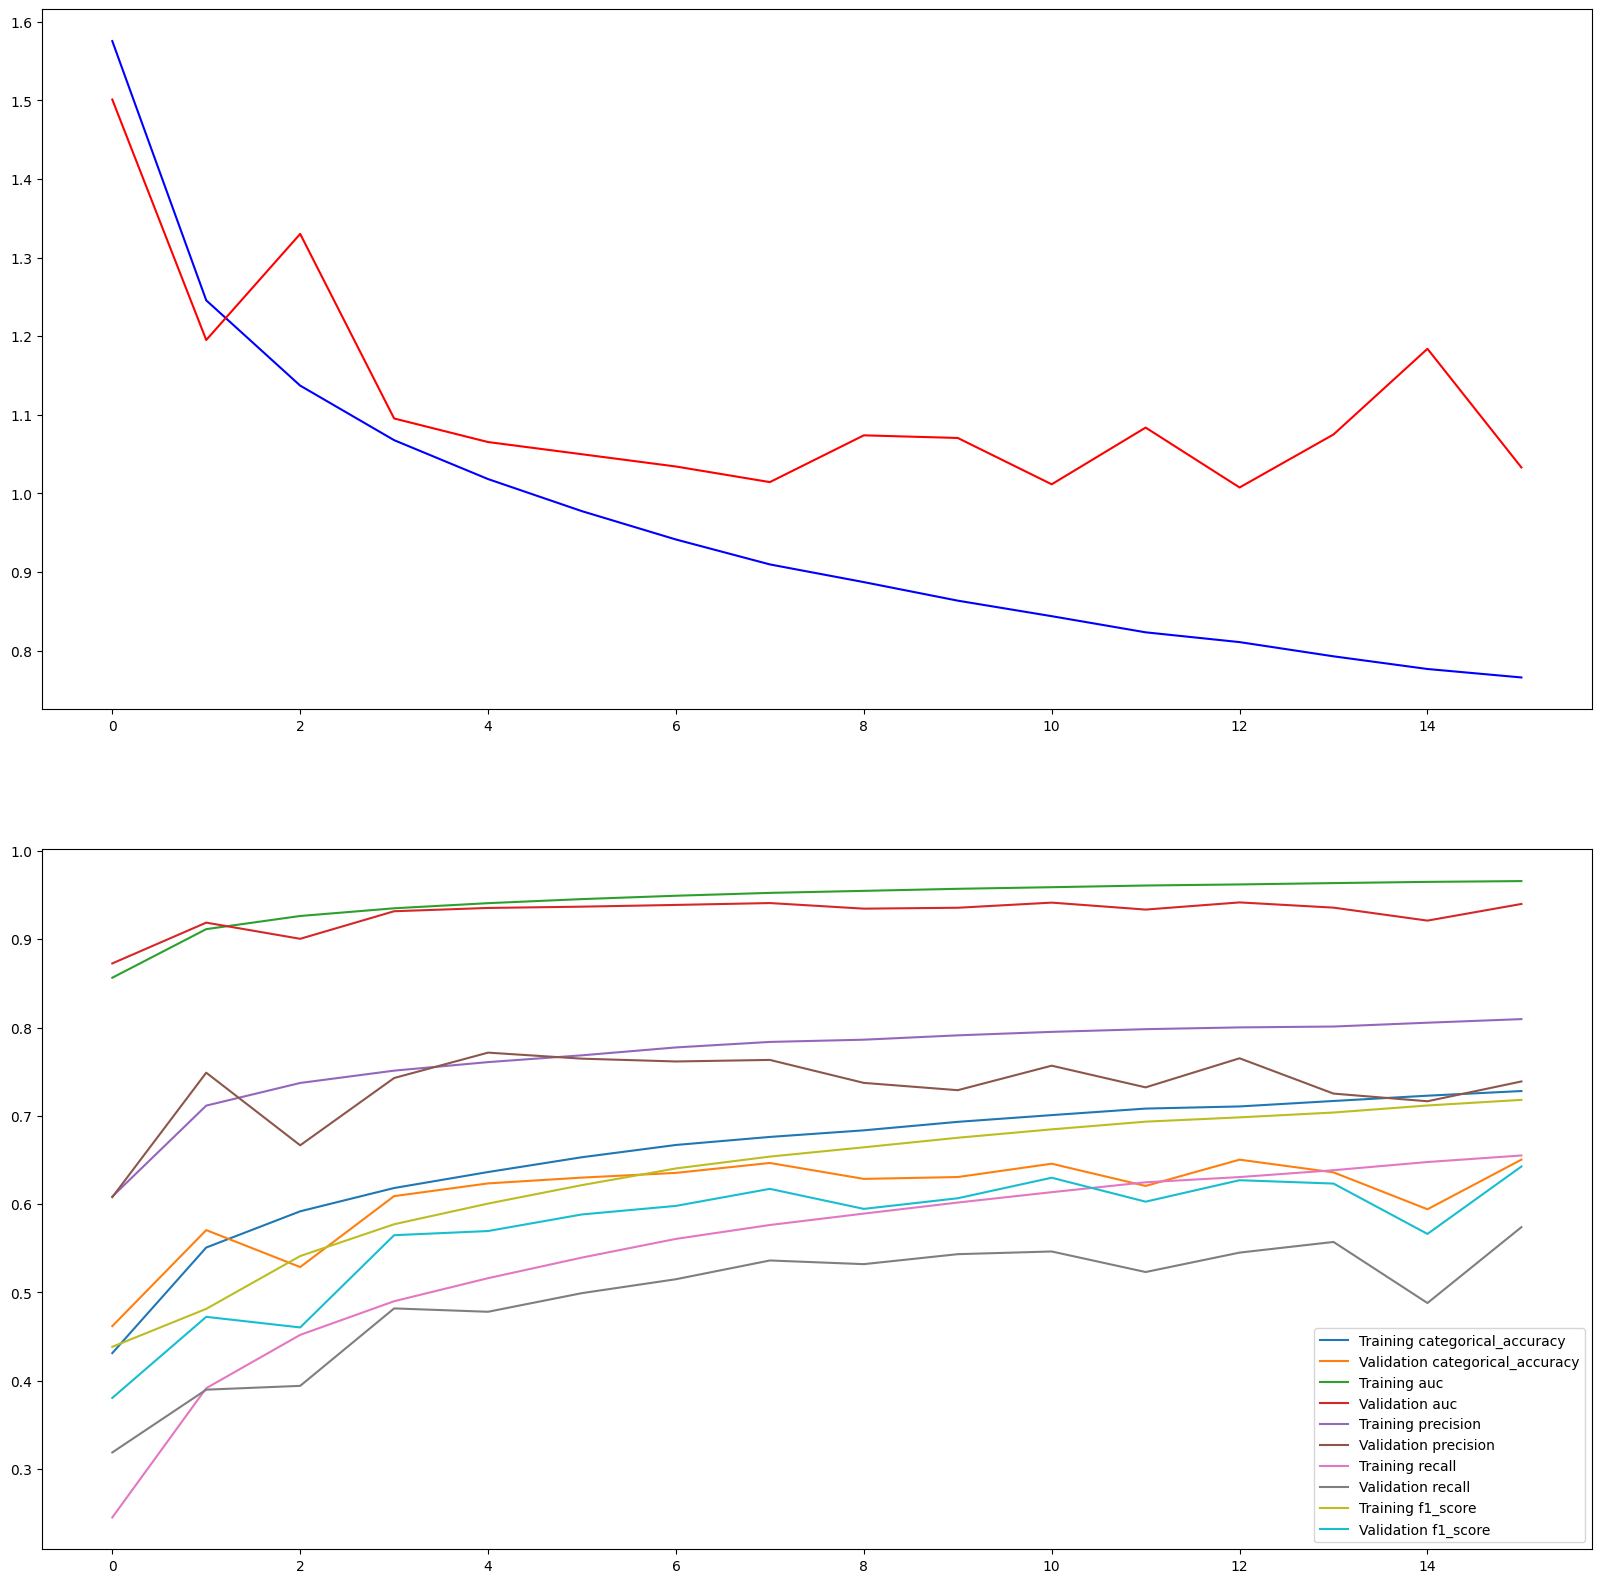

In [110]:
show_training_validation_loss_and_metrics(model12,metrics2)

In [111]:
model12.evaluate(test_it)

5625/5625 [==============================] - 75s 13ms/step - loss: 1.0471 - categorical_accuracy: 0.6475 - auc: 0.9386 - precision: 0.7357 - recall: 0.5724 - f1_score: 0.6407


[1.0471097230911255,
 0.6474888920783997,
 0.9385920763015747,
 0.7356809377670288,
 0.572433352470398,
 0.6406673789024353]

5625/5625 [==============================] - 34s 6ms/step


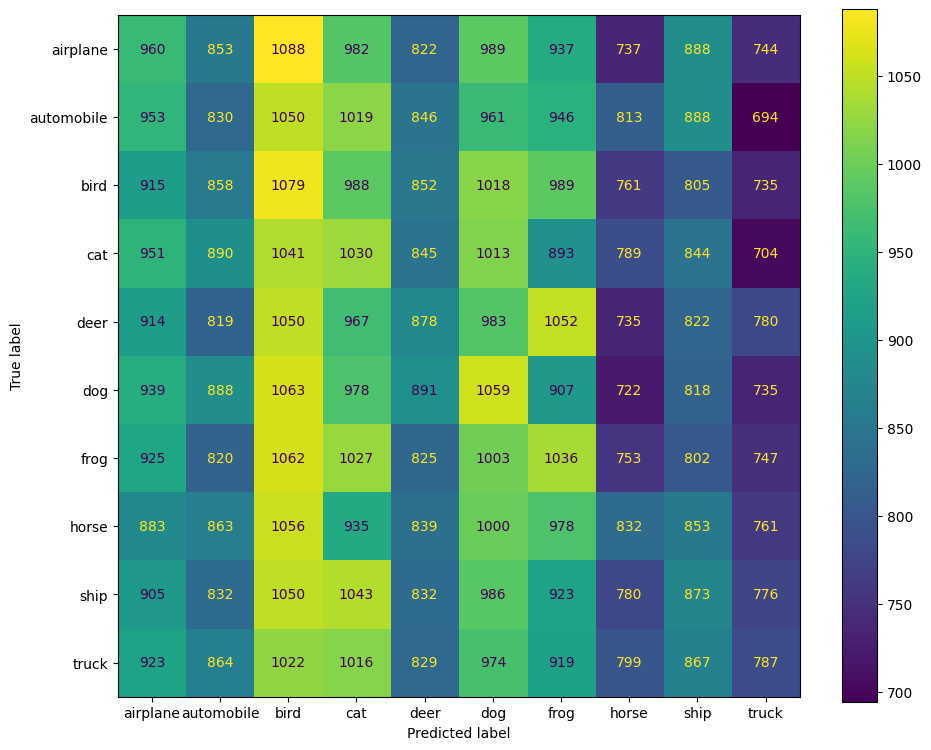

In [112]:
show_confusion_matrix(model12,test_ds,num_classes,class_names)

5625/5625 [==============================] - 34s 6ms/step


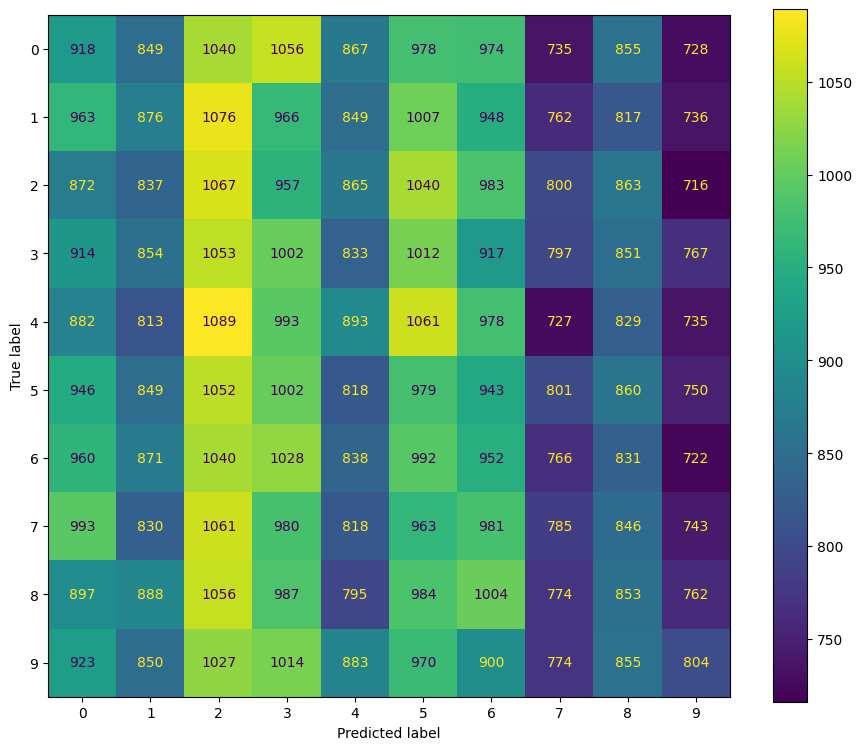

In [113]:
show_confusion_matrix_without_names(model12,test_ds,num_classes)

# Architektura drugiego modelu

In [114]:
model22 = create_model2(num_classes)

In [115]:
model22.compile( 
    loss=loss_func,
    metrics=metrics
)

In [116]:
model22.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 32, 32, 75)        2100      
                                                                 
 layer_normalization_53 (La  (None, 32, 32, 75)        150       
 yerNormalization)                                               
                                                                 
 average_pooling2d_6 (Avera  (None, 16, 16, 75)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_64 (Conv2D)          (None, 16, 16, 50)        33800     
                                                                 
 layer_normalization_54 (La  (None, 16, 16, 50)        100       
 yerNormalization)                                               
                                                     

In [117]:
history = model22.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20


5625/5625 [==============================] - 243s 43ms/step - loss: 1.7566 - categorical_accuracy: 0.3589 - auc: 0.8137 - precision: 0.5953 - recall: 0.1308 - f1_score: 0.4620 - val_loss: 1.4964 - val_categorical_accuracy: 0.4497 - val_auc: 0.8704 - val_precision: 0.6567 - val_recall: 0.2257 - val_f1_score: 0.2856
Epoch 2/20
5625/5625 [==============================] - 236s 42ms/step - loss: 1.4396 - categorical_accuracy: 0.4766 - auc: 0.8800 - precision: 0.6808 - recall: 0.2667 - f1_score: 0.3531 - val_loss: 1.4064 - val_categorical_accuracy: 0.4840 - val_auc: 0.8859 - val_precision: 0.7034 - val_recall: 0.2841 - val_f1_score: 0.3641
Epoch 3/20
5625/5625 [==============================] - 235s 42ms/step - loss: 1.3395 - categorical_accuracy: 0.5143 - auc: 0.8970 - precision: 0.7010 - recall: 0.3262 - f1_score: 0.4167 - val_loss: 1.2835 - val_categorical_accuracy: 0.5363 - val_auc: 0.9059 - val_precision: 0.7248 - val_recall: 0.3399 - val_f1_score: 0.4327
Epoch 4/20
5625/5625 [========

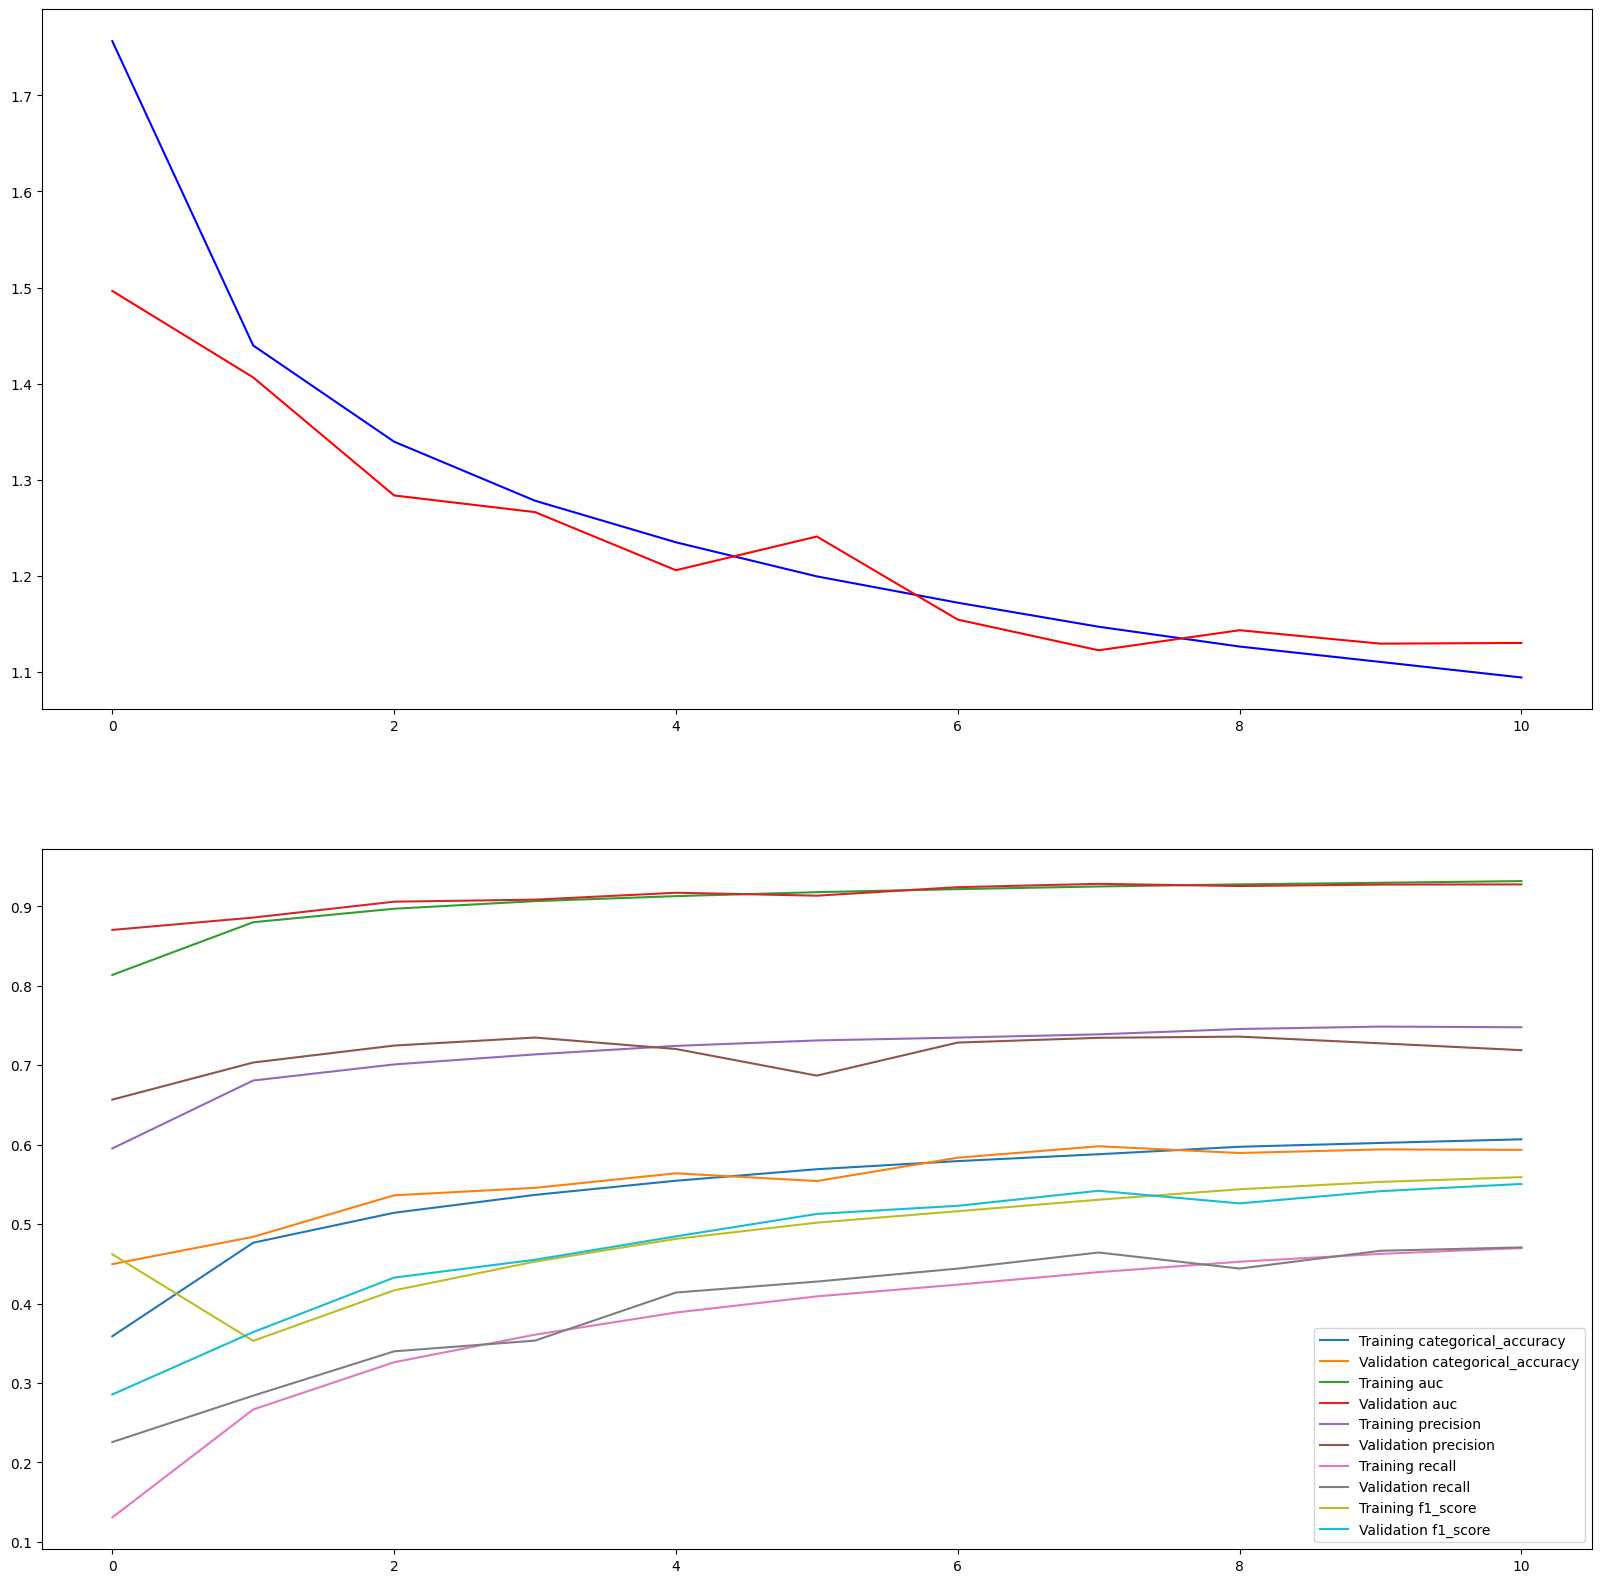

In [118]:
show_training_validation_loss_and_metrics(model22,metrics2)

In [119]:
model22.evaluate(test_it)

5625/5625 [==============================] - 98s 17ms/step - loss: 1.1358 - categorical_accuracy: 0.5925 - auc: 0.9268 - precision: 0.7188 - recall: 0.4707 - f1_score: 0.5504


[1.135833740234375,
 0.5925111174583435,
 0.9268158674240112,
 0.7188210487365723,
 0.4706999957561493,
 0.5504279732704163]

5625/5625 [==============================] - 43s 8ms/step


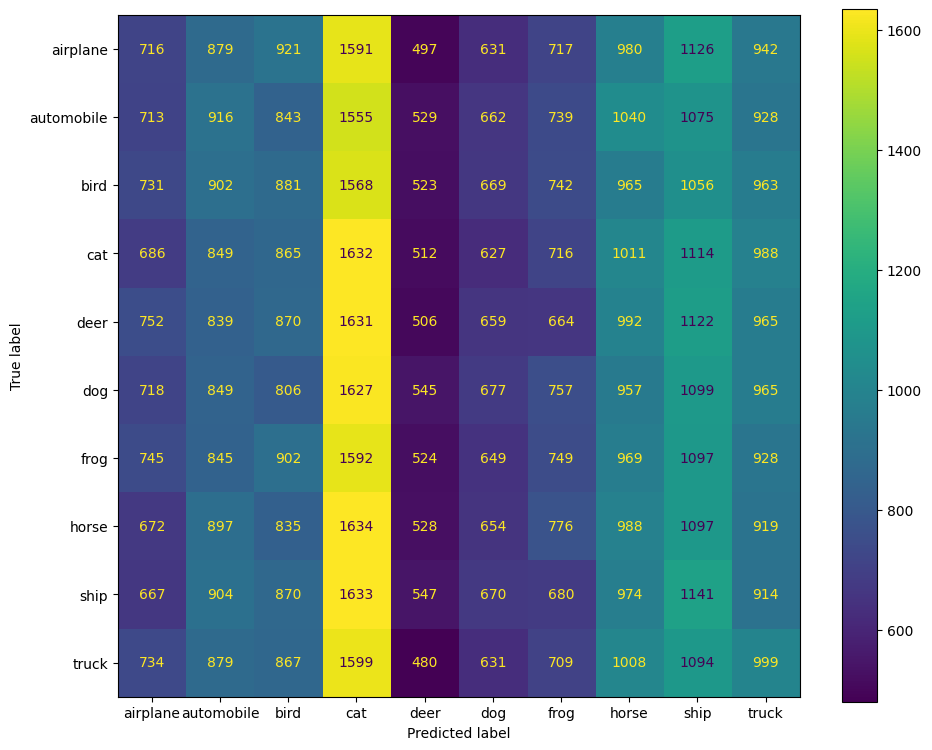

In [120]:
show_confusion_matrix(model22,test_ds,num_classes,class_names)

5625/5625 [==============================] - 44s 8ms/step


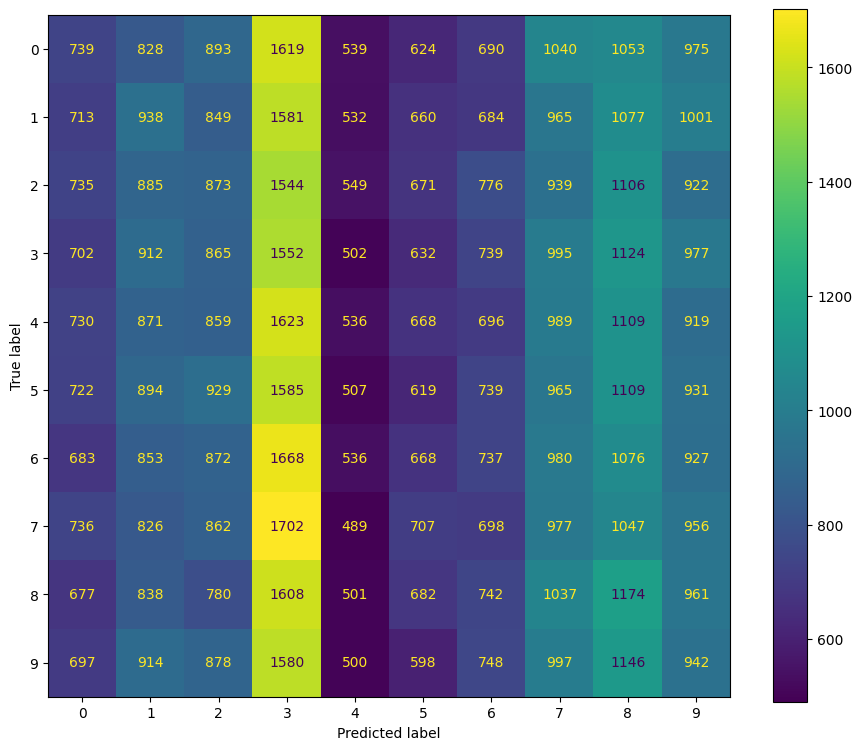

In [121]:
show_confusion_matrix_without_names(model22,test_ds,num_classes)

# Architektura trzeciego modelu

In [26]:
model32 = create_model3(num_classes)

model32.compile( 
    optimizer=optimiser,
    loss=loss_func,
    metrics=metrics
)

In [27]:
model32.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 256)       7168      
                                                                 
 layer_normalization_5 (Laye  (None, 32, 32, 256)      512       
 rNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 256)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       295040    
                                                                 
 layer_normalization_6 (Laye  (None, 16, 16, 128)      256       
 rNormalization)                                                 
                                                      

In [28]:
history = model32.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 105s 19ms/step - loss: 1.6597 - categorical_accuracy: 0.3789 - auc: 0.8351 - precision: 0.6332 - recall: 0.1407 - f1_score: 0.4459 - val_loss: 1.4366 - val_categorical_accuracy: 0.4676 - val_auc: 0.8812 - val_precision: 0.6766 - val_recall: 0.2516 - val_f1_score: 0.3190
Epoch 2/20
5625/5625 [==============================] - 104s 19ms/step - loss: 1.3919 - categorical_accuracy: 0.4883 - auc: 0.8886 - precision: 0.6843 - recall: 0.2881 - f1_score: 0.3688 - val_loss: 1.3115 - val_categorical_accuracy: 0.5171 - val_auc: 0.9020 - val_precision: 0.6770 - val_recall: 0.3506 - val_f1_score: 0.4260
Epoch 3/20
5625/5625 [==============================] - 103s 18ms/step - loss: 1.2835 - categorical_accuracy: 0.5309 - auc: 0.9060 - precision: 0.7081 - recall: 0.3508 - f1_score: 0.4346 - val_loss: 1.2678 - val_categorical_accuracy: 0.5355 - val_auc: 0.9086 - val_precision: 0.6983 - val_recall: 0.3718 - val_f1_score: 0.4435
Epoch 4/20
5625/562

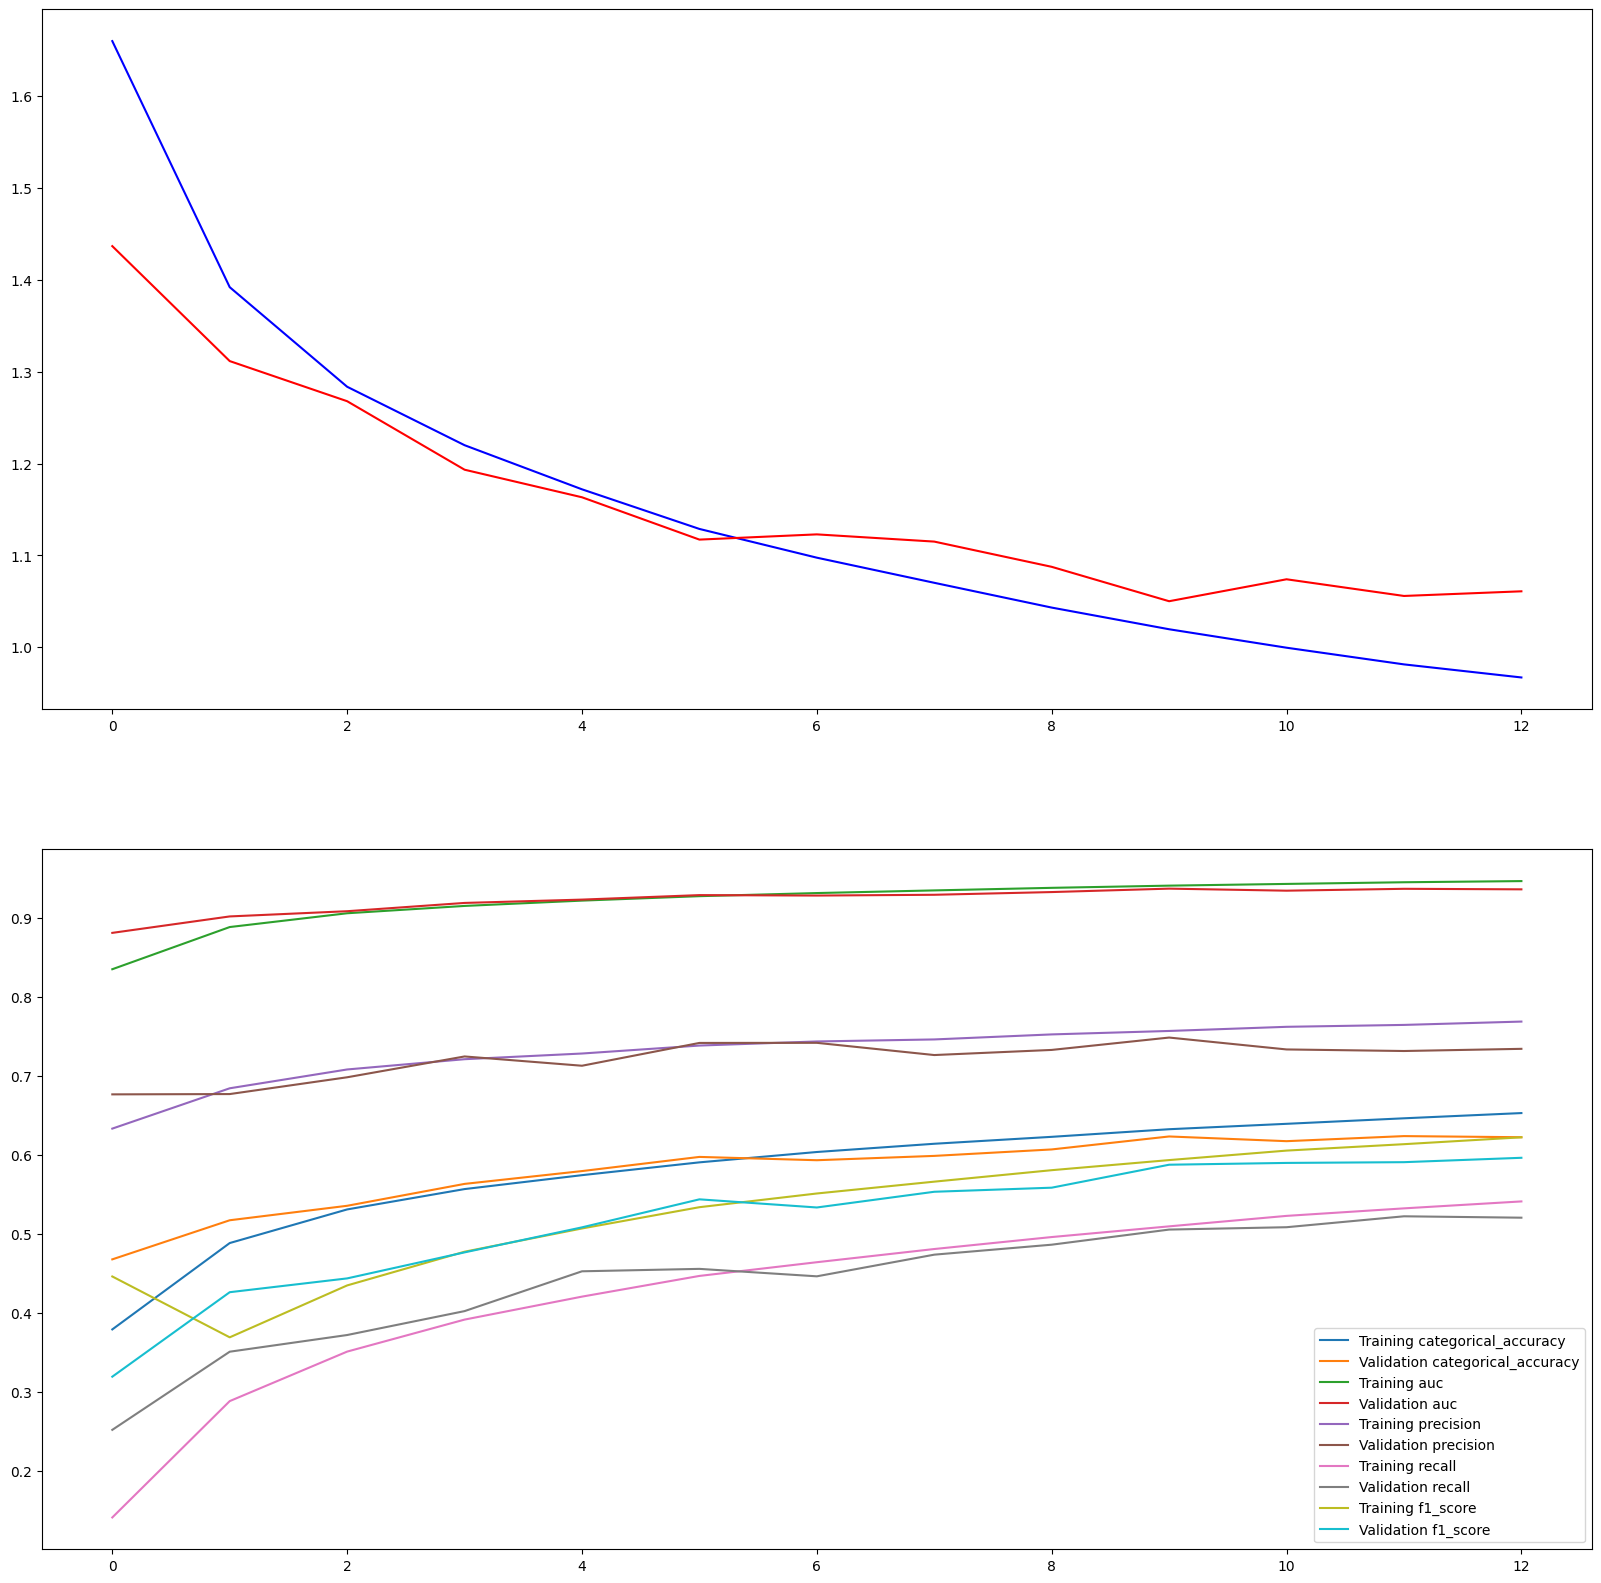

In [29]:
show_training_validation_loss_and_metrics(model32,metrics2)

In [30]:
model32.evaluate(test_it)

5625/5625 [==============================] - 43s 8ms/step - loss: 1.0698 - categorical_accuracy: 0.6197 - auc: 0.9351 - precision: 0.7328 - recall: 0.5183 - f1_score: 0.5944


[1.0697944164276123,
 0.6197444200515747,
 0.935143232345581,
 0.7327835559844971,
 0.518322229385376,
 0.5944252610206604]

5625/5625 [==============================] - 23s 4ms/step


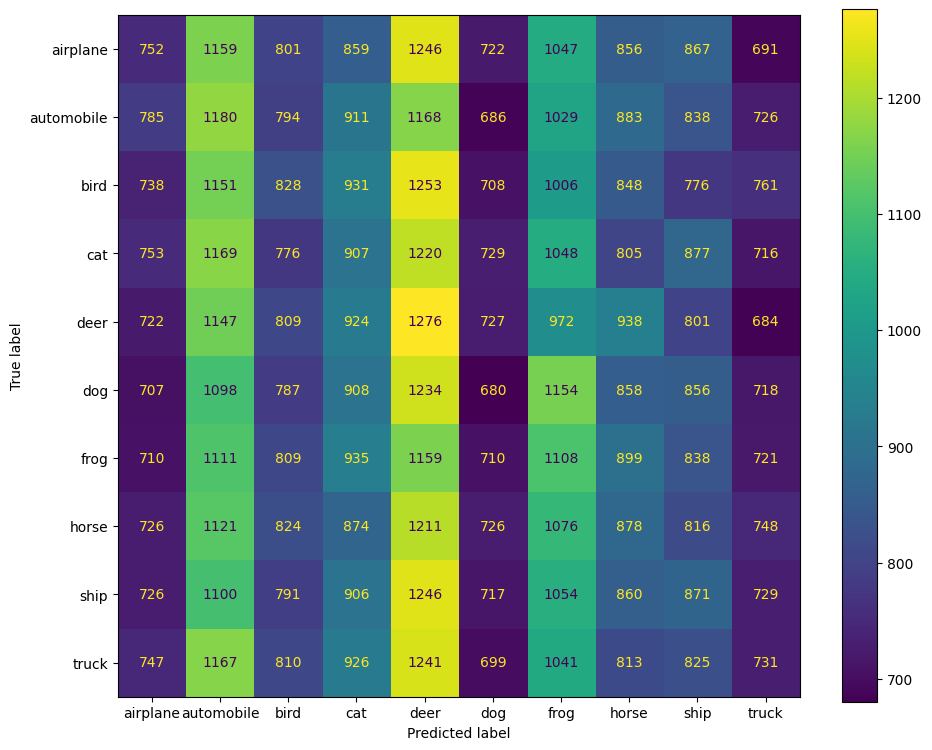

In [31]:
show_confusion_matrix(model32,test_ds,num_classes,class_names)

5625/5625 [==============================] - 23s 4ms/step


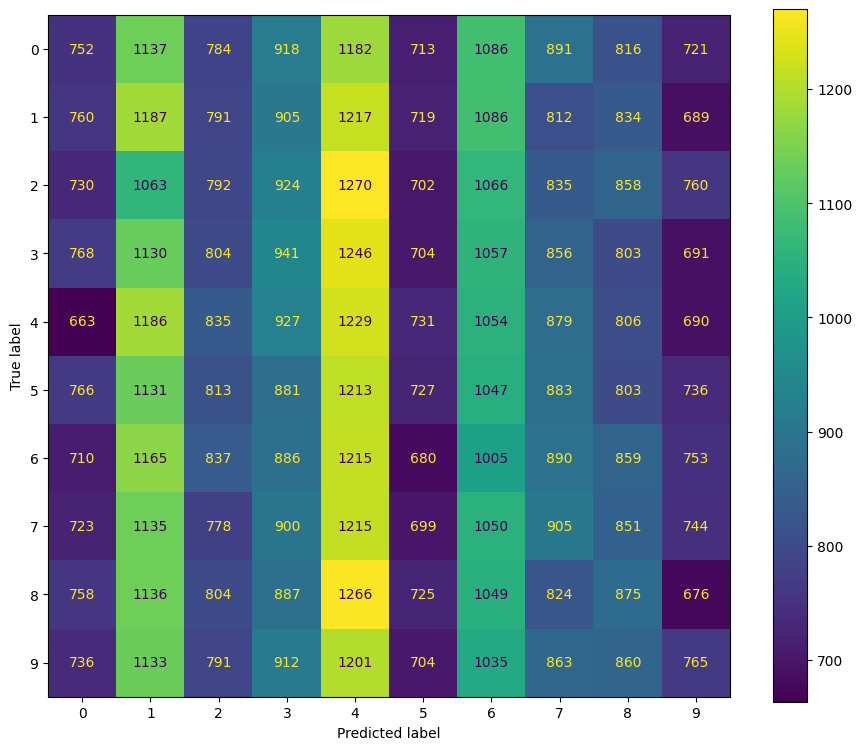

In [32]:
show_confusion_matrix_without_names(model32,test_ds,num_classes)

# Ziarno 7654

In [16]:
SEED = 7654

tf.random.set_seed(SEED)

# Architektura pierwszego modelu

In [127]:
model13 = create_model1(num_classes)

In [128]:
model13.compile( 
    loss=loss_func,
    metrics=metrics
)

In [129]:

model13.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_71 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization_12 (Ba  (None, 32, 32, 256)       1024      
 tchNormalization)                                               
                                                                 
 max_pooling2d_62 (MaxPooli  (None, 16, 16, 256)       0         
 ng2D)                                                           
                                                                 
 conv2d_72 (Conv2D)          (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization_13 (Ba  (None, 16, 16, 128)       512       
 tchNormalization)                                               
                                                     

In [130]:
history = model13.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs,
    callbacks = [callback] 
)

Epoch 1/20
5625/5625 [==============================] - 222s 39ms/step - loss: 1.5649 - categorical_accuracy: 0.4358 - auc: 0.8584 - precision: 0.6116 - recall: 0.2499 - f1_score: 0.4522 - val_loss: 1.2707 - val_categorical_accuracy: 0.5388 - val_auc: 0.9079 - val_precision: 0.7091 - val_recall: 0.3683 - val_f1_score: 0.4471
Epoch 2/20
5625/5625 [==============================] - 221s 39ms/step - loss: 1.2440 - categorical_accuracy: 0.5506 - auc: 0.9117 - precision: 0.7102 - recall: 0.3895 - f1_score: 0.4793 - val_loss: 1.2213 - val_categorical_accuracy: 0.5631 - val_auc: 0.9154 - val_precision: 0.7036 - val_recall: 0.4266 - val_f1_score: 0.4964
Epoch 3/20
5625/5625 [==============================] - 222s 39ms/step - loss: 1.1357 - categorical_accuracy: 0.5908 - auc: 0.9266 - precision: 0.7374 - recall: 0.4512 - f1_score: 0.5412 - val_loss: 1.3244 - val_categorical_accuracy: 0.5289 - val_auc: 0.8992 - val_precision: 0.6989 - val_recall: 0.3741 - val_f1_score: 0.4394
Epoch 4/20
5625/562

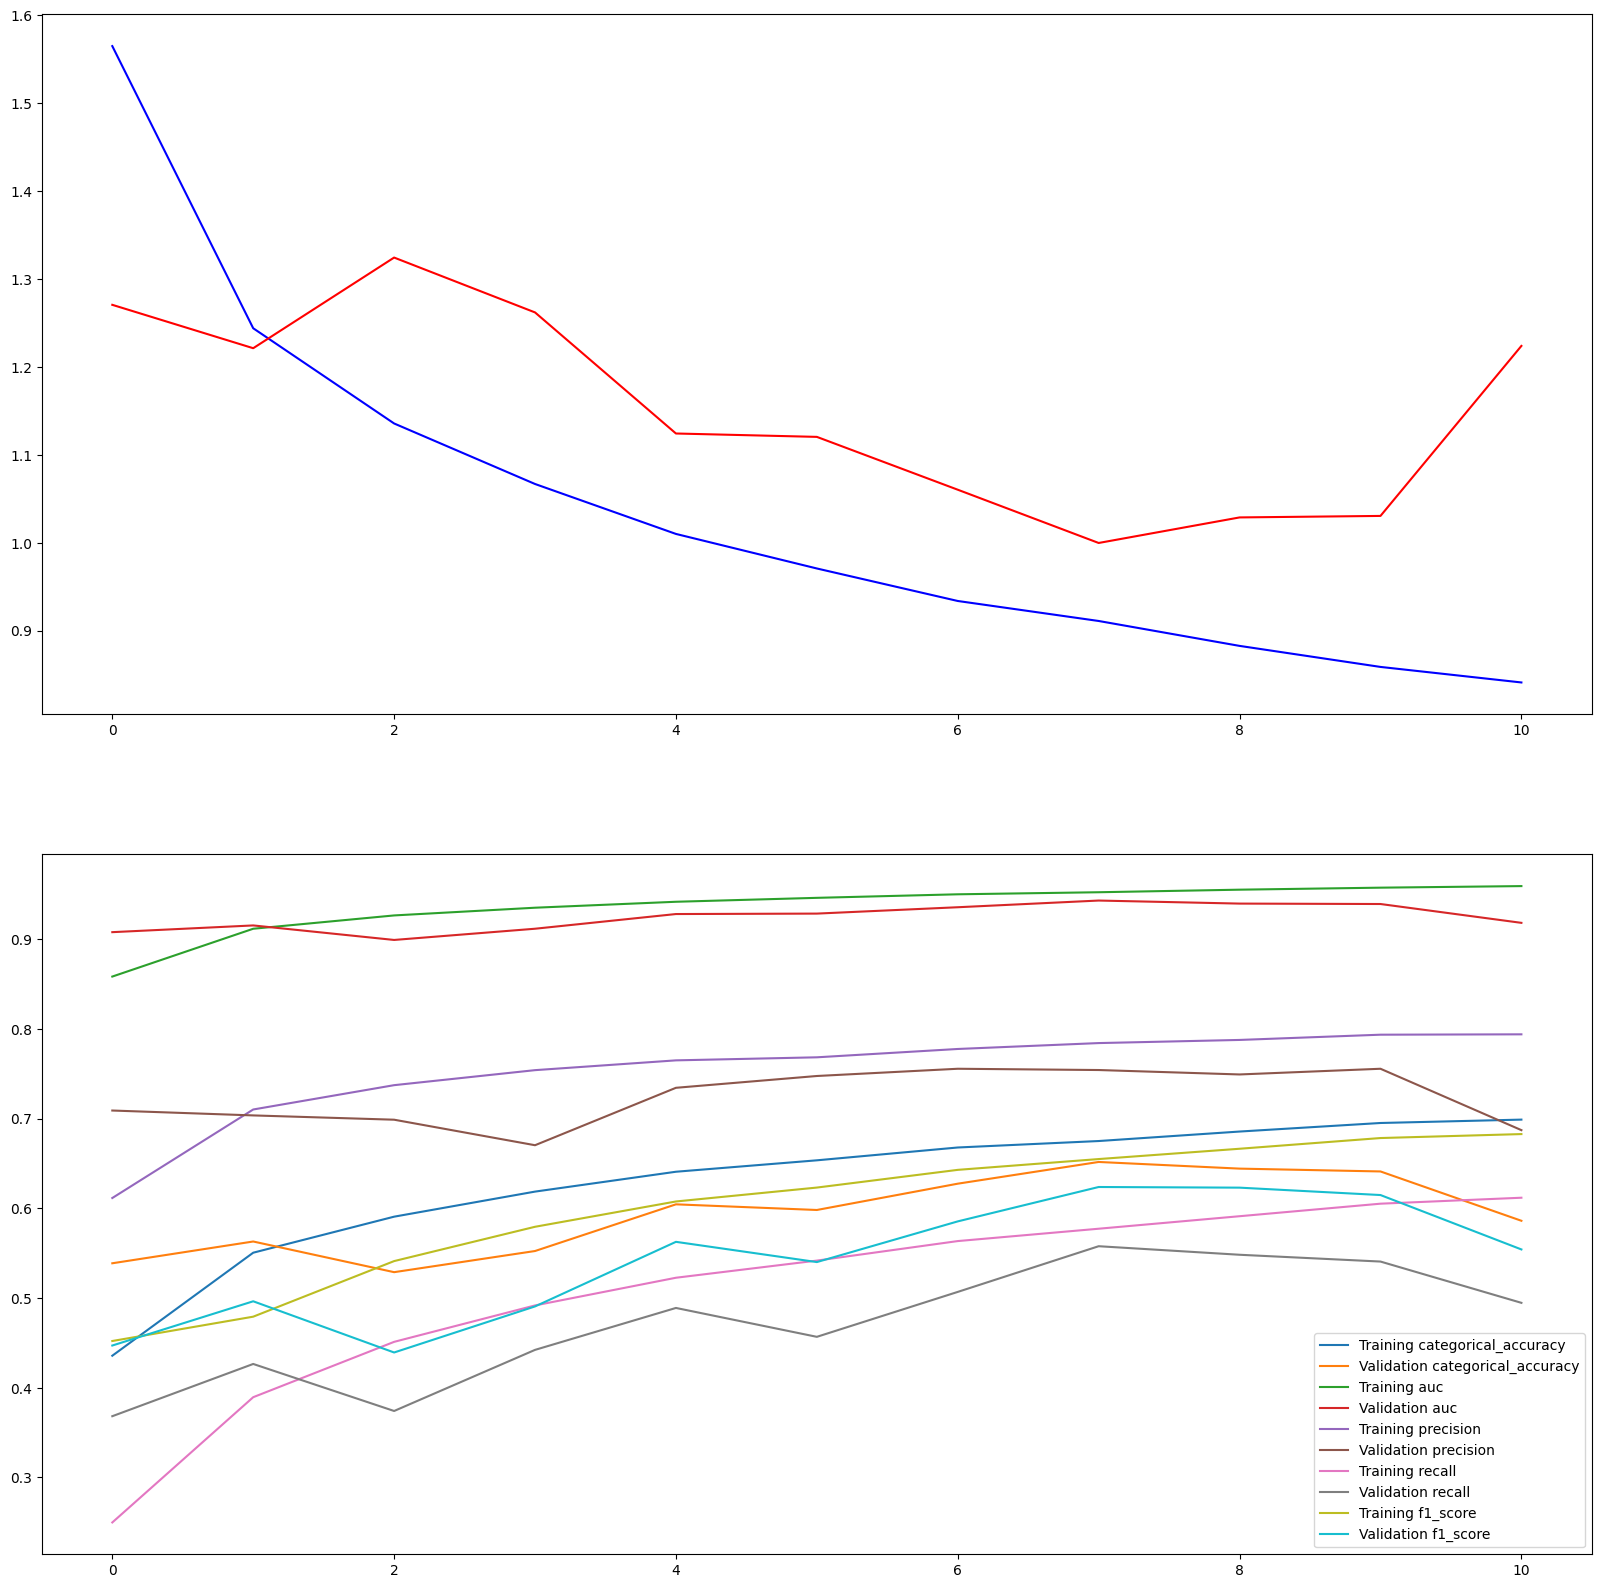

In [131]:
show_training_validation_loss_and_metrics(model13,metrics2)

In [132]:
model13.evaluate(test_it)

5625/5625 [==============================] - 73s 13ms/step - loss: 1.2364 - categorical_accuracy: 0.5841 - auc: 0.9167 - precision: 0.6851 - recall: 0.4922 - f1_score: 0.5523


[1.2363916635513306,
 0.5840666890144348,
 0.9167454242706299,
 0.6850872039794922,
 0.492166668176651,
 0.5522671341896057]

5625/5625 [==============================] - 32s 6ms/step


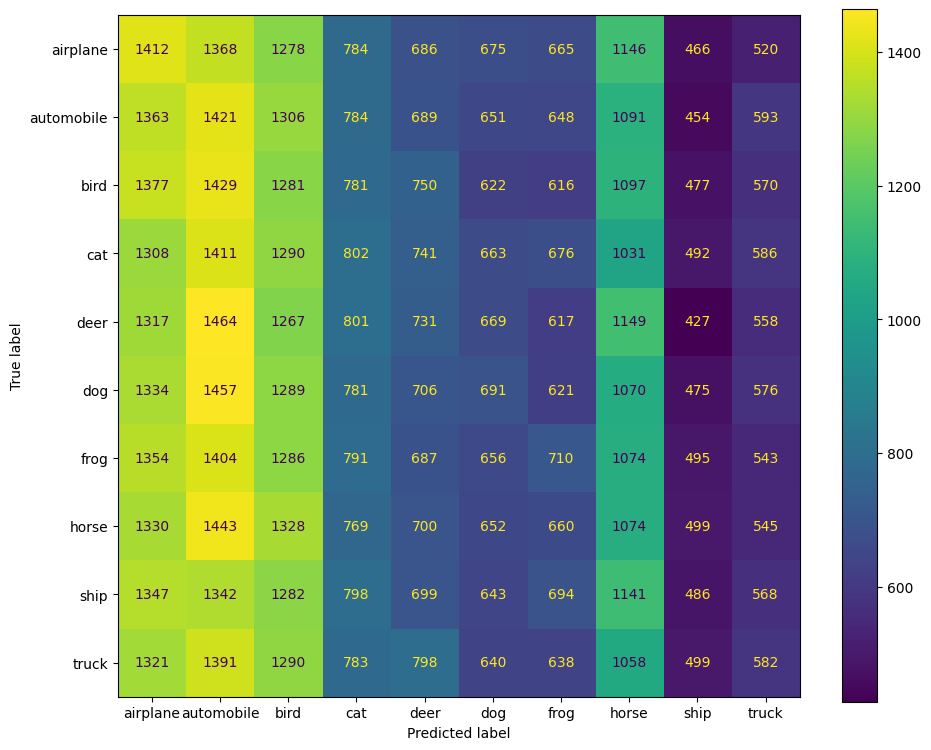

In [133]:
show_confusion_matrix(model13,test_ds,num_classes,class_names)

5625/5625 [==============================] - 32s 6ms/step


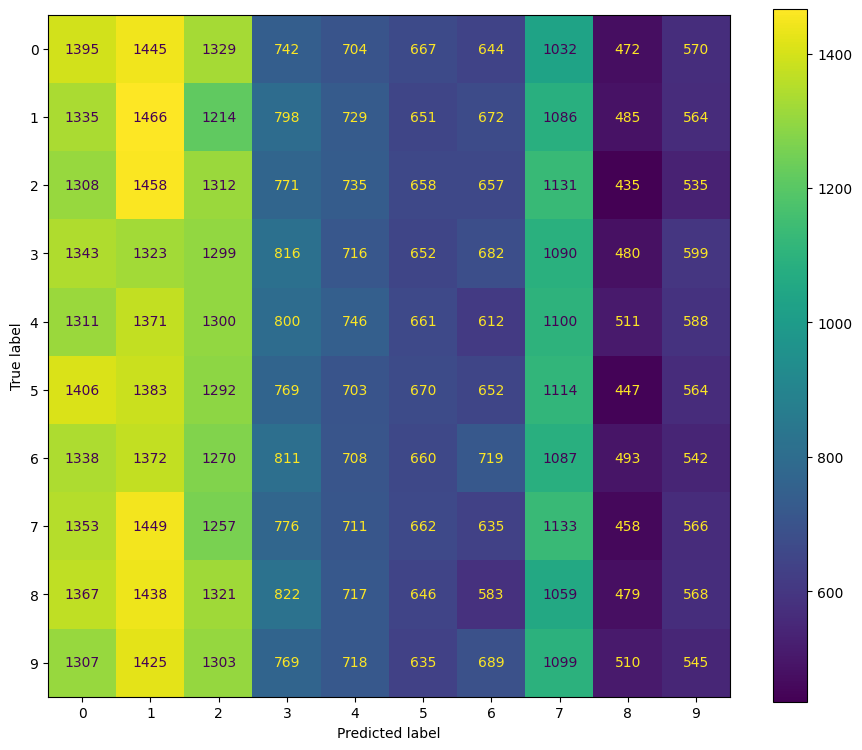

In [134]:
show_confusion_matrix_without_names(model13,test_ds,num_classes)

# Architektura drugiego modelu

In [135]:
model23 = create_model2(num_classes)

In [136]:
model23.compile( 
    loss=loss_func,
    metrics=metrics
)

In [137]:
model23.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 32, 32, 75)        2100      
                                                                 
 layer_normalization_62 (La  (None, 32, 32, 75)        150       
 yerNormalization)                                               
                                                                 
 average_pooling2d_9 (Avera  (None, 16, 16, 75)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_76 (Conv2D)          (None, 16, 16, 50)        33800     
                                                                 
 layer_normalization_63 (La  (None, 16, 16, 50)        100       
 yerNormalization)                                               
                                                     

In [138]:
history = model23.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20


5625/5625 [==============================] - 239s 42ms/step - loss: 1.7433 - categorical_accuracy: 0.3676 - auc: 0.8166 - precision: 0.6106 - recall: 0.1420 - f1_score: 0.4106 - val_loss: 1.4604 - val_categorical_accuracy: 0.4657 - val_auc: 0.8767 - val_precision: 0.6753 - val_recall: 0.2433 - val_f1_score: 0.3230
Epoch 2/20
5625/5625 [==============================] - 239s 42ms/step - loss: 1.4045 - categorical_accuracy: 0.4894 - auc: 0.8862 - precision: 0.6865 - recall: 0.2881 - f1_score: 0.3750 - val_loss: 1.3667 - val_categorical_accuracy: 0.4938 - val_auc: 0.8929 - val_precision: 0.6721 - val_recall: 0.3210 - val_f1_score: 0.3890
Epoch 3/20
5625/5625 [==============================] - 238s 42ms/step - loss: 1.3064 - categorical_accuracy: 0.5268 - auc: 0.9021 - precision: 0.7102 - recall: 0.3450 - f1_score: 0.4351 - val_loss: 1.2874 - val_categorical_accuracy: 0.5370 - val_auc: 0.9051 - val_precision: 0.7251 - val_recall: 0.3485 - val_f1_score: 0.4404
Epoch 4/20
5625/5625 [========

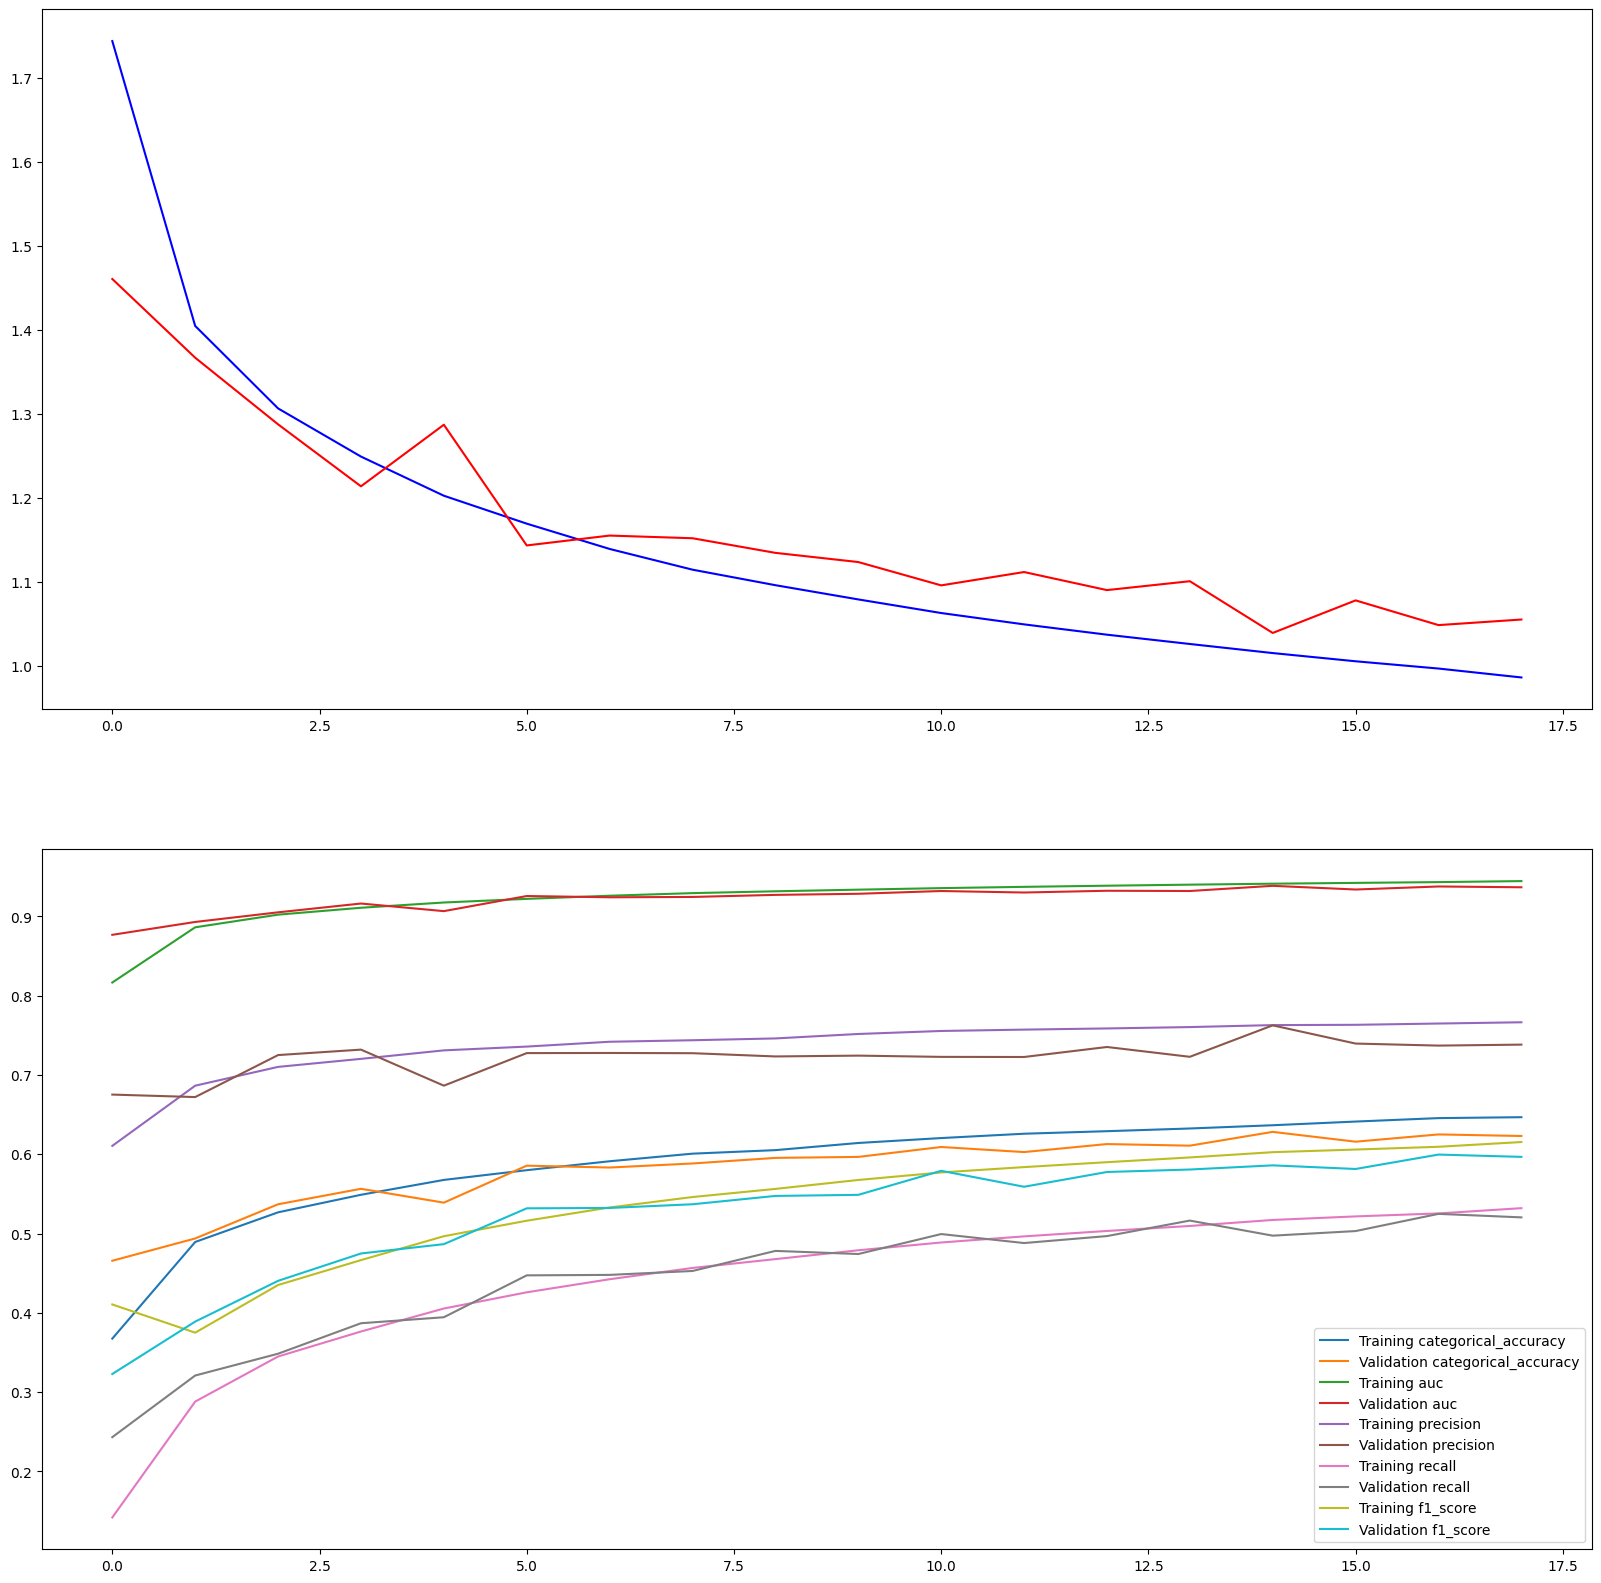

In [139]:
show_training_validation_loss_and_metrics(model23,metrics2)

In [140]:
model23.evaluate(test_it)

5625/5625 [==============================] - 102s 18ms/step - loss: 1.0670 - categorical_accuracy: 0.6217 - auc: 0.9355 - precision: 0.7374 - recall: 0.5193 - f1_score: 0.5956


[1.0669972896575928,
 0.6216999888420105,
 0.9354977607727051,
 0.7373859882354736,
 0.5192999839782715,
 0.5955817699432373]

5625/5625 [==============================] - 46s 8ms/step


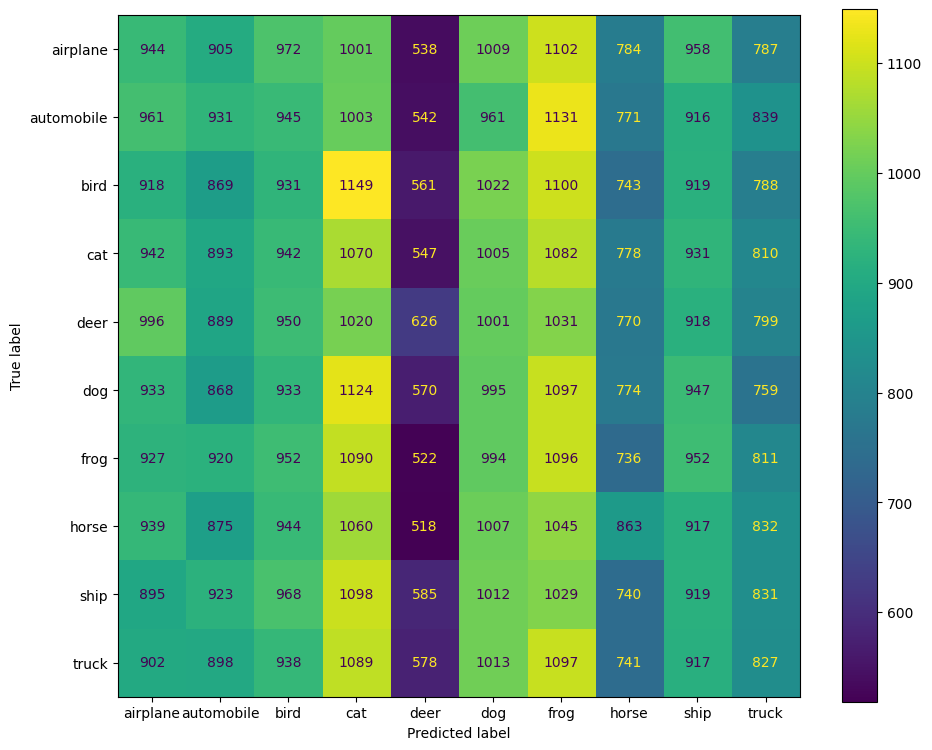

In [141]:
show_confusion_matrix(model23,test_ds,num_classes,class_names)

5625/5625 [==============================] - 45s 8ms/step


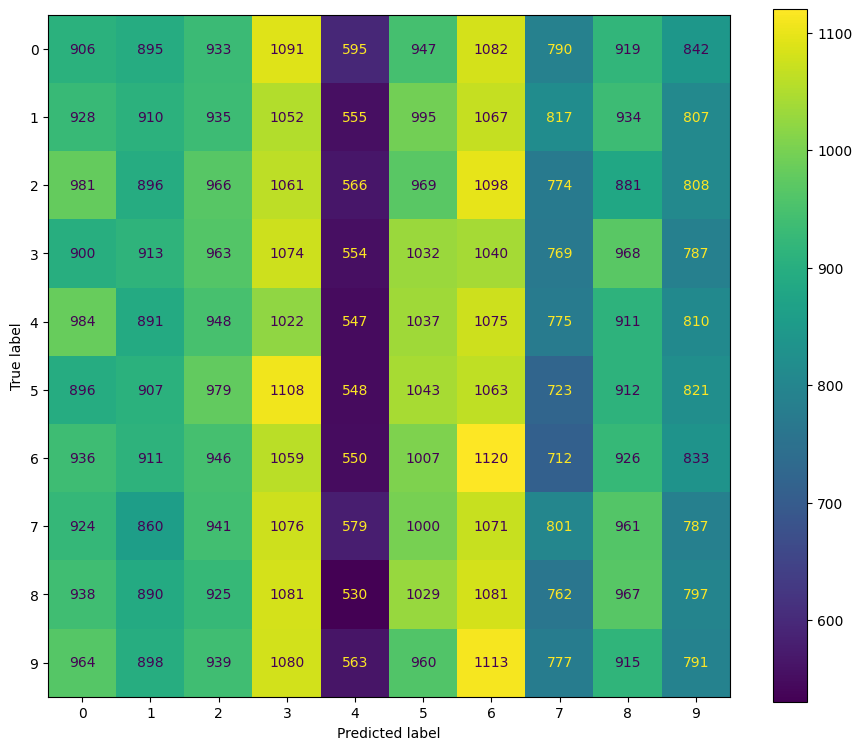

In [142]:
show_confusion_matrix_without_names(model23,test_ds,num_classes)

# Architektura trzeciego modelu

In [17]:
model33 = create_model3(num_classes)

model33.compile( 
    optimizer=optimiser,
    loss=loss_func,
    metrics=metrics
)

In [18]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model33.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 148s 25ms/step - loss: 1.6767 - categorical_accuracy: 0.3669 - auc: 0.8308 - precision: 0.6198 - recall: 0.1305 - f1_score: 0.1937 - val_loss: 1.4534 - val_categorical_accuracy: 0.4529 - val_auc: 0.8784 - val_precision: 0.6574 - val_recall: 0.2287 - val_f1_score: 0.2971
Epoch 2/20
5625/5625 [==============================] - 104s 18ms/step - loss: 1.4024 - categorical_accuracy: 0.4804 - auc: 0.8870 - precision: 0.6793 - recall: 0.2764 - f1_score: 0.3541 - val_loss: 1.2967 - val_categorical_accuracy: 0.5196 - val_auc: 0.9042 - val_precision: 0.7057 - val_recall: 0.3321 - val_f1_score: 0.4155
Epoch 3/20
5625/5625 [==============================] - 101s 18ms/step - loss: 1.2883 - categorical_accuracy: 0.5292 - auc: 0.9052 - precision: 0.7081 - recall: 0.3481 - f1_score: 0.4322 - val_loss: 1.2143 - val_categorical_accuracy: 0.5545 - val_auc: 0.9161 - val_precision: 0.7232 - val_recall: 0.3917 - val_f1_score: 0.4679
Epoch 4/20
5625/562

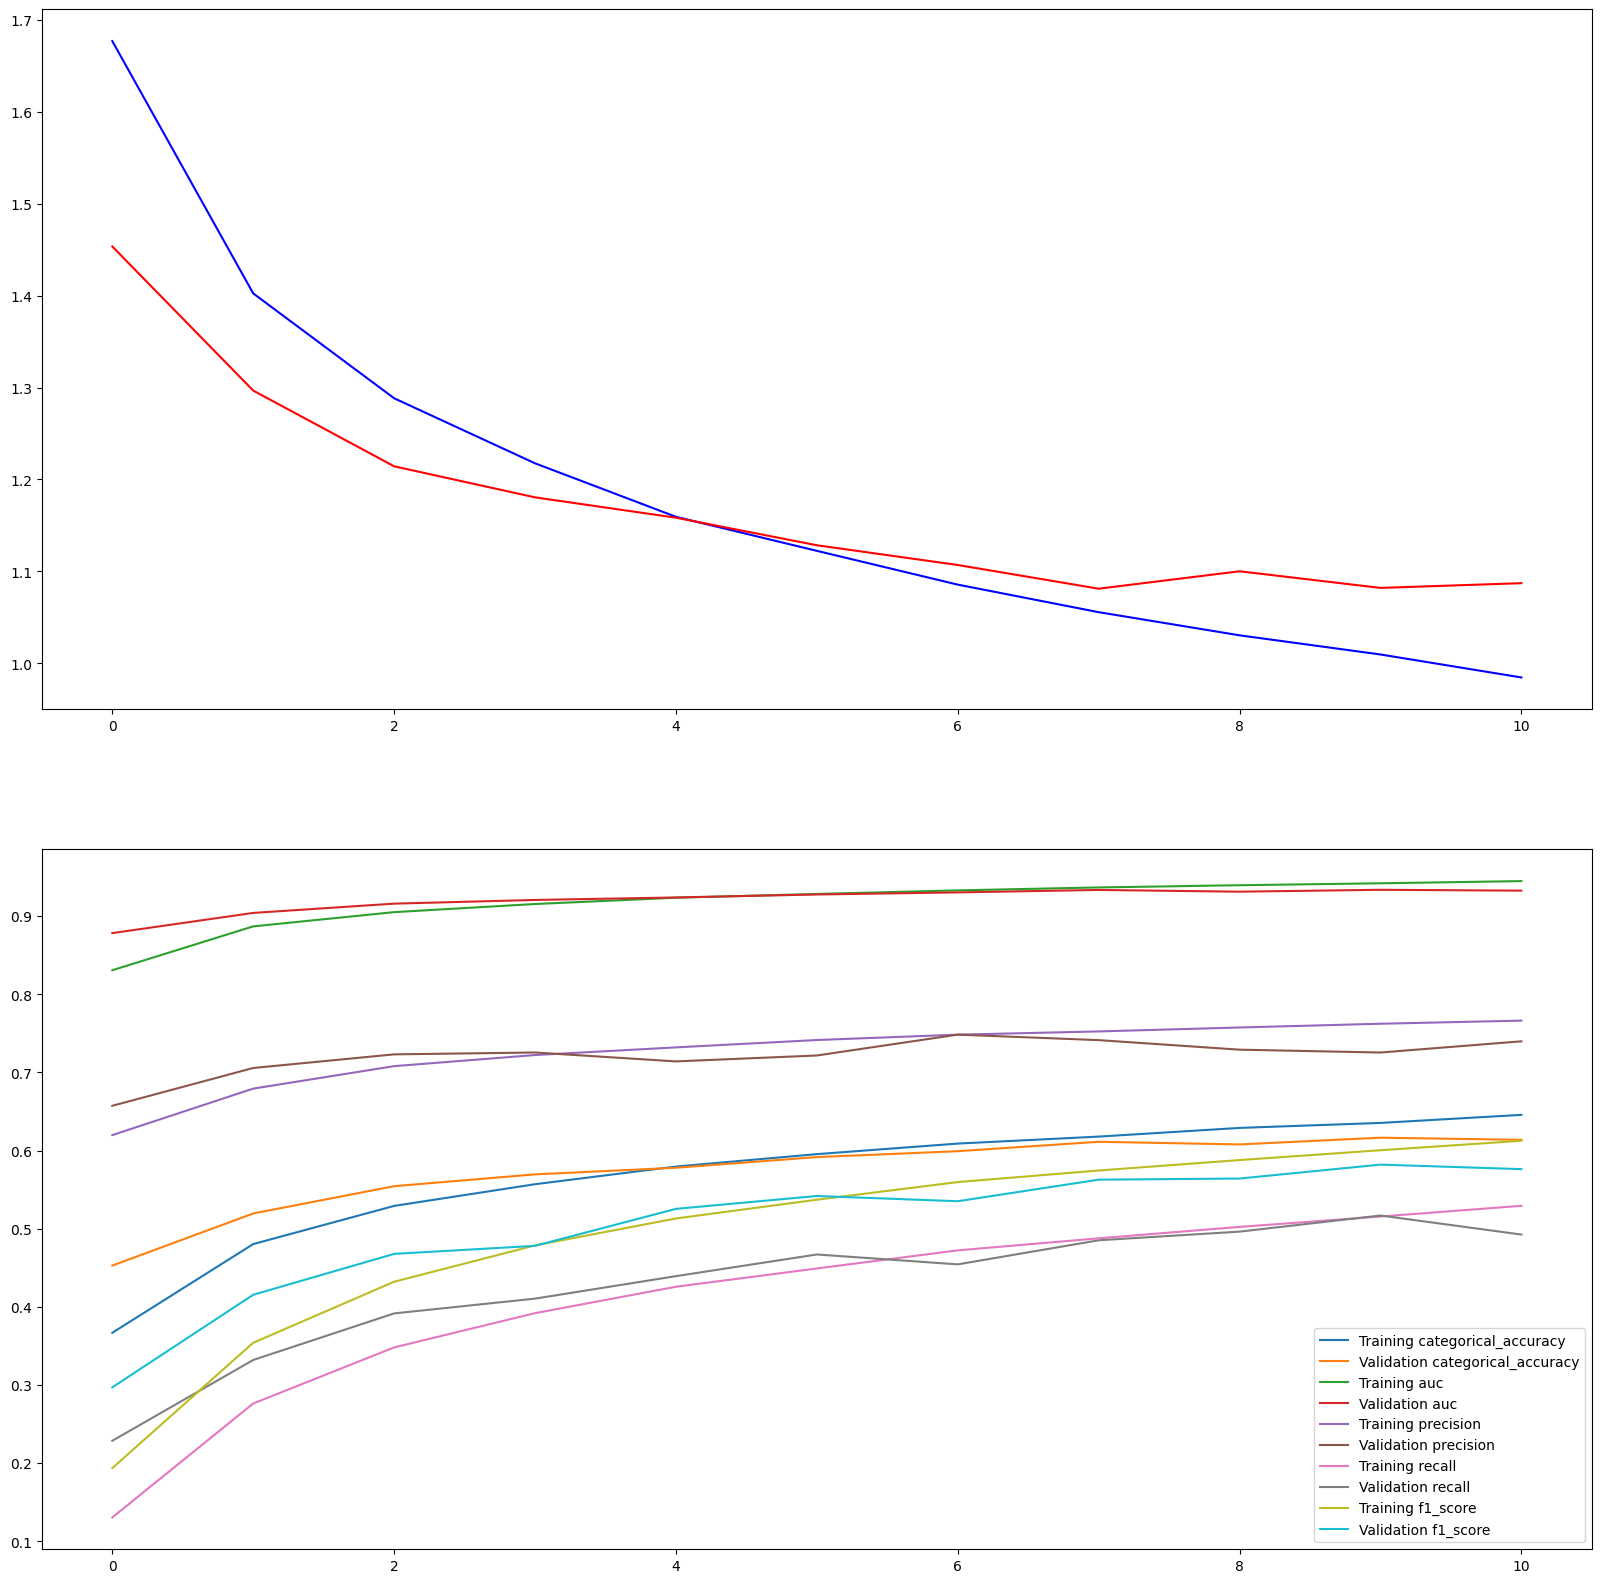

In [19]:
show_training_validation_loss_and_metrics(model33,metrics2)

In [20]:
model33.evaluate(test_it)

5625/5625 [==============================] - 61s 11ms/step - loss: 1.0951 - categorical_accuracy: 0.6122 - auc: 0.9317 - precision: 0.7404 - recall: 0.4922 - f1_score: 0.5761


[1.0950900316238403,
 0.6121888756752014,
 0.9317403435707092,
 0.7403854131698608,
 0.49219998717308044,
 0.5760922431945801]

5625/5625 [==============================] - 22s 4ms/step


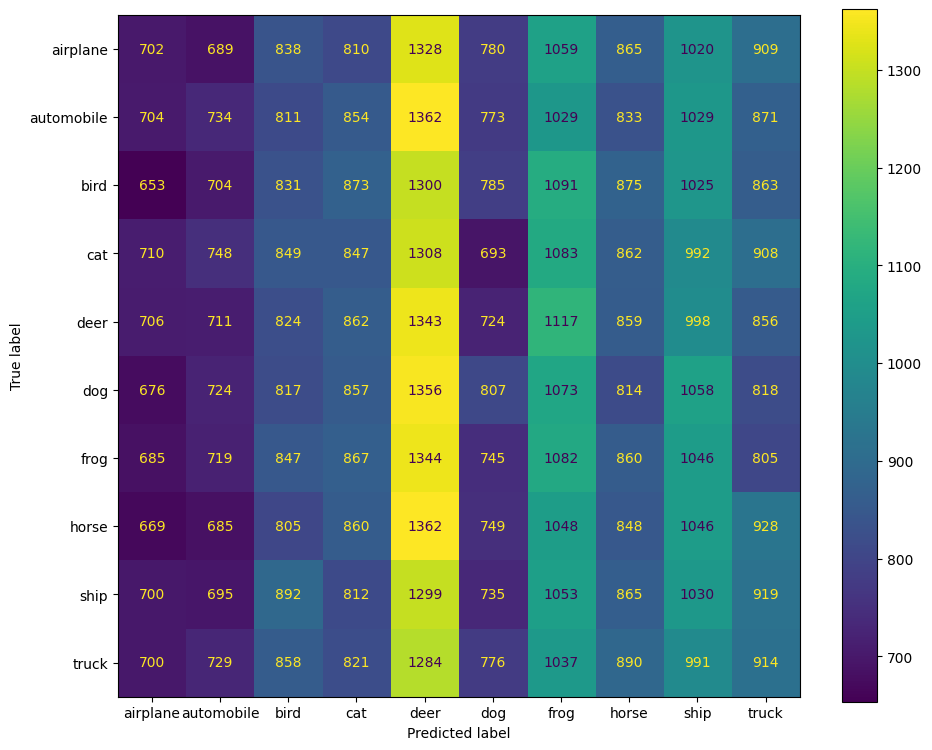

In [21]:
show_confusion_matrix(model33,test_ds,num_classes,class_names)

5625/5625 [==============================] - 22s 4ms/step


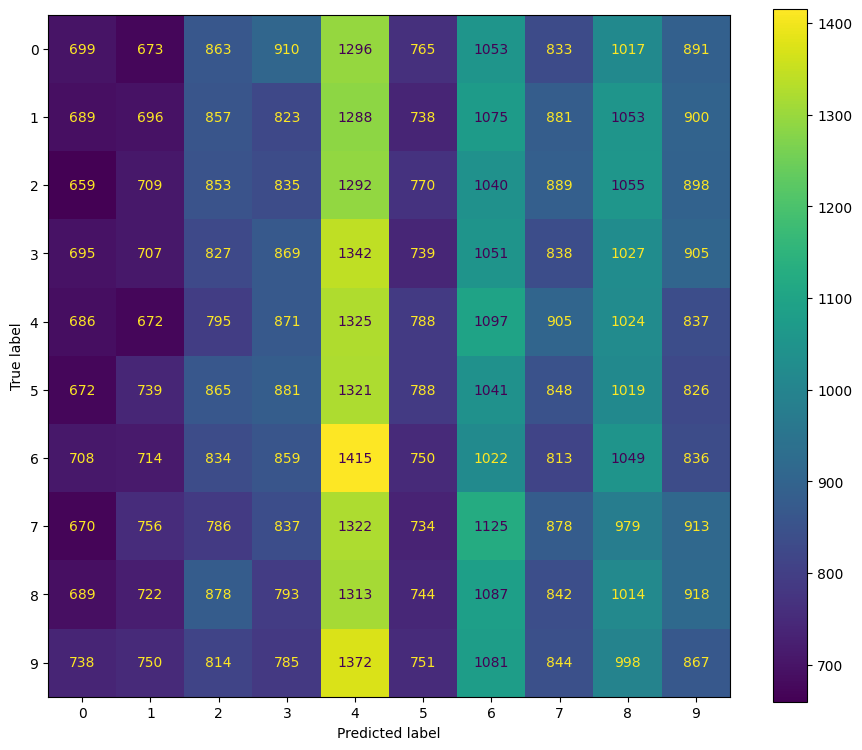

In [22]:
show_confusion_matrix_without_names(model33,test_ds,num_classes)

# Ziarno 313

In [23]:
SEED = 313
tf.random.set_seed(SEED)

# Architektura pierwszego modelu

In [146]:
model14 = create_model1(num_classes)

In [147]:
model14.compile( 
    loss=loss_func,
    metrics=metrics
)

In [148]:
model14.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_83 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization_16 (Ba  (None, 32, 32, 256)       1024      
 tchNormalization)                                               
                                                                 
 max_pooling2d_71 (MaxPooli  (None, 16, 16, 256)       0         
 ng2D)                                                           
                                                                 
 conv2d_84 (Conv2D)          (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization_17 (Ba  (None, 16, 16, 128)       512       
 tchNormalization)                                               
                                                     

In [149]:
history = model14.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs,
    callbacks = [callback] 
)

Epoch 1/20
5625/5625 [==============================] - 226s 40ms/step - loss: 1.5685 - categorical_accuracy: 0.4342 - auc: 0.8576 - precision: 0.6120 - recall: 0.2483 - f1_score: 0.4767 - val_loss: 1.3078 - val_categorical_accuracy: 0.5254 - val_auc: 0.9029 - val_precision: 0.7053 - val_recall: 0.3369 - val_f1_score: 0.4005
Epoch 2/20
5625/5625 [==============================] - 224s 40ms/step - loss: 1.2455 - categorical_accuracy: 0.5503 - auc: 0.9116 - precision: 0.7099 - recall: 0.3915 - f1_score: 0.4812 - val_loss: 1.3863 - val_categorical_accuracy: 0.4984 - val_auc: 0.8893 - val_precision: 0.6900 - val_recall: 0.3206 - val_f1_score: 0.4098
Epoch 3/20
5625/5625 [==============================] - 226s 40ms/step - loss: 1.1390 - categorical_accuracy: 0.5911 - auc: 0.9261 - precision: 0.7347 - recall: 0.4518 - f1_score: 0.5412 - val_loss: 1.3897 - val_categorical_accuracy: 0.5033 - val_auc: 0.8902 - val_precision: 0.6504 - val_recall: 0.3388 - val_f1_score: 0.3997
Epoch 4/20
5625/562

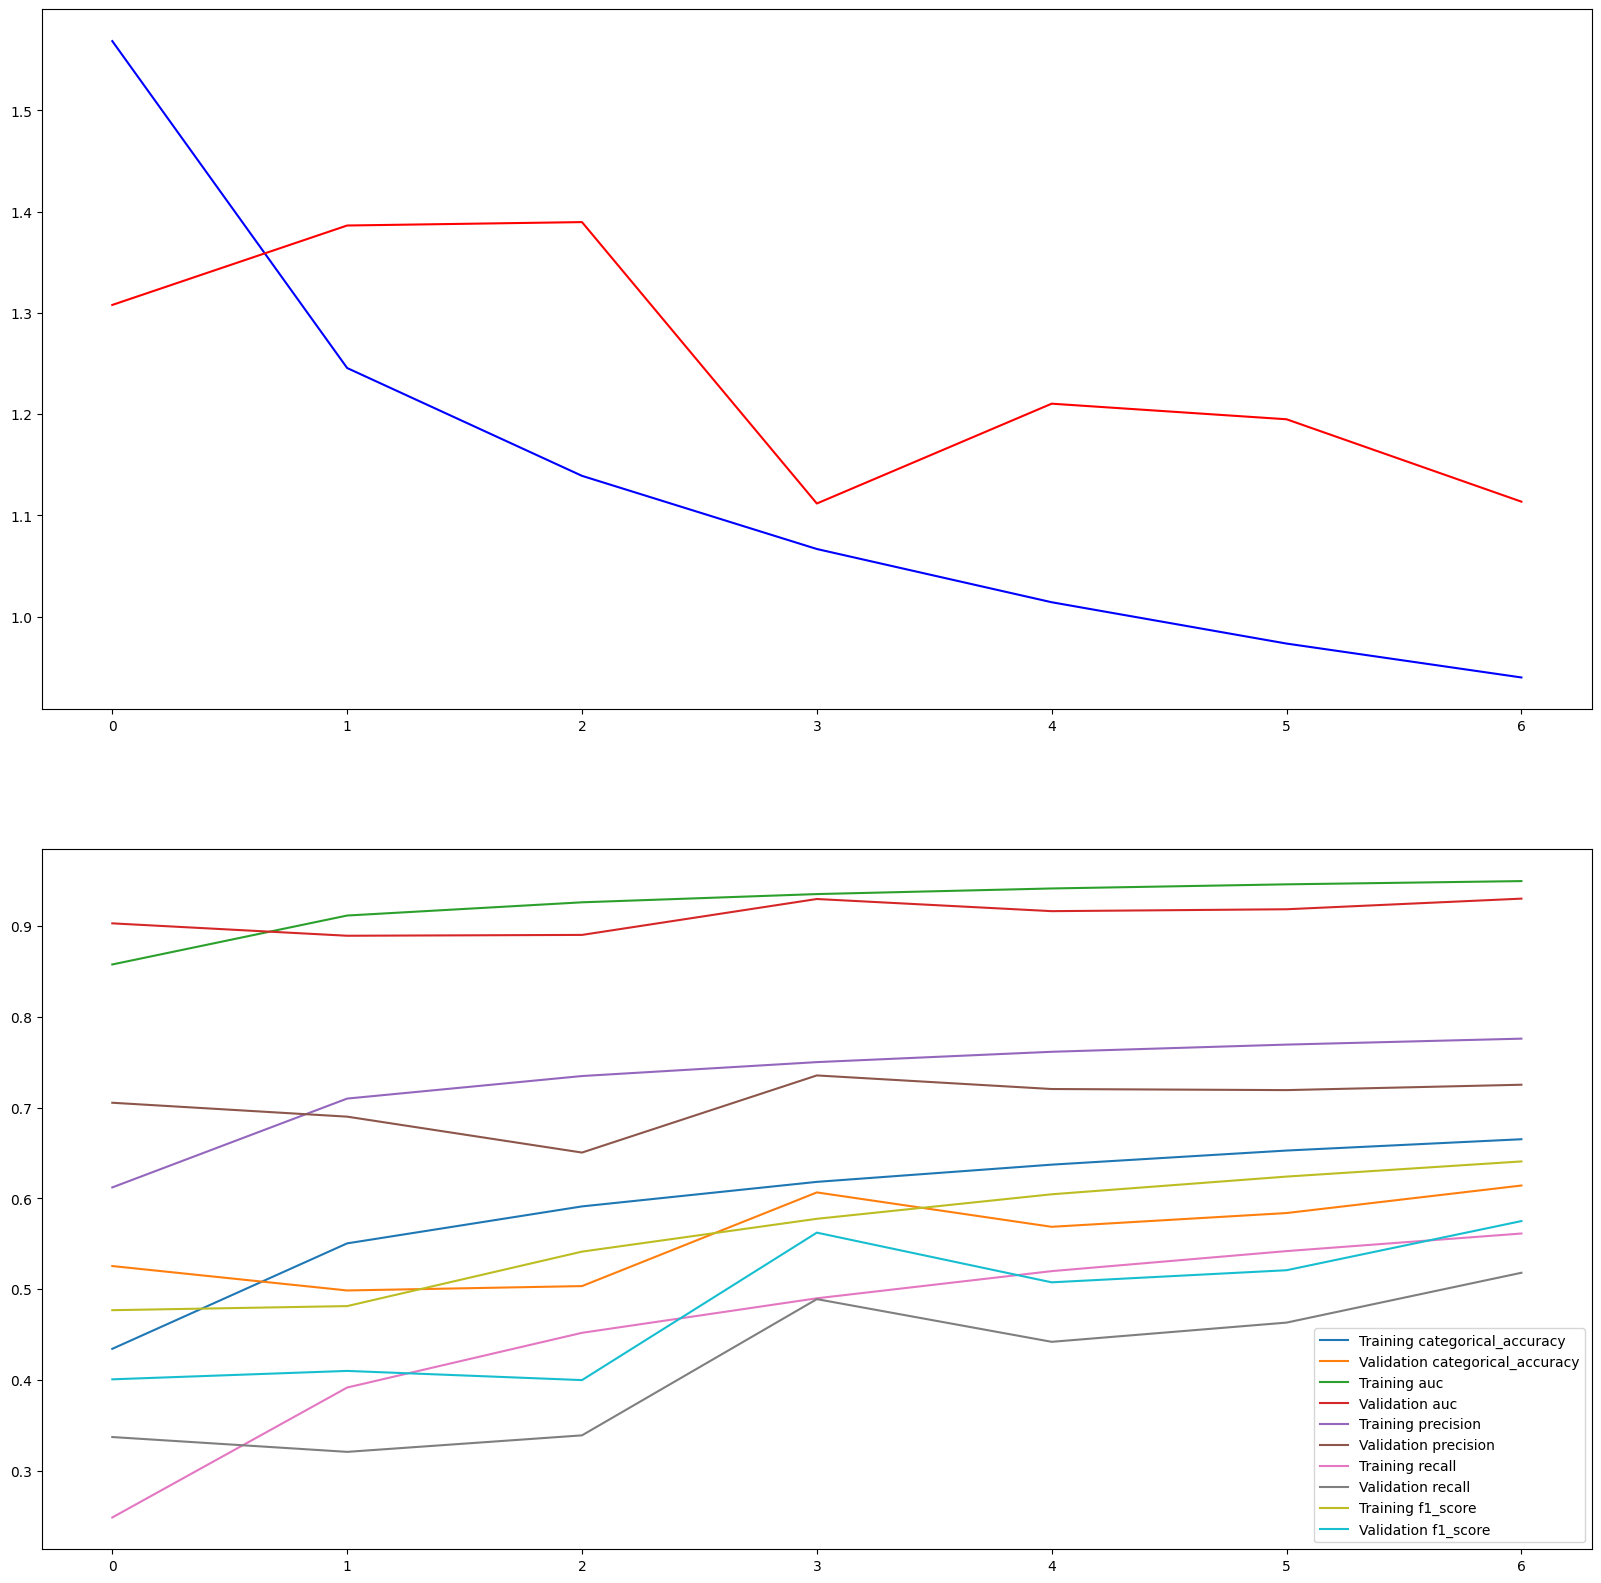

In [150]:
show_training_validation_loss_and_metrics(model14,metrics2)

In [151]:
model14.evaluate(test_it)

5625/5625 [==============================] - 75s 13ms/step - loss: 1.1215 - categorical_accuracy: 0.6141 - auc: 0.9290 - precision: 0.7252 - recall: 0.5167 - f1_score: 0.5748


[1.1214765310287476,
 0.6140999794006348,
 0.9290027618408203,
 0.725232720375061,
 0.5167444348335266,
 0.5748385190963745]

5625/5625 [==============================] - 32s 6ms/step


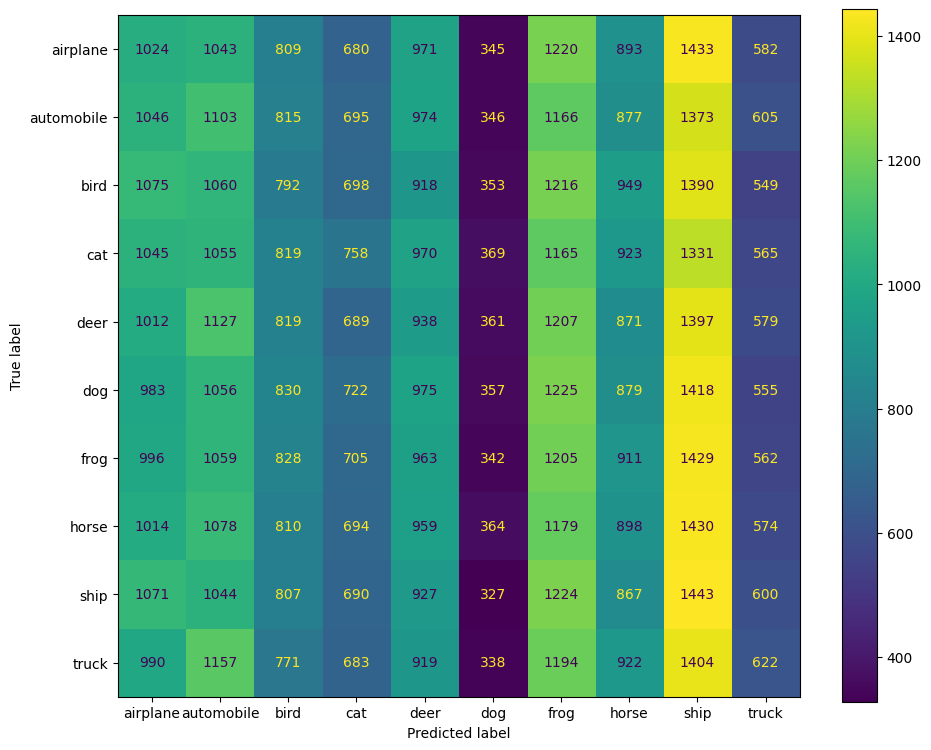

In [152]:
show_confusion_matrix(model14,test_ds,num_classes,class_names)

5625/5625 [==============================] - 32s 6ms/step


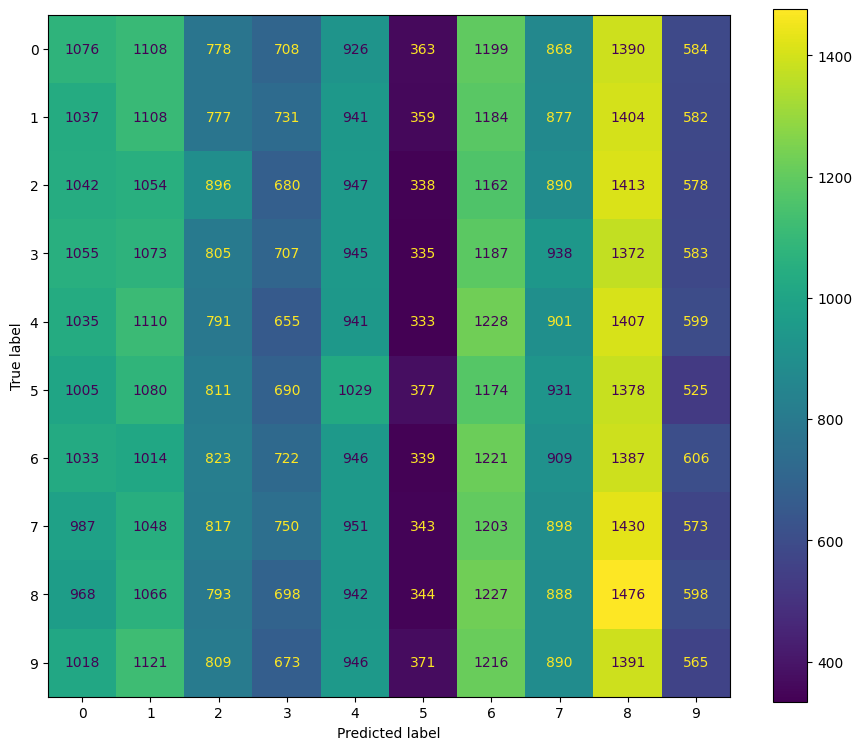

In [153]:
show_confusion_matrix_without_names(model14,test_ds,num_classes)

# Architektura drugiego modelu

In [154]:
model24 = create_model2(num_classes)

In [155]:
model24.compile( 
    loss=loss_func,
    metrics=metrics
)

In [156]:
model24.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_87 (Conv2D)          (None, 32, 32, 75)        2100      
                                                                 
 layer_normalization_71 (La  (None, 32, 32, 75)        150       
 yerNormalization)                                               
                                                                 
 average_pooling2d_12 (Aver  (None, 16, 16, 75)        0         
 agePooling2D)                                                   
                                                                 
 conv2d_88 (Conv2D)          (None, 16, 16, 50)        33800     
                                                                 
 layer_normalization_72 (La  (None, 16, 16, 50)        100       
 yerNormalization)                                               
                                                     

In [157]:
history = model24.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20


5625/5625 [==============================] - 245s 43ms/step - loss: 1.7150 - categorical_accuracy: 0.3764 - auc: 0.8241 - precision: 0.6105 - recall: 0.1544 - f1_score: 0.4286 - val_loss: 1.4549 - val_categorical_accuracy: 0.4651 - val_auc: 0.8782 - val_precision: 0.6863 - val_recall: 0.2266 - val_f1_score: 0.2940
Epoch 2/20
5625/5625 [==============================] - 244s 43ms/step - loss: 1.4130 - categorical_accuracy: 0.4875 - auc: 0.8848 - precision: 0.6862 - recall: 0.2840 - f1_score: 0.3714 - val_loss: 1.3416 - val_categorical_accuracy: 0.5145 - val_auc: 0.8966 - val_precision: 0.7096 - val_recall: 0.3196 - val_f1_score: 0.3885
Epoch 3/20
5625/5625 [==============================] - 242s 43ms/step - loss: 1.3209 - categorical_accuracy: 0.5238 - auc: 0.8999 - precision: 0.7063 - recall: 0.3387 - f1_score: 0.4300 - val_loss: 1.2783 - val_categorical_accuracy: 0.5315 - val_auc: 0.9066 - val_precision: 0.7232 - val_recall: 0.3480 - val_f1_score: 0.4342
Epoch 4/20
5625/5625 [========

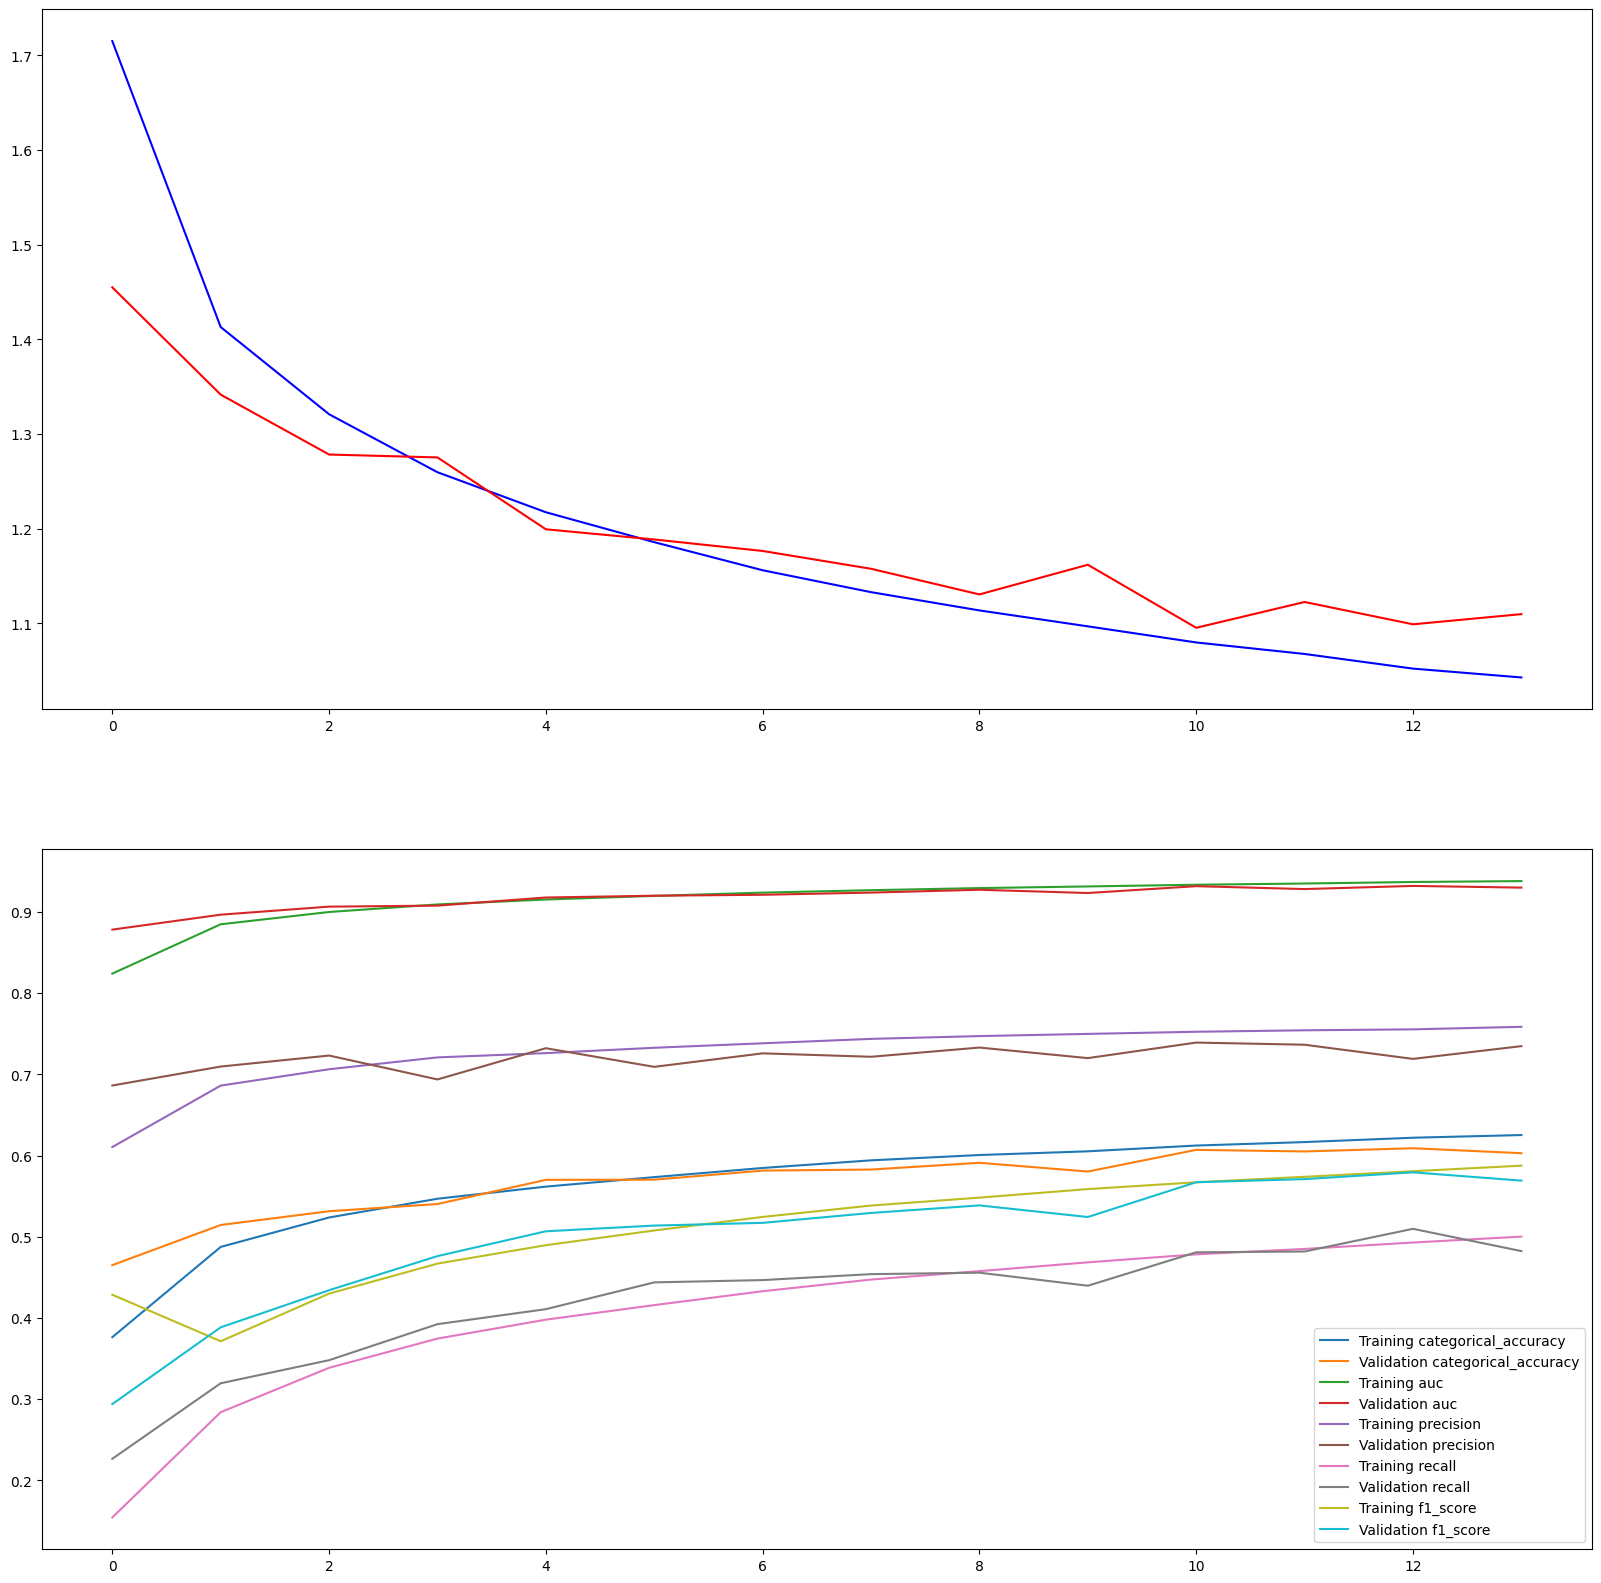

In [158]:
show_training_validation_loss_and_metrics(model24,metrics2)

In [159]:
model24.evaluate(test_it)

5625/5625 [==============================] - 100s 18ms/step - loss: 1.1182 - categorical_accuracy: 0.6005 - auc: 0.9290 - precision: 0.7329 - recall: 0.4800 - f1_score: 0.5667


[1.1182146072387695,
 0.6005333065986633,
 0.928987979888916,
 0.7329397201538086,
 0.4799777865409851,
 0.566653847694397]

5625/5625 [==============================] - 44s 8ms/step


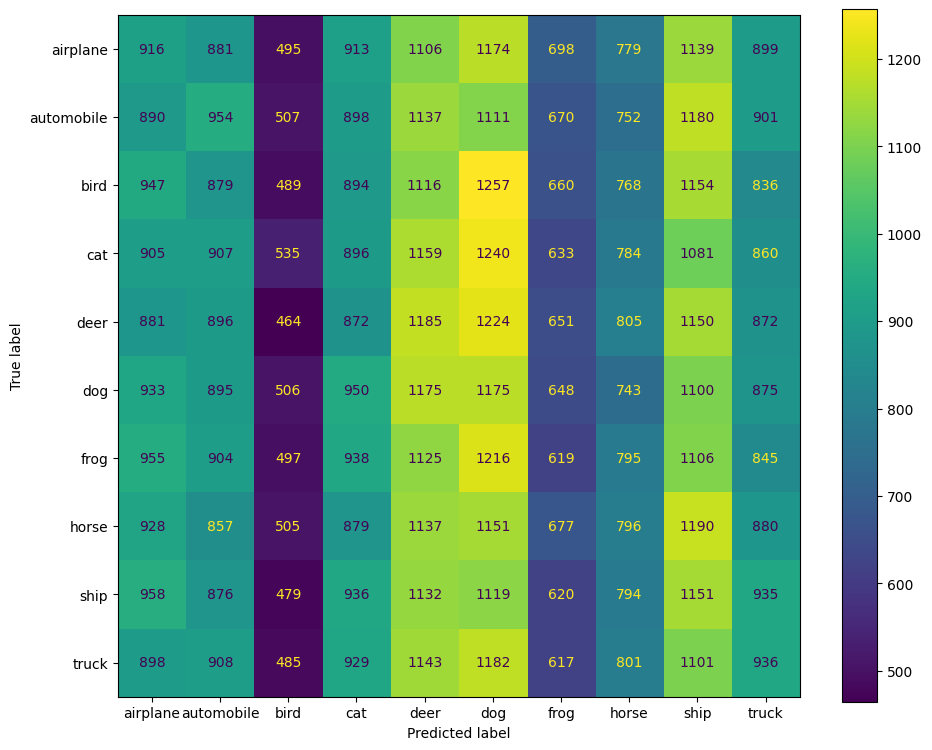

In [160]:
show_confusion_matrix(model24,test_ds,num_classes,class_names)

5625/5625 [==============================] - 44s 8ms/step


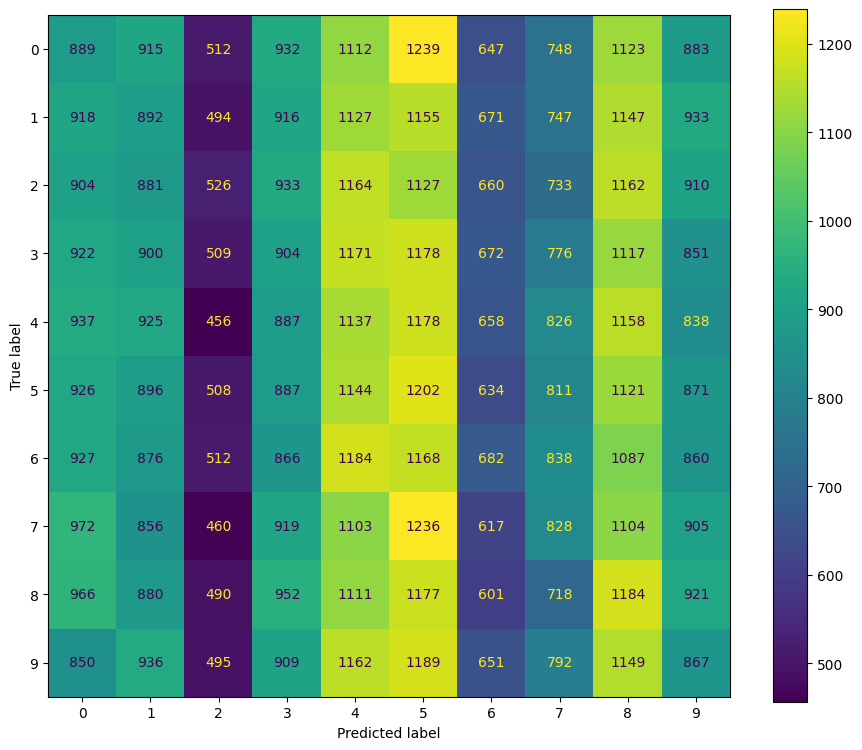

In [161]:
show_confusion_matrix_without_names(model24,test_ds,num_classes)

# Architektura trzeciego modelu

In [24]:
model34 = create_model3(num_classes)

model34.compile( 
    optimizer=optimiser,
    loss=loss_func,
    metrics=metrics
)

In [25]:
history = model34.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 105s 19ms/step - loss: 1.6654 - categorical_accuracy: 0.3742 - auc: 0.8338 - precision: 0.6287 - recall: 0.1356 - f1_score: 0.4200 - val_loss: 1.4244 - val_categorical_accuracy: 0.4733 - val_auc: 0.8833 - val_precision: 0.6998 - val_recall: 0.2442 - val_f1_score: 0.3222
Epoch 2/20
5625/5625 [==============================] - 102s 18ms/step - loss: 1.3943 - categorical_accuracy: 0.4836 - auc: 0.8883 - precision: 0.6834 - recall: 0.2834 - f1_score: 0.3628 - val_loss: 1.3196 - val_categorical_accuracy: 0.5162 - val_auc: 0.9004 - val_precision: 0.6972 - val_recall: 0.3285 - val_f1_score: 0.3999
Epoch 3/20
5625/5625 [==============================] - 102s 18ms/step - loss: 1.2850 - categorical_accuracy: 0.5282 - auc: 0.9058 - precision: 0.7041 - recall: 0.3479 - f1_score: 0.4314 - val_loss: 1.2254 - val_categorical_accuracy: 0.5497 - val_auc: 0.9150 - val_precision: 0.7185 - val_recall: 0.3673 - val_f1_score: 0.4472
Epoch 4/20
5625/562

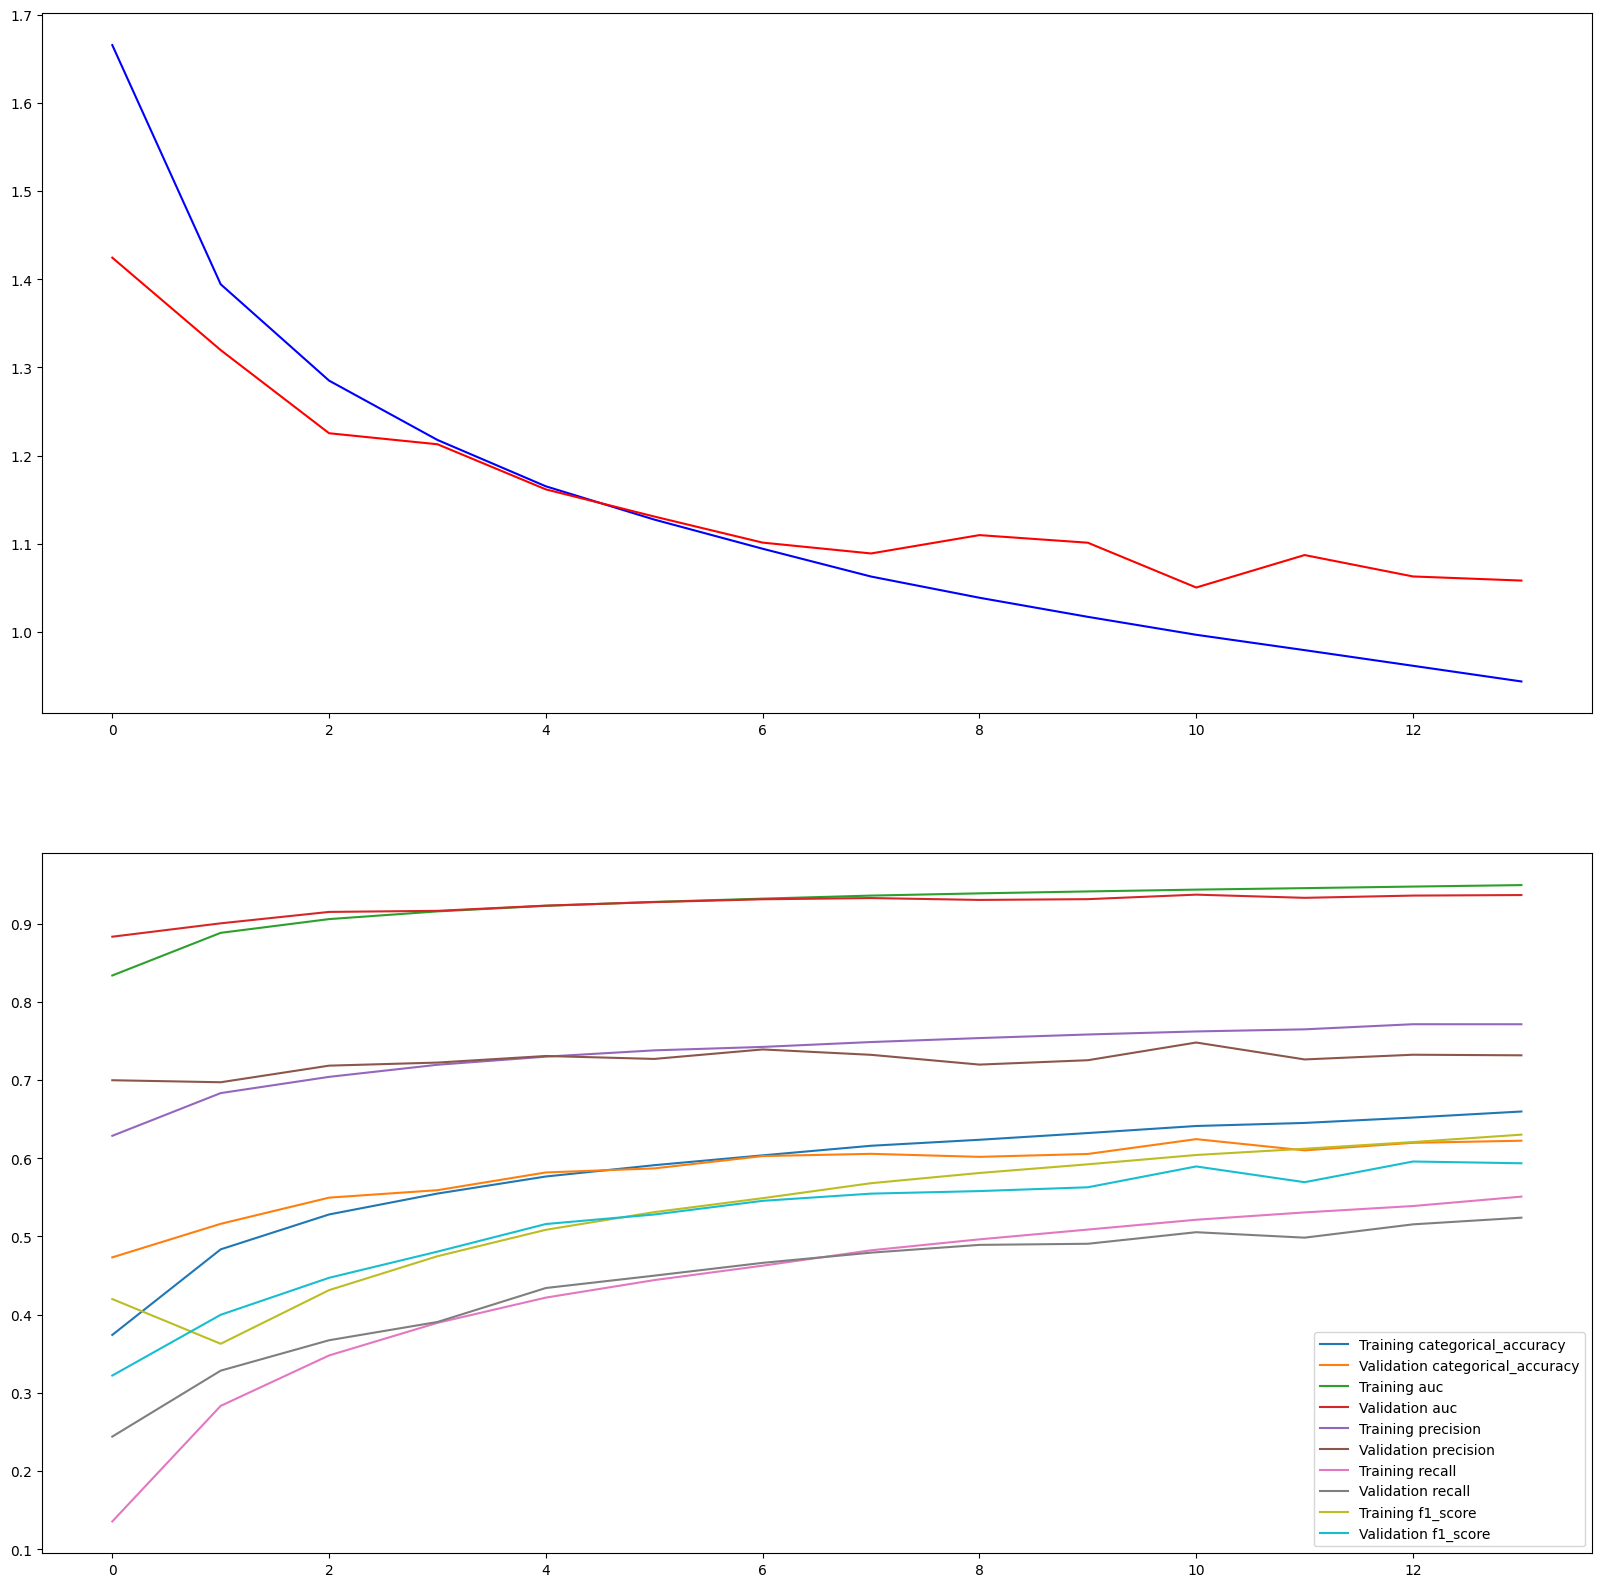

In [26]:
show_training_validation_loss_and_metrics(model34,metrics2)

In [27]:
model34.evaluate(test_it)

5625/5625 [==============================] - 43s 8ms/step - loss: 1.0658 - categorical_accuracy: 0.6218 - auc: 0.9359 - precision: 0.7284 - recall: 0.5229 - f1_score: 0.5922


[1.065752387046814,
 0.6217555403709412,
 0.9359163641929626,
 0.7283899188041687,
 0.5229111313819885,
 0.5921568870544434]

5625/5625 [==============================] - 22s 4ms/step


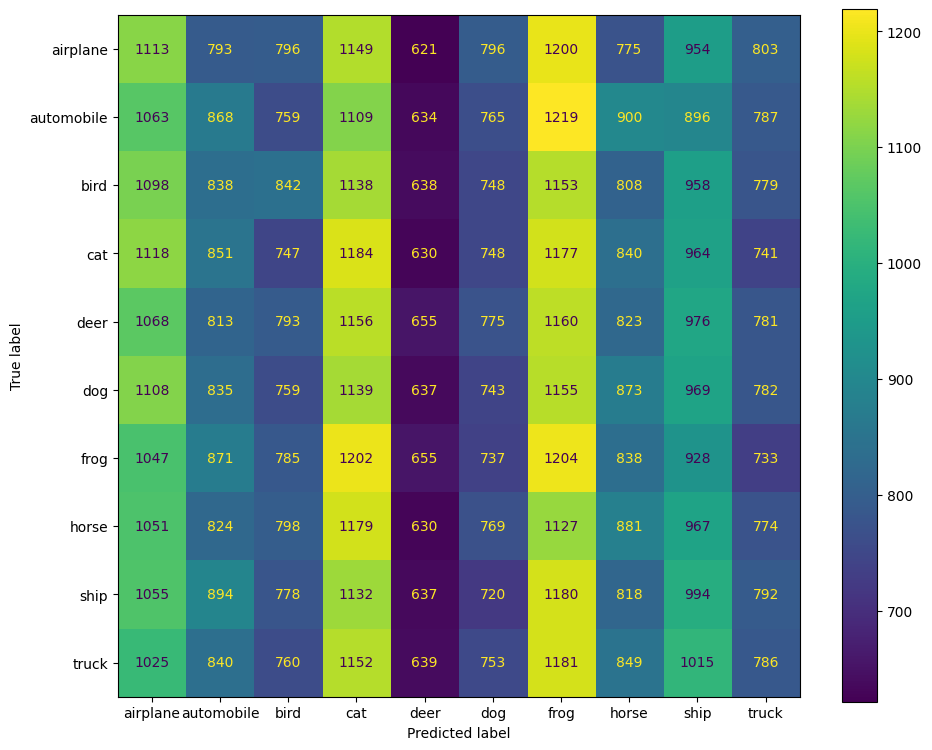

In [28]:
show_confusion_matrix(model34,test_ds,num_classes,class_names)

5625/5625 [==============================] - 23s 4ms/step


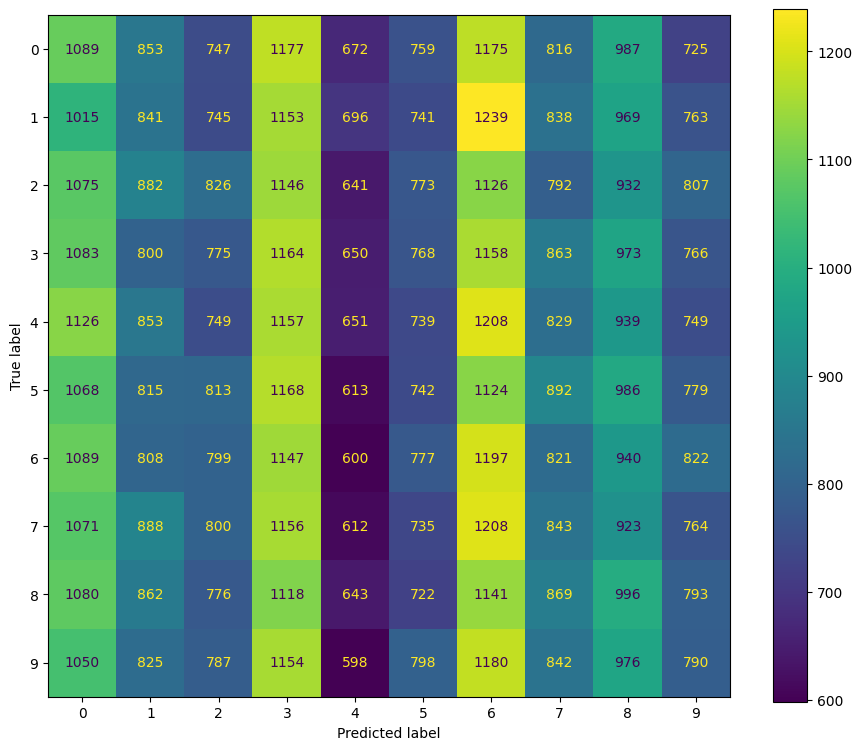

In [29]:
show_confusion_matrix_without_names(model34,test_ds,num_classes)